# UFC FIGHTS, WINNER PREDICTIONS

### Goals:

In this notebook, I will be attempting to find the best model for predicting the winner of UFC fights using historical data. This data has been provided by a user on Kaggle called mdabbert and the dataset (named Ultimate UFC Data) can be found at https://www.kaggle.com/mdabbert/ultimate-ufc-dataset. The dataset covers fights starting on March 21, 2010 at the event *UFC on Versus 1*.

As a hardcore fan of mixed martial arts (MMA) and someone who trains in certain disciplines, I will be able to bring a valueable level of domain knowledge for this dataset with relation to my task of an accurate predictive model for predicting winners and losers. Multiple models will be used and compared for performance. Models that will definitely be used is logistic regression and an artifical neural network for binary classification.

Other members on Kaggle were submitting models to maximize accuracy. I will be doing the same, but I am doing this project for my own purpose of building a model without as much data leakage. This means I will not be using the odds and evaluation variables provided by the dataset, as they can be converted to win probabilities for each fighter and were computed using models from other professionals / oddsmakers. I do not seek to use this outside information (at least right now). Perhaps a future project to maximize profit for betting is something I will explore, but for now I will be sticking to maximizing accuracy in predicting winners.

While this dataset is relatively clean, there is still some cleaning, EDA, and feature engineering to be done before it is suitable for analysis. Let's begin.

## DATA OVERVIEW AND EDA

In [1]:
# importing necessary libraries and setting default plot size for seaborn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set(rc={'figure.figsize':(12,8)})

In [2]:
# loading data
raw_data = pd.read_csv('data/ufc-master.csv')
# I want to display all columns
pd.set_option('display.max_columns', 300, 'display.max_rows', 150)
print(raw_data.shape)
raw_data.head(5)

(4495, 137)


R_fighter      B_fighter  R_odds  B_odds       R_ev   B_ev  \
0       Anthony Smith    Devin Clark    -139     115  71.942446  115.0   
1        Miguel Baeza   Takashi Sato    -175     140  57.142857  140.0   
2       Josh Parisian  Parker Porter    -200     160  50.000000  160.0   
3       Spike Carlyle     Bill Algeo    -177     140  56.497175  140.0   
4  Ashlee Evans-Smith   Norma Dumont    -137     110  72.992701  110.0   

         date                location country Winner  title_bout  \
0  11/28/2020  Las Vegas, Nevada, USA     USA    Red       False   
1  11/28/2020  Las Vegas, Nevada, USA     USA    Red       False   
2  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   
3  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   
4  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   

           weight_class  gender  no_of_rounds  B_current_lose_streak  \
0     Light Heavyweight    MALE             5                      0   
1          Welterweight    MALE             3                      0   
2           Heavyweight    MALE             3                      1   
3         Featherweight    MALE             3                      2   
4  Women's Bantamweight  FEMALE             3                      1   

   B_current_win_streak  B_draw  B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  \
0                     2       0                  3.40               0.57   
1                     1       0                  3.94               0.41   
2                     0       0                  6.82               0.43   
3                     0       0                  7.87               0.53   
4                     0       0                  1.42               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  \
0         4                     24                    0   
1         1                      6                    0   
2         1                      1                    0   
3         2                      6                    0   
4         1                      1                    0   

   B_win_by_Decision_Majority  B_win_by_Decision_Split  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
0                            6                0                    0   
1                            0                2                    0   
2                            0                0                    0   
3                            0                0                    0   
4                            0                0                    0   

   B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                             0       6  Orthodox        182.88       190.50   
1                             0       2  Southpaw        177.80       185.42   
2                             0       0  Orthodox        182.88       190.50   
3                             0       0    Switch        182.88       185.42   
4                             0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  R_draw  \
0           205                      2                     0       0   
1           170                      0                     3       

The dataset currently contains the dimesnions printed above. Each entry (row) in the dataset is an instance of a fight. In the sport of MMA, a fight consists of two participants fighting out of the (generally arbitrary) red and blue corners (the red corner walks second and is usually assigned to a higher ranked fighter or champion of a weight division).

Columns of note for predicting winners are the following columns starting with '_' mean that there are 2 columns for this feature as they are statistics for each of the fighters in the contested fight:
 - winner: corner color of the winner of the fight (Red and Blue), this is our label 
 - _avg_sig_str_landed: significant strikes by UFC metrics are ill defined, but generally are considered to be a 'strike' (punch, kick, knee elbow etc.) landed on an opponent regardless of impact force. This column is the amount landed per minute in previous fights
 - _avg_sig_str_pct: percentage of significant strikes landed (landed / total attempted)
 - _avg_SUB_ATT: submissions are a way to finish a fight usually through armlocks, chokes, or other submissions that come from judo, brazilian jiu jitsu, sambo etc.
 - _avg_TD_landed and _avg_TD_pct: average number of takedowns landed and average takedown percentage are referring to takedowns which are classic wrestling takedowns (taking someone to the ground) or trips, sweeps etc. from other martial arts. These are significant as a fighter on the ground while his opponent is above him is **in general** considered a very poor position
 - _total_rounds_fought: while not a true indicator od experience since rounds are 5 minutes in length and end quicker than others when fights are finished, this is still a good indicator. Also of note is that championship fights and main events for cards (which typically feature higher performing fighters) are 5 round contests, so champions gain a lot more experience in the octogon.
 - _win_by_ columns: these indicate how the previous wins happened for the fighters. Fighters that are winning by a stoppage of some kind (Knockouts, technical knockouts, doctor stoppages, and submissions) are almost always considered to be an indication of higher performance than decision victories (especially split decision victories).
 - dif columns: I am fortunate that this dataset has created features for the previously mentioned metrics that are the differences for the fighters. For example, a value of 0.5 in the column sig_str_dif means the blue fighter lands an average of 0.5 signficant strikes per minute more than the red fighter.

There are many columns and the following phases of EDA, cleaning, and pre-processing will reveal further discuss these columns, their value, and the explanation of what they mean in the actual sport itself.

First, however, I need to look at the missing values in the dataset.


#### Missing Values

In [3]:
# number of rows with missing values
len(raw_data) - len(raw_data.dropna(axis=0))

4495

Every single row has at least 1 missing value, let's take a look.

In [4]:
missing = pd.DataFrame(raw_data.isnull().sum())
# to make sure correct indexes are used when I eventually drop columns
missing['inds'] = np.arange(0,len(missing))
missing

0  inds
R_fighter                        0     0
B_fighter                        0     1
R_odds                           0     2
B_odds                           0     3
R_ev                             0     4
B_ev                             0     5
date                             0     6
location                         0     7
country                          0     8
Winner                           0     9
title_bout                       0    10
weight_class                     0    11
gender                           0    12
no_of_rounds                     0    13
B_current_lose_streak            0    14
B_current_win_streak             0    15
B_draw                           0    16
B_avg_SIG_STR_landed           930    17
B_avg_SIG_STR_pct              765    18
B_avg_SUB_ATT                  832    19
B_avg_TD_landed                833    20
B_avg_TD_pct                   842    21
B_longest_win_streak             0    22
B_losses                         0    23
B_total_rounds_fought            0    24
B_total_title_bouts              0    25
B_win_by_Decision_Majority       0    26
B_win_by_Decision_Split          0    27
B_win_by_Decision_Unanimous      0    28
B_win_by_KO/TKO                  0    29
B_win_by_Submission              0    30
B_win_by_TKO_Doctor_Stoppage     0    31
B_wins                           0    32
B_Stance                         0    33
B_Height_cms                     0    34
B_Reach_cms                      0    35
B_Weight_lbs                     0    36
R_current_lose_streak            0    37
R_current_win_streak             0    38
R_draw                           0    39
R_avg_SIG_STR_landed           455    40
R_avg_SIG_STR_pct              357    41
R_avg_SUB_ATT                  357    42
R_avg_TD_landed                357    43
R_avg_TD_pct                   367    44
R_longest_win_streak             0    45
R_losses                         0    46
R_total_rounds_fought            0    47
R_total_title_bouts              0    48
R_win_by_Decision_Majority       0    49
R_win_by_Decision_Split          0    50
R_win_by_Decision_Unanimous      0    51
R_win_by_KO/TKO                  0    52
R_win_by_Submission              0    53
R_win_by_TKO_Doctor_Stoppage     0    54
R_wins                           0    55
R_Stance                         0    56
R_Height_cms                     0    57
R_Reach_cms                      0    58
R_Weight_lbs                     0    59
R_age                            0    60
B_age                            0    61
lose_streak_dif                  0    62
win_streak_dif                   0    63
longest_win_streak_dif           0    64
win_dif                          0    65
loss_dif                         0    66
total_round_dif                  0    67
total_title_bout_dif             0    68
ko_dif                           0    69
sub_dif                          0    70
height_dif                       0    71
reach_dif                        0    72
age_dif                          0    73
sig_str_dif                      0    74
avg_sub_att_dif                  0    75
avg_td_dif                       0    76
empty_arena                      0    77
constant_1                       0    78
B_match_weightclass_rank      3701    79
R_match_weightclass_rank      3283    80
R_Women's Flyweight_rank      4450    81
R_Women's Featherweight_rank  4489    82
R_Women's Strawweight_rank    4400    83
R_Women's Bantamweight_rank   4386    84
R_Heavyweight_rank            4364    85
R_Light Heavyweight_rank      4365    86
R_Middleweight_rank           4376    87
R_Welterweight_rank           4365    88
R_Lightweight_rank            4369    89
R_Featherweight_rank          4371    90
R_Bantamweight_rank           4370    91
R_Flyweight_rank              4363    92
R_Pound-for-Pound_rank        4347    93
B_Women's Flyweight_rank      4463    94
B_Women's Featherweight_rank  4495    95
B_Women's Strawweight_rank    4441    96
B_Women's Banta

So, some glaring problems present themselves, but the good news is that there are some easy fixes. There are many missing values for the back / second half of columns. These columns represent information mainly relating to metrics or outcomes during/after the fights that each row represents. These columns are of no interest to the task of predicting fight outcomes and in fact are a data leakage for the task since the prediction for fight outcomes obviously do not involve information that is only gained during or at the conclusion of the contest. These columns representing indiviudal fight metrics and not past performance metrics can be dropped. Also, there are columns for every weight class (male and female) in the UFC organization. A fighter is ranked in only 1 and very rarley two of these divisions, so they will have null values in all the remaning ranking columns. Since there is already two features that give the ranking in their respective wieght classes, I can remove these unecessary columns. Every row has a null value due to these columns. A new dataframe will be created without columns related to ranking, metrics for the fight, and information relating to how the fight ended (since we are concerned soley with win or lose, not how the fight ended).

In [5]:
missing.index.get_loc("R_Women's Flyweight_rank")

81

In [6]:
# providing
drop_inds = list(np.arange(start=missing.index.get_loc("R_Women's Flyweight_rank"), stop= len(missing)))
df = raw_data.drop(columns=raw_data.columns[drop_inds])

In [7]:
df.head()

R_fighter      B_fighter  R_odds  B_odds       R_ev   B_ev  \
0       Anthony Smith    Devin Clark    -139     115  71.942446  115.0   
1        Miguel Baeza   Takashi Sato    -175     140  57.142857  140.0   
2       Josh Parisian  Parker Porter    -200     160  50.000000  160.0   
3       Spike Carlyle     Bill Algeo    -177     140  56.497175  140.0   
4  Ashlee Evans-Smith   Norma Dumont    -137     110  72.992701  110.0   

         date                location country Winner  title_bout  \
0  11/28/2020  Las Vegas, Nevada, USA     USA    Red       False   
1  11/28/2020  Las Vegas, Nevada, USA     USA    Red       False   
2  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   
3  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   
4  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   

           weight_class  gender  no_of_rounds  B_current_lose_streak  \
0     Light Heavyweight    MALE             5                      0   
1          Welterweight    MALE             3                      0   
2           Heavyweight    MALE             3                      1   
3         Featherweight    MALE             3                      2   
4  Women's Bantamweight  FEMALE             3                      1   

   B_current_win_streak  B_draw  B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  \
0                     2       0                  3.40               0.57   
1                     1       0                  3.94               0.41   
2                     0       0                  6.82               0.43   
3                     0       0                  7.87               0.53   
4                     0       0                  1.42               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  \
0         4                     24                    0   
1         1                      6                    0   
2         1                      1                    0   
3         2                      6                    0   
4         1                      1                    0   

   B_win_by_Decision_Majority  B_win_by_Decision_Split  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
0                            6                0                    0   
1                            0                2                    0   
2                            0                0                    0   
3                            0                0                    0   
4                            0                0                    0   

   B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                             0       6  Orthodox        182.88       190.50   
1                             0       2  Southpaw        177.80       185.42   
2                             0       0  Orthodox        182.88       190.50   
3                             0       0    Switch        182.88       185.42   
4                             0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  R_draw  \
0           205                      2                     0       0   
1           170                      0                     3       

In [8]:
missing = pd.DataFrame(df.isnull().sum())
# to make sure correct indexes are used when I eventually drop columns
missing['inds'] = np.arange(0,len(missing))
missing

0  inds
R_fighter                        0     0
B_fighter                        0     1
R_odds                           0     2
B_odds                           0     3
R_ev                             0     4
B_ev                             0     5
date                             0     6
location                         0     7
country                          0     8
Winner                           0     9
title_bout                       0    10
weight_class                     0    11
gender                           0    12
no_of_rounds                     0    13
B_current_lose_streak            0    14
B_current_win_streak             0    15
B_draw                           0    16
B_avg_SIG_STR_landed           930    17
B_avg_SIG_STR_pct              765    18
B_avg_SUB_ATT                  832    19
B_avg_TD_landed                833    20
B_avg_TD_pct                   842    21
B_longest_win_streak             0    22
B_losses                         0    23
B_total_rounds_fought            0    24
B_total_title_bouts              0    25
B_win_by_Decision_Majority       0    26
B_win_by_Decision_Split          0    27
B_win_by_Decision_Unanimous      0    28
B_win_by_KO/TKO                  0    29
B_win_by_Submission              0    30
B_win_by_TKO_Doctor_Stoppage     0    31
B_wins                           0    32
B_Stance                         0    33
B_Height_cms                     0    34
B_Reach_cms                      0    35
B_Weight_lbs                     0    36
R_current_lose_streak            0    37
R_current_win_streak             0    38
R_draw                           0    39
R_avg_SIG_STR_landed           455    40
R_avg_SIG_STR_pct              357    41
R_avg_SUB_ATT                  357    42
R_avg_TD_landed                357    43
R_avg_TD_pct                   367    44
R_longest_win_streak             0    45
R_losses                         0    46
R_total_rounds_fought            0    47
R_total_title_bouts              0    48
R_win_by_Decision_Majority       0    49
R_win_by_Decision_Split          0    50
R_win_by_Decision_Unanimous      0    51
R_win_by_KO/TKO                  0    52
R_win_by_Submission              0    53
R_win_by_TKO_Doctor_Stoppage     0    54
R_wins                           0    55
R_Stance                         0    56
R_Height_cms                     0    57
R_Reach_cms                      0    58
R_Weight_lbs                     0    59
R_age                            0    60
B_age                            0    61
lose_streak_dif                  0    62
win_streak_dif                   0    63
longest_win_streak_dif           0    64
win_dif                          0    65
loss_dif                         0    66
total_round_dif                  0    67
total_title_bout_dif             0    68
ko_dif                           0    69
sub_dif                          0    70
height_dif                       0    71
reach_dif                        0    72
age_dif                          0    73
sig_str_dif                      0    74
avg_sub_att_dif                  0    75
avg_td_dif                       0    76
empty_arena                      0    77
constant_1                       0    78
B_match_weightclass_rank      3701    79
R_match_weightclass_rank      3283    80

Now let's see the missing values.

The majority of the missing values are still in a weight class ranking column. This column gives the rank of the fighter in their weight class. In the UFC, the top 15 fighters in a weight class are giving a rank with the best being 1, 2nd best 2 etc. Additionally, there is a champion for each weight class, meaning 16 fighters in every weight class have a distinction/ranking.

I am assuming the null values are for fighters who are unranked. These values can be changed to 0. However, the rankings would need to be reversed in order to give a heirarchy of skill level. For example, a fighter ranked 1 would have a value of 15 assigned to them so that they are 15 points ahead of an unranked fighter as opposed to only 1. Also, champions should have a value of at least 16, but perhaps more value can be assigned to them (18 points perhaps?). This will all be handled in my feature engineering process, but for now I can put in values for the fighters that are unranked. First I need to check what ranking the champions are assigned. I know that Kamaru Usman was a champion in his fights against Jorge Masvidal and Colby Covington, so let's see what his rank is.

In [9]:
df[df['R_fighter']=='Kamaru Usman'].iloc[:,[0,1,-2,-1]]

R_fighter           B_fighter  B_match_weightclass_rank  \
226   Kamaru Usman      Jorge Masvidal                       3.0   
683   Kamaru Usman     Colby Covington                       2.0   
1391  Kamaru Usman           Emil Meek                       NaN   
1550  Kamaru Usman       Sergio Moraes                       NaN   
1746  Kamaru Usman     Sean Strickland                       NaN   
2075  Kamaru Usman  Alexander Yakovlev                       NaN   
2332  Kamaru Usman        Leon Edwards                       NaN   
2534  Kamaru Usman       Hayder Hassan                       NaN   

      R_match_weightclass_rank  
226                        0.0  
683                        0.0  
1391                      10.0  
1550                      13.0  
1746                      11.0  
2075                       NaN  
2332                       NaN  
2534                       NaN

So Champions are assigned a value of 0. Let's leave that as it is and when I do feature engineering I can decide how to handle the missing values since there won't be any EDA on rankings. Let's see what null values remain.

In [10]:
missing[0][missing[0]!=0]

B_avg_SIG_STR_landed         930
B_avg_SIG_STR_pct            765
B_avg_SUB_ATT                832
B_avg_TD_landed              833
B_avg_TD_pct                 842
R_avg_SIG_STR_landed         455
R_avg_SIG_STR_pct            357
R_avg_SUB_ATT                357
R_avg_TD_landed              357
R_avg_TD_pct                 367
B_match_weightclass_rank    3701
R_match_weightclass_rank    3283
Name: 0, dtype: int64

So, metric for past fights still have null values. Let's take a look at some of these features.

In [11]:
# getting column names with of missing values
missing_names = list(missing[0][missing[0]!=0].index.values)

In [12]:
missing_names

['B_avg_SIG_STR_landed',
 'B_avg_SIG_STR_pct',
 'B_avg_SUB_ATT',
 'B_avg_TD_landed',
 'B_avg_TD_pct',
 'R_avg_SIG_STR_landed',
 'R_avg_SIG_STR_pct',
 'R_avg_SUB_ATT',
 'R_avg_TD_landed',
 'R_avg_TD_pct',
 'B_match_weightclass_rank',
 'R_match_weightclass_rank']

In [13]:
df[df['R_fighter']=='Alex Morono']

R_fighter        B_fighter  R_odds  B_odds       R_ev   B_ev  \
27   Alex Morono       Rhys McKee    -177     140  56.497175  140.0   
475  Alex Morono  Kalinn Williams    -345     285  28.985507  285.0   
853  Alex Morono        Zak Ottow    -175     155  57.142857  155.0   

           date                location country Winner  title_bout  \
27   11/14/2020  Las Vegas, Nevada, USA     USA    Red       False   
475    2/8/2020     Houston, Texas, USA     USA   Blue       False   
853    3/9/2019    Wichita, Kansas, USA     USA    Red       False   

     weight_class gender  no_of_rounds  B_current_lose_streak  \
27   Welterweight   MALE             3                      1   
475  Welterweight   MALE             3                      0   
853  Welterweight   MALE             3                      0   

     B_current_win_streak  B_draw  B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  \
27                      0       0              0.000000           0.000000   
475                     0       0              0.000000           0.000000   
853                     1       0             27.571429           0.358571   

     B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
27        0.000000         0.000000      0.000000                     0   
475       0.000000         0.000000      0.000000                     0   
853       0.285714         0.571429      0.152857                     1   

     B_losses  B_total_rounds_fought  B_total_title_bouts  \
27          1                      1                    0   
475         0                      0                    0   
853         3                     16                    0   

     B_win_by_Decision_Majority  B_win_by_Decision_Split  \
27                            0                        0   
475                           0                        0   
853                           0                        3   

     B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
27                             0                0                    0   
475                            0                0                    0   
853                            0                1                    0   

     B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  B_Height_cms  \
27                              0       0  Orthodox        187.96   
475                             0       0  Orthodox        182.88   
853                             0       4  Orthodox        180.34   

     B_Reach_cms  B_Weight_lbs  R_current_lose_streak  R_current_win_streak  \
27        198.12           170                      1                     0   
475       182.88           170                      0                     3   
853       182.88           170                      0                     1   

     R_draw  R_avg_SIG_STR_landed  R_avg_SIG_STR_pct  R_avg_SUB_ATT  \
27        0              4.420000           0.390000       0.600000   
475       0              4.420000           0.390000       0.600000   
853       0             51.714286           0.382857       0.428571   

     R_avg_TD_landed  R_avg_TD_pct  R_longest_win_streak  R_losses  \
27               0.0           0.0                     3         3   
475              0.0           0.0                     3         2   
853              0.0           0.0                     2         3   

     R_total_rounds_fought  R_total_title_bouts  R_win_by_Decision_Majority  \
27                      23                    0                           0   
475                     22                    0                           0   
853                     18                    0                           0   

     R_win_by_Decision_Split  R_win_by_Decision_Unanimous  R_win_by_KO/TKO  \
27                         1                            3                1   
475                        1                            3                1   
853                        1                            2               

In [14]:
missing_metrics_df = df.loc[:,['R_fighter','B_fighter'] +missing_names[0:len(missing_names)-2]]
missing_metrics_df = missing_metrics_df[missing_metrics_df.isna().any(axis=1)]
missing_metrics_df

R_fighter          B_fighter  B_avg_SIG_STR_landed  \
574      Curtis Blaydes  Junior Dos Santos                   NaN   
575    Rafael Dos Anjos     Michael Chiesa                   NaN   
576     Jordan Espinosa         Alex Perez                   NaN   
577       Hannah Cifers        Angela Hill                   NaN   
578        Jamahal Hill       Darko Stosic                   NaN   
...                 ...                ...                   ...   
4473  Charlie Brenneman         Jason High                   NaN   
4483     Matthew Riddle          Greg Soto                   NaN   
4490       Duane Ludwig      Darren Elkins                   NaN   
4491        John Howard     Daniel Roberts                   NaN   
4493        Mike Pierce      Julio Paulino                   NaN   

      B_avg_SIG_STR_pct  B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  \
574                0.48            0.1             0.33          0.80   
575                0.41            1.2             3.55          0.48   
576                0.48            1.2             3.13          0.47   
577                0.50            0.1             0.39          0.36   
578                0.46            0.0             2.26          0.38   
...                 ...            ...              ...           ...   
4473                NaN            NaN              NaN           NaN   
4483                NaN            NaN              NaN           NaN   
4490                NaN            NaN              NaN           NaN   
4491                NaN            NaN              NaN           NaN   
4493                NaN            NaN              NaN           NaN   

      R_avg_SIG_STR_landed  R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_landed  \
574                    NaN           0.510000            0.0         7.050000   
575                    NaN           0.450000            0.7         1.890000   
576                    NaN           0.580000            0.5         0.920000   
577                    NaN           0.450000            0.4         0.410000   
578                    NaN           0.660000            0.0         0.000000   
...                    ...                ...            ...              ...   
4473                   NaN                NaN            NaN              NaN   
4483             45.750000           0.637500            1.0         3.750000   
4490             13.666667           0.576667            0.0         0.000000   
4491             18.000000           0.550000            1.0         4.666667   
4493             40.500000           0.405000            0.0         3.500000   

      R_avg_TD_pct  
574         0.6000  
575         0.3900  
576         0.2000  
577         1.0000  
578         0.0000  
...            ...  
4473           NaN  
4483        0.5025  
4490        0.0000  
4491        0.7900  
4493        0.5200  

[1041 rows x 12 columns]

The top of this dataframe shows some fighters have many metrics missing or all of them. I do suspect some of these missing values are due to one cause: a fighters first UFC fight. Fighters without any fights in the UFC organization will not have any metrics to be recorded in the dataset. Let's see if these exists. I know a recent breakout star called Khamzat Chimaev had his first breakout fights in summer of 2020. Let's see if he is missing stats for his first fight.

In [15]:
missing_metrics_df[(missing_metrics_df['B_fighter']=='Khamzat Chimaev') | (missing_metrics_df['R_fighter']=='Khamzat Chimaev')]

Empty DataFrame
Columns: [R_fighter, B_fighter, B_avg_SIG_STR_landed, B_avg_SIG_STR_pct, B_avg_SUB_ATT, B_avg_TD_landed, B_avg_TD_pct, R_avg_SIG_STR_landed, R_avg_SIG_STR_pct, R_avg_SUB_ATT, R_avg_TD_landed, R_avg_TD_pct]
Index: []

In [16]:
# checking other dataframe to make sure the fights are actually recorded
df[(df['B_fighter']=='Khamzat Chimaev') | (df['R_fighter']=='Khamzat Chimaev')]

R_fighter           B_fighter  R_odds  B_odds   R_ev        B_ev  \
109  Khamzat Chimaev  Gerald Meerschaert    -400     300   25.0  300.000000   
194  Khamzat Chimaev          Rhys McKee   -1250     700    8.0  700.000000   
220    John Phillips     Khamzat Chimaev     271    -375  260.0   28.985507   

          date                                    location  \
109  9/19/2020                      Las Vegas, Nevada, USA   
194  7/25/2020  Abu Dhabi, Abu Dhabi, United Arab Emirates   
220  7/15/2020  Abu Dhabi, Abu Dhabi, United Arab Emirates   

                  country Winner  title_bout  weight_class gender  \
109                   USA    Red       False  Middleweight   MALE   
194  United Arab Emirates    Red       False  Welterweight   MALE   
220  United Arab Emirates   Blue       False  Middleweight   MALE   

     no_of_rounds  B_current_lose_streak  B_current_win_streak  B_draw  \
109             3                      1                     0       0   
194             3                      0                     0       0   
220             3                      0                     0       0   

     B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  B_avg_SUB_ATT  B_avg_TD_landed  \
109                  3.31               0.42            1.7             2.34   
194                  0.00               0.00            0.0             0.00   
220                  0.00               0.00            0.0             0.00   

     B_avg_TD_pct  B_longest_win_streak  B_losses  B_total_rounds_fought  \
109          0.43                     2         5                     22   
194          0.00                     0         0                      0   
220          0.00                     0         0                      0   

     B_total_title_bouts  B_win_by_Decision_Majority  B_win_by_Decision_Split  \
109                    0                           0                        0   
194                    0                           0                        0   
220                    0                           0                        0   

     B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
109                            0                1                    5   
194                            0                0                    0   
220                            0                0                    0   

     B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  B_Height_cms  \
109                             0       6  Southpaw        185.42   
194                             0       0  Orthodox        185.42   
220                             0       0  Orthodox        187.96   

     B_Reach_cms  B_Weight_lbs  R_current_lose_streak  R_current_win_streak  \
109       195.58           185                      0                     2   
194       185.42           170                      0                     1   
220       187.96           185                      0                     1   

     R_draw  R_avg_SIG_STR_landed  R_avg_SIG_STR_pct  R_avg_SUB_ATT  \
109       0                  8.88               0.72            3.2   
194       0                  6.94               0.82            2.4   
220       0                  2.64               0.34            0.0   

     R_avg_TD_landed  R_avg_TD_pct  R_longest_win_streak  R_losses  \
109             4.81          0.75                     2         0   
194             4.84          1.00                     1         0   
220             0.00          0.00                     1         3   

     R_total_rounds_fought  R_total_title_bouts  R_win_by_Decision_Majority  \
109                      3                    0                           0   
194                      2                    0                           0   
220                      8                    0                           0   

     R_win_by_Decision_Split  R_win_by_Decision_Unanimous  R_win_by_KO/TKO  \
109                        0                            0           

In this instance, Khamzat simply has his totals as 0 accross the board. Im going to look at my missing values dataframe more closely to see what is going on.

In [17]:
missing_metrics_df[0:50]

R_fighter              B_fighter  B_avg_SIG_STR_landed  \
574         Curtis Blaydes      Junior Dos Santos                   NaN   
575       Rafael Dos Anjos         Michael Chiesa                   NaN   
576        Jordan Espinosa             Alex Perez                   NaN   
577          Hannah Cifers            Angela Hill                   NaN   
578           Jamahal Hill           Darko Stosic                   NaN   
579            Bevon Lewis        Dequan Townsend                   NaN   
580           Arnold Allen              Nik Lentz                   NaN   
581           Justine Kish          Luci Pudilova                   NaN   
582         Montel Jackson         Felipe Colares                   NaN   
583            Sara McMann          Lina Lansberg                   NaN   
584            Brett Johns           Tony Gravely                   NaN   
585          Herbert Burns          Nate Landwehr                   NaN   
612            Demian Maia             Ben Askren                   NaN   
613        Michael Johnson             Stevie Ray                   NaN   
614          Frank Camacho         Beneil Dariush                   NaN   
623         Conor McGregor         Donald Cerrone                   NaN   
624             Holly Holm      Raquel Pennington                   NaN   
625        Aleksei Oleinik         Maurice Greene                   NaN   
626         Anthony Pettis         Diego Ferreira                   NaN   
627      Roxanne Modafferi          Maycee Barber                   NaN   
628             Andre Fili           Sodiq Yusuff                   NaN   
629             Drew Dober       Nasrat Haqparast                   NaN   
630           Aleksa Camur           Justin Ledet                   NaN   
631            Tim Elliott          Askar Askarov                   NaN   
632         Brian Kelleher           Ode Obsourne                   NaN   
633            Sabina Mazo             JJ Aldrich                   NaN   
634         Jorge Masvidal              Nate Diaz                   NaN   
635        Kelvin Gastelum            Darren Till                   NaN   
636       Stephen Thompson          Vicente Luque                   NaN   
637          Derrick Lewis          Blagoy Ivanov                   NaN   
638              Kevin Lee       Gregor Gillespie                   NaN   
639         Corey Anderson          Johnny Walker                   NaN   
640           Shane Burgos       Makwan Amirkhani                   NaN   
641           Brad Tavares       Edmen Shahbazyan                   NaN   
642        Andrei Arlovski  Jairzinho Rozenstruik                   NaN   
643      Katlyn Chookagian          Jennifer Maia                   NaN   
644             Lyman Good      Chance Rencountre                   NaN   
645             Julio Arce          Hakeem Dawodu                   NaN   
646  Zabit Magomedsharipov          Calvin Kattar                   NaN   
647       Alekander Volkov             Greg Hardy                   NaN   
648          Zelim Imadaev          Danny Roberts                   NaN   
649       Khadis Ibragimov              Ed Herman                   NaN   
650          Ramazan Emeev           Rocco Martin                   NaN   
651        Shamil Gamzatov          Klidson Abreu                   NaN   
652       Magomed Ankalaev     Dalcha Lungiambula                   NaN   
653        Rustam Khabilov      Sergey Khandozhko                   NaN   
654          Roman Kopylov          Karl Roberson                   NaN   
655  Abubakar Nurmagomedov           David Zawada                   NaN   
656     Alexander Yakovlev      Roosevelt Roberts                   NaN   
657     Jessica-Rose Clark         Pannie Kianzad                   NaN   

     B_avg_SIG_STR_pct  B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  \
574               0.48            0.1             0.33          0.80   
575               0.41            1.2          

In [18]:
missing_metrics_df[300:350]

R_fighter              B_fighter  B_avg_SIG_STR_landed  \
1545         Daichi Abe           Hyun Gyu Lim             40.500000   
1547         Mike Perry             Alex Reyes                   NaN   
1551       Justin Ledet             Zu Anyanwu                   NaN   
1565      Luis Henrique          Arjan Bhullar                   NaN   
1568  Siyar Bahadurzada          Rob Wilkinson                   NaN   
1569      Marion Reneau        Talita Bernardo                   NaN   
1573    Michel Prazeres           Mads Burnell                   NaN   
1575  Francimar Barroso       Aleksandar Rakic                   NaN   
1576      Mike Santiago  Zabit Magomedsharipov                   NaN   
1577   Bojan Mihajlovic     Abdul-Kerim Edilov                   NaN   
1582       Martin Bravo      Humberto Bandenay                   NaN   
1589     Joseph Morales        Roberto Sanchez                   NaN   
1592        Cris Cyborg          Tonya Evinger                   NaN   
1598         Andre Fili          Calvin Kattar                   NaN   
1600       Eric Shelton          Jarred Brooks                   NaN   
1607       Rafael Natal            Eryk Anders                   NaN   
1612        Tim Johnson          Junior Albini                   NaN   
1620     James Mulheron          Justin Willis                   NaN   
1623       Charlie Ward         Galore Bofando                   NaN   
1624        Danny Henry          Daniel Teymur                   NaN   
1626       Leslie Smith           Amanda Lemos                   NaN   
1636       Cody Stamann           Terrion Ware                   NaN   
1637       Trevin Giles        James Bochnovic                   NaN   
1638    Michael Johnson         Justin Gaethje                   NaN   
1640    Jared Cannonier          Nick Roehrick                   NaN   
1644       James Krause         Tom Gallicchio                   NaN   
1656       Jared Gordon        Michel Quinones                   NaN   
1665       Alex Caceres             Rolando Dy                   NaN   
1668        Naoki Inoue    Carls John De Tomas                   NaN   
1669        Ji Yeon Kim         Lucie Pudilova             99.000000   
1677        Luke Jumeau       Dominique Steele             23.750000   
1678        John Moraga      Ashkan Mokhtarian                   NaN   
1680         JJ Aldrich            Chanmi Jeon                   NaN   
1686   Raphael Assuncao          Marlon Moraes                   NaN   
1688     Iuri Alcantara         Brian Kelleher                   NaN   
1695      Oliver Enkamp          Nordine Taleb             40.166667   
1709      Chase Sherman         Rashad Coulter                   NaN   
1724       Alexis Davis          Cindy Dandois                   NaN   
1732   Patrick Williams          Tom Duquesnoy                   NaN   
1742   Cynthia Calvillo         Pearl Gonzalez                   NaN   
1750        Josh Emmett          Desmond Green                   NaN   
1752        Jenel Lausa      Magomed Bibulatov                   NaN   
1763      Lina Lansberg         Lucie Pudilova                   NaN   
1769      Sergio Moraes             Davi Ramos                   NaN   
1773   Garreth McLellan            Paulo Costa                   NaN   
1777      Amanda Cooper       Cynthia Calvillo                   NaN   
1782       Mark Godbeer           Daniel Spitz                   NaN   
1784     Albert Morales     Andre Soukhamthath                   NaN   
1787        Sam Sicilia           Gavin Tucker                   NaN   
1789        Sara McMann            Gina Mazany                   NaN   

      B_avg_SIG_STR_pct  B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  \
1545           0.446667       0.166667         0.166667      0.166667   
1547                NaN            NaN              NaN           NaN   
1551                NaN            NaN              NaN           NaN   
1565                NaN            NaN           

In [19]:
missing_metrics_df.iloc[308,:]

R_fighter                       Mike Santiago
B_fighter               Zabit Magomedsharipov
B_avg_SIG_STR_landed                      NaN
B_avg_SIG_STR_pct                         NaN
B_avg_SUB_ATT                             NaN
B_avg_TD_landed                           NaN
B_avg_TD_pct                              NaN
R_avg_SIG_STR_landed                      NaN
R_avg_SIG_STR_pct                         NaN
R_avg_SUB_ATT                             NaN
R_avg_TD_landed                           NaN
R_avg_TD_pct                              NaN
Name: 1576, dtype: object

The two fighters above made their debut in this fight, and have missing values for their metrics. However, after observation, some fighters just have missing values even if it isn't their debut. This is tricky and needs to be handled with care. Since a fighters metrics are critical for predicting performance (at least in this dataset), there is no use in training or predicting fights with fighters who haven't even fought in the promotion yet. I think a good starting course of action is to remove the rows from my dataframe in which fighters haven't fought yet, even if it is a high percentage of the total data. To reiterate, **it is not worthwhile to train and predict fights when at least 1 of the fighters hasn't fought in the promotion and has no metrics.** There will likely be too many rows to impute values, and imputation will be harmful to training a model since there is a high variation of metrics in the sport of MMA depending on a fighters fighting style.

Let's see what proportion rows contain fighters making their debut.

In [20]:
len(df[(df['R_total_rounds_fought']==0) | (df['B_total_rounds_fought']==0)]) / len(df)

0.2453837597330367

About a quarter of the fights contested have at least 1 fighter making their debut. Although this is an extremely high percentage of the data, I feel justified in removing it. Having about 25% of the training data one a split is made contain imputed metrics will be catastrophic. Not only is there statisticaly justification, but in the context of predicting the outcome of a sports contest, I think it is suitable. It is not possible to have a model that predicts outcomes based on what will be imaginary numbers and a very high range of numbers. I will remove these rows.

In [21]:
df = df[(df['R_total_rounds_fought']!=0) & (df['B_total_rounds_fought']!=0)]

In [22]:
len(df[(df['R_total_rounds_fought']==0) | (df['B_total_rounds_fought']==0)])

0

In [23]:
print(df.shape)
df.head()

(3392, 81)


R_fighter      B_fighter  R_odds  B_odds       R_ev   B_ev  \
0       Anthony Smith    Devin Clark    -139     115  71.942446  115.0   
1        Miguel Baeza   Takashi Sato    -175     140  57.142857  140.0   
2       Josh Parisian  Parker Porter    -200     160  50.000000  160.0   
3       Spike Carlyle     Bill Algeo    -177     140  56.497175  140.0   
4  Ashlee Evans-Smith   Norma Dumont    -137     110  72.992701  110.0   

         date                location country Winner  title_bout  \
0  11/28/2020  Las Vegas, Nevada, USA     USA    Red       False   
1  11/28/2020  Las Vegas, Nevada, USA     USA    Red       False   
2  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   
3  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   
4  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   

           weight_class  gender  no_of_rounds  B_current_lose_streak  \
0     Light Heavyweight    MALE             5                      0   
1          Welterweight    MALE             3                      0   
2           Heavyweight    MALE             3                      1   
3         Featherweight    MALE             3                      2   
4  Women's Bantamweight  FEMALE             3                      1   

   B_current_win_streak  B_draw  B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  \
0                     2       0                  3.40               0.57   
1                     1       0                  3.94               0.41   
2                     0       0                  6.82               0.43   
3                     0       0                  7.87               0.53   
4                     0       0                  1.42               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  \
0         4                     24                    0   
1         1                      6                    0   
2         1                      1                    0   
3         2                      6                    0   
4         1                      1                    0   

   B_win_by_Decision_Majority  B_win_by_Decision_Split  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
0                            6                0                    0   
1                            0                2                    0   
2                            0                0                    0   
3                            0                0                    0   
4                            0                0                    0   

   B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                             0       6  Orthodox        182.88       190.50   
1                             0       2  Southpaw        177.80       185.42   
2                             0       0  Orthodox        182.88       190.50   
3                             0       0    Switch        182.88       185.42   
4                             0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  R_draw  \
0           205                      2                     0       0   
1           170                      0                     3       

Let's see what null values remain.

In [24]:
df.isnull().sum()[df.isnull().sum()>0]

B_avg_SIG_STR_landed          81
B_avg_TD_landed                1
B_avg_TD_pct                   7
R_avg_SIG_STR_landed          81
R_avg_TD_pct                   7
B_match_weightclass_rank    2608
R_match_weightclass_rank    2269
dtype: int64

In [25]:
df[df['B_avg_SIG_STR_landed'].isnull()][['date','R_fighter','B_fighter','B_avg_SIG_STR_landed','R_avg_SIG_STR_landed','B_avg_TD_pct','R_avg_TD_pct']]

date                 R_fighter              B_fighter  \
574   1/25/2020            Curtis Blaydes      Junior Dos Santos   
575   1/25/2020          Rafael Dos Anjos         Michael Chiesa   
576   1/25/2020           Jordan Espinosa             Alex Perez   
577   1/25/2020             Hannah Cifers            Angela Hill   
579   1/25/2020               Bevon Lewis        Dequan Townsend   
580   1/25/2020              Arnold Allen              Nik Lentz   
581   1/25/2020              Justine Kish          Luci Pudilova   
582   1/25/2020            Montel Jackson         Felipe Colares   
583   1/25/2020               Sara McMann          Lina Lansberg   
612  10/26/2019               Demian Maia             Ben Askren   
613  10/26/2019           Michael Johnson             Stevie Ray   
614  10/26/2019             Frank Camacho         Beneil Dariush   
623   1/18/2020            Conor McGregor         Donald Cerrone   
624   1/18/2020                Holly Holm      Raquel Pennington   
625   1/18/2020           Aleksei Oleinik         Maurice Greene   
626   1/18/2020            Anthony Pettis         Diego Ferreira   
627   1/18/2020         Roxanne Modafferi          Maycee Barber   
628   1/18/2020                Andre Fili           Sodiq Yusuff   
629   1/18/2020                Drew Dober       Nasrat Haqparast   
631   1/18/2020               Tim Elliott          Askar Askarov   
633   1/18/2020               Sabina Mazo             JJ Aldrich   
634   11/2/2019            Jorge Masvidal              Nate Diaz   
635   11/2/2019           Kelvin Gastelum            Darren Till   
636   11/2/2019          Stephen Thompson          Vicente Luque   
637   11/2/2019             Derrick Lewis          Blagoy Ivanov   
638   11/2/2019                 Kevin Lee       Gregor Gillespie   
639   11/2/2019            Corey Anderson          Johnny Walker   
640   11/2/2019              Shane Burgos       Makwan Amirkhani   
641   11/2/2019              Brad Tavares       Edmen Shahbazyan   
642   11/2/2019           Andrei Arlovski  Jairzinho Rozenstruik   
643   11/2/2019         Katlyn Chookagian          Jennifer Maia   
644   11/2/2019                Lyman Good      Chance Rencountre   
645   11/2/2019                Julio Arce          Hakeem Dawodu   
646   11/9/2019     Zabit Magomedsharipov          Calvin Kattar   
647   11/9/2019          Alekander Volkov             Greg Hardy   
648   11/9/2019             Zelim Imadaev          Danny Roberts   
649   11/9/2019          Khadis Ibragimov              Ed Herman   
650   11/9/2019             Ramazan Emeev           Rocco Martin   
652   11/9/2019          Magomed Ankalaev     Dalcha Lungiambula   
653   11/9/2019           Rustam Khabilov      Sergey Khandozhko   
656   11/9/2019        Alexander Yakovlev      Roosevelt Roberts   
657   11/9/2019        Jessica-Rose Clark         Pannie Kianzad   
658   11/9/2019            Grigorii Popov            Davey Grant   
659  11/16/2019            Jan Blachowicz           Jacare Souza   
660  11/16/2019          Charles Oliveira           Jared Gordon   
662  11/16/2019              Markus Perez      Wellington Turman   
663  11/16/2019             Sergio Moraes           James Krause   
664  11/16/2019             Ricardo Ramos      Eduardo Garagorri   
665  11/16/2019        Francisco Trinaldo            Bobby Green   
666  11/16/2019             Warlley Alves            Randy Brown   
667  11/16/2019  Douglas Silva de Andrade            Renan Barao   
670  12/21/2019             Frankie Edgar         Chan Sung Jung   
671  12/21/2019           Volkan Oezdemir       Aleksandar Rakic   
672  12/21/2019                Dooho Choi       Charles Jourdain   
673  12/21/2019                Da Un Jung         Mike Rodriguez   
674  12/21/2019             Jun Yong Park   Marc-Andre Barriault   
675  12/21/2019             Kyung Ho Kang           Liu Pingyuan   
676  12/21/2019                Ciryl Gane           Tanner Boser   

In [26]:
df[df['R_avg_TD_pct'].isnull()][['date','R_fighter','B_fighter','B_avg_SIG_STR_landed','R_avg_SIG_STR_landed','B_avg_TD_pct','R_avg_TD_pct']]

date         R_fighter              B_fighter  B_avg_SIG_STR_landed  \
696  12/7/2019  Alistair Overeem  Jairzinho Rozenstruik                   NaN   
697  12/7/2019     Stefan Struve           Ben Rothwell                   NaN   
698  12/7/2019        Aspen Ladd        Yana Kunitskaya                   NaN   
699  12/7/2019          Rob Font            Ricky Simon                   NaN   
700  12/7/2019      Thiago Alves              Tim Means                   NaN   
702  12/7/2019    Bryce Mitchell            Matt Sayles                   NaN   
705  12/7/2019   Makhmud Muradov           Trevor Smith                   NaN   

     R_avg_SIG_STR_landed  B_avg_TD_pct  R_avg_TD_pct  
696                   NaN           NaN           NaN  
697                   NaN           NaN           NaN  
698                   NaN           NaN           NaN  
699                   NaN           NaN           NaN  
700                   NaN           NaN           NaN  
702                   NaN           NaN           NaN  
705                   NaN           NaN           NaN

The remaining null values for the fighter metrics is mostly a few events that for some reason do not have values. I think at this point, these events are so few (about 80/3000), that I believe dropping them instead of imputing values is better at this point (again, these metrics are very important and I don't think imputations that are not accurate of fighters with certain styles is a correct course of action).

In [27]:
df = df.dropna(subset=['B_avg_SIG_STR_landed','R_avg_SIG_STR_landed','B_avg_TD_pct','R_avg_TD_pct'])

In [28]:
df.isnull().sum()[df.isnull().sum()>0]

B_match_weightclass_rank    2555
R_match_weightclass_rank    2225
dtype: int64

In [29]:
# resetting the index
df = df.reset_index(drop=True)

As these columns will not be analyzed (but used for later feature engineering) we can continue to proper EDA.

### EDA

In [30]:
# looking at a description of the frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311 entries, 0 to 3310
Data columns (total 81 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   R_fighter                     3311 non-null   object 
 1   B_fighter                     3311 non-null   object 
 2   R_odds                        3311 non-null   int64  
 3   B_odds                        3311 non-null   int64  
 4   R_ev                          3311 non-null   float64
 5   B_ev                          3311 non-null   float64
 6   date                          3311 non-null   object 
 7   location                      3311 non-null   object 
 8   country                       3311 non-null   object 
 9   Winner                        3311 non-null   object 
 10  title_bout                    3311 non-null   bool   
 11  weight_class                  3311 non-null   object 
 12  gender                        3311 non-null   object 
 13  no_

In [31]:
df.dtypes.value_counts()

int64      47
float64    23
object     10
bool        1
dtype: int64

In [32]:
df.dtypes[df.dtypes=='bool']

title_bout    bool
dtype: object

The boolean is a feature indicating if a fight is a title bout (where a champion is declared unless it is a draw or the winner of the contest missed weight). 

There are too many features to get any value looking at a heatmap of all of them, so let's first look at the values for red fighters and blue fighters seperately.

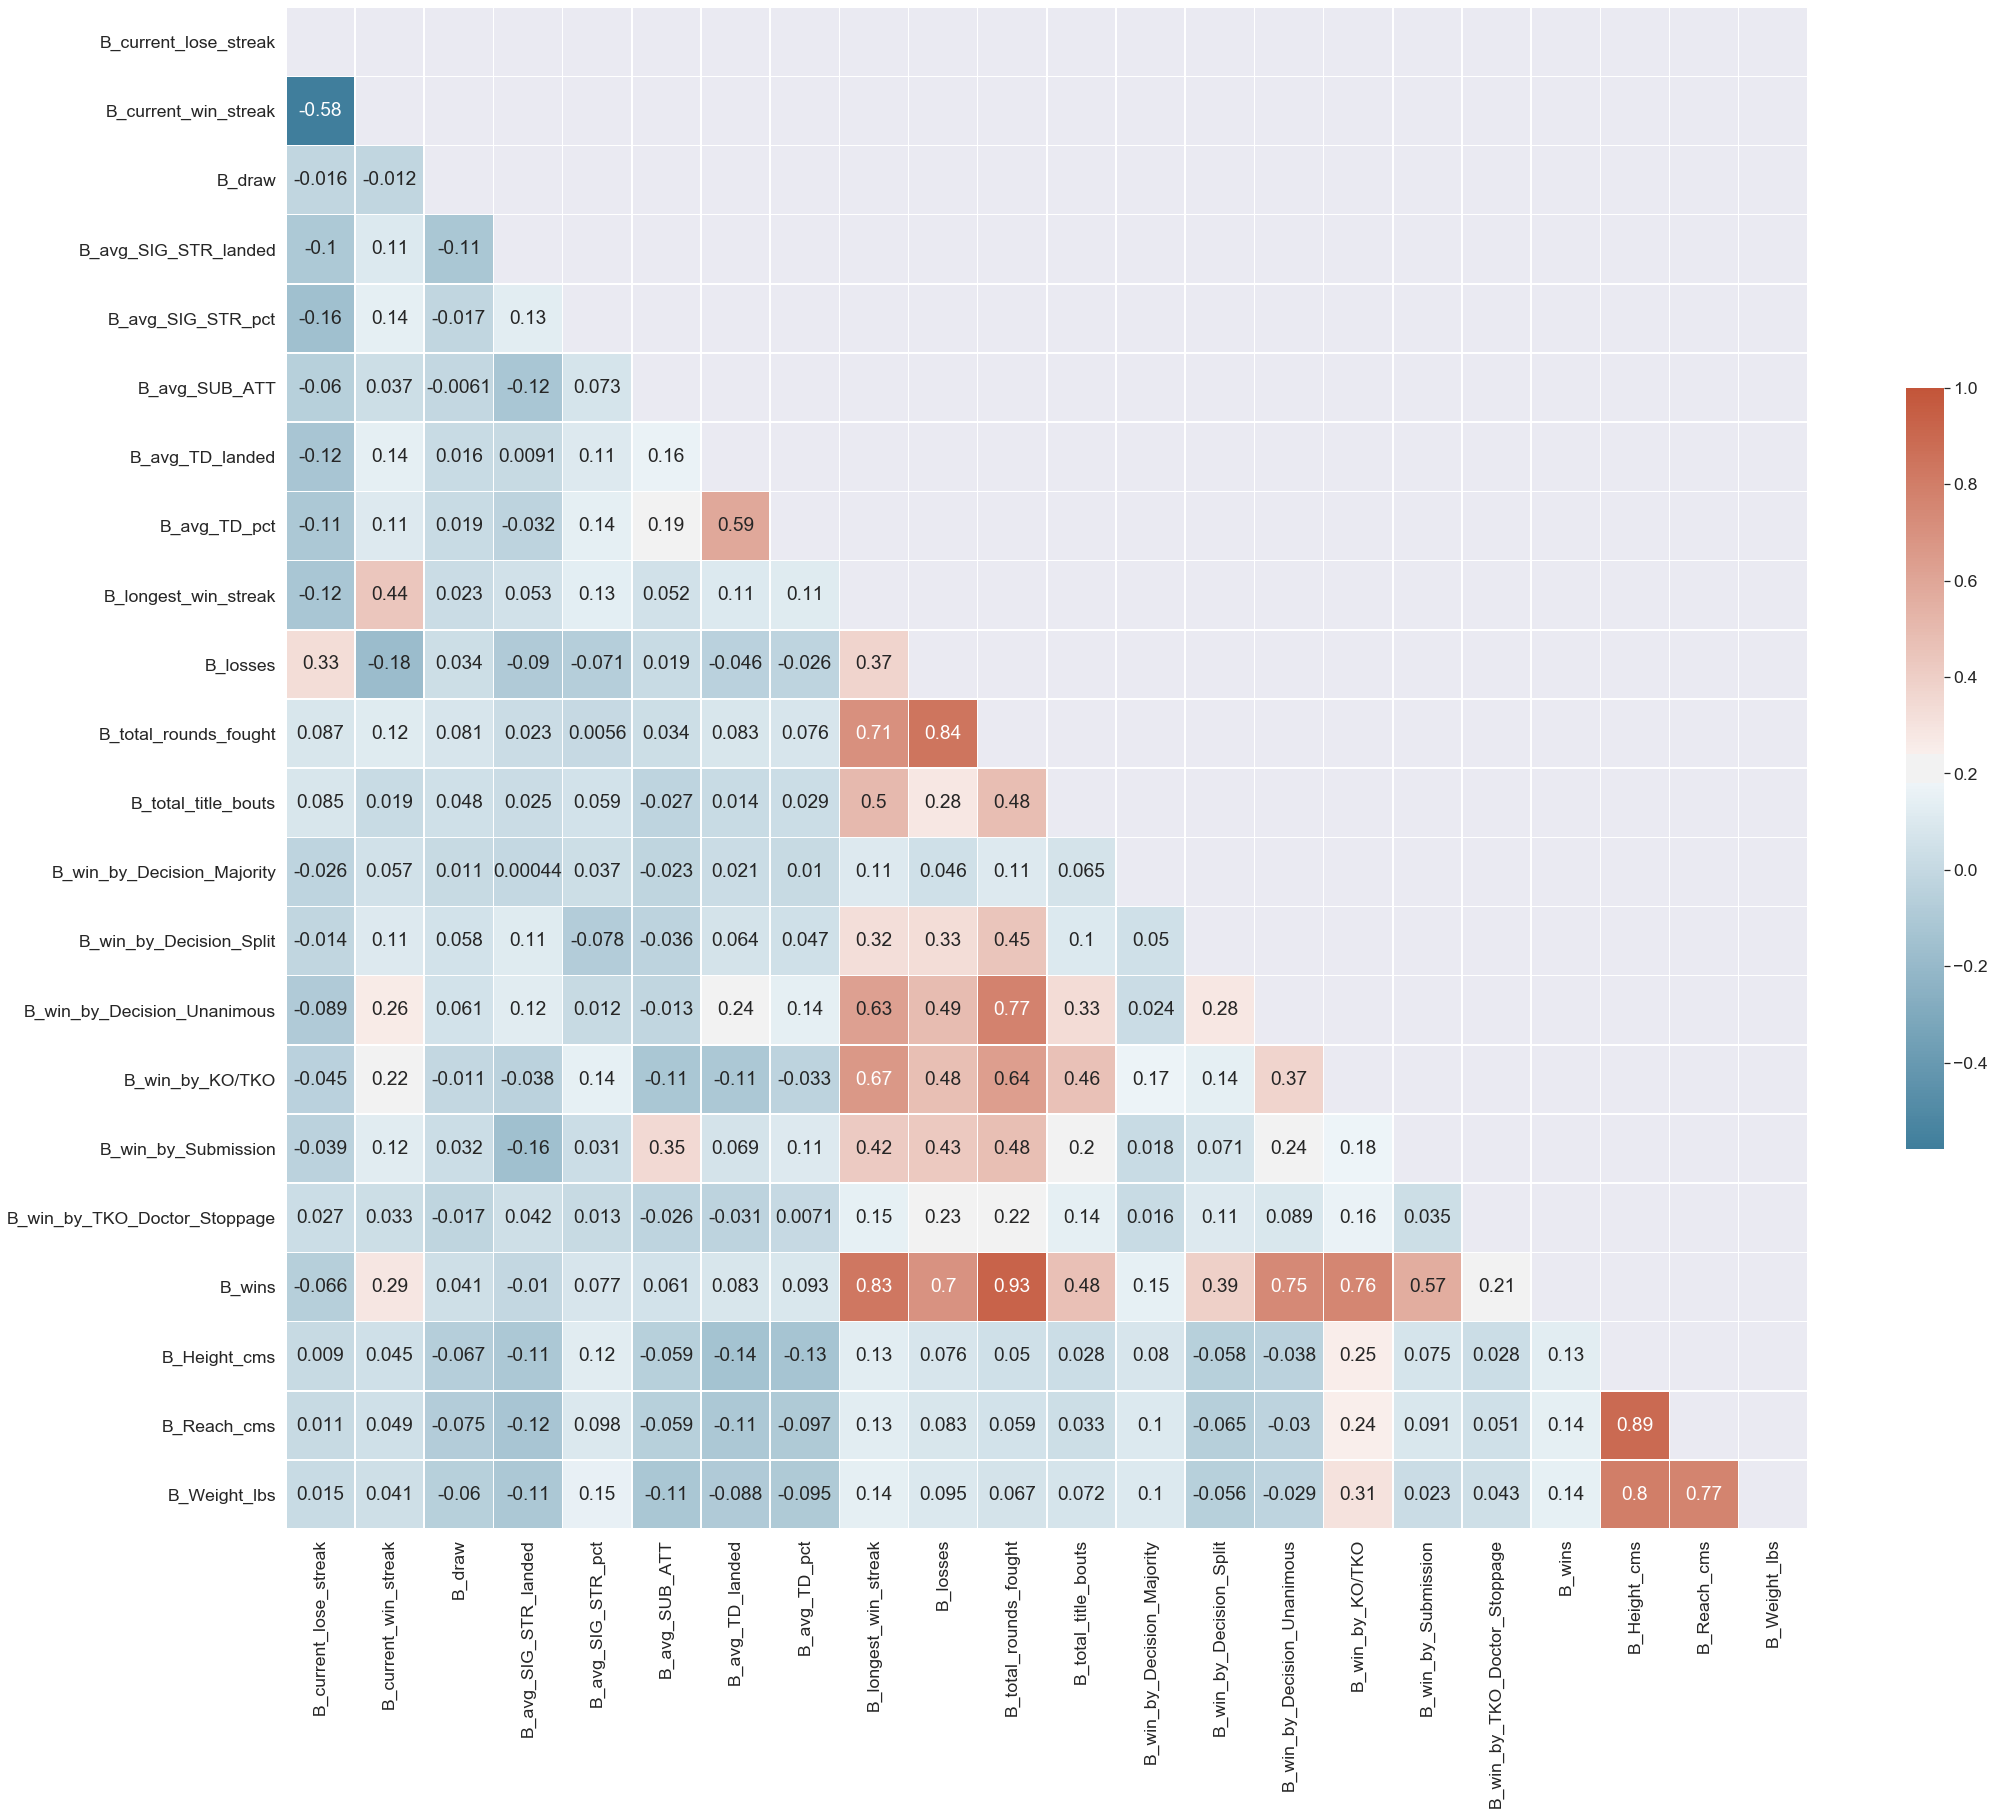

In [33]:
plt.figure(figsize=(35,28))
sns.set(font_scale=1.6)
corr = df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr.iloc[6:28, 6:28], dtype=bool))
sns.heatmap(corr.iloc[6:28, 6:28], cmap=cmap, annot=True, mask=mask,square=True, linewidths=.5, cbar_kws={"shrink": .5})

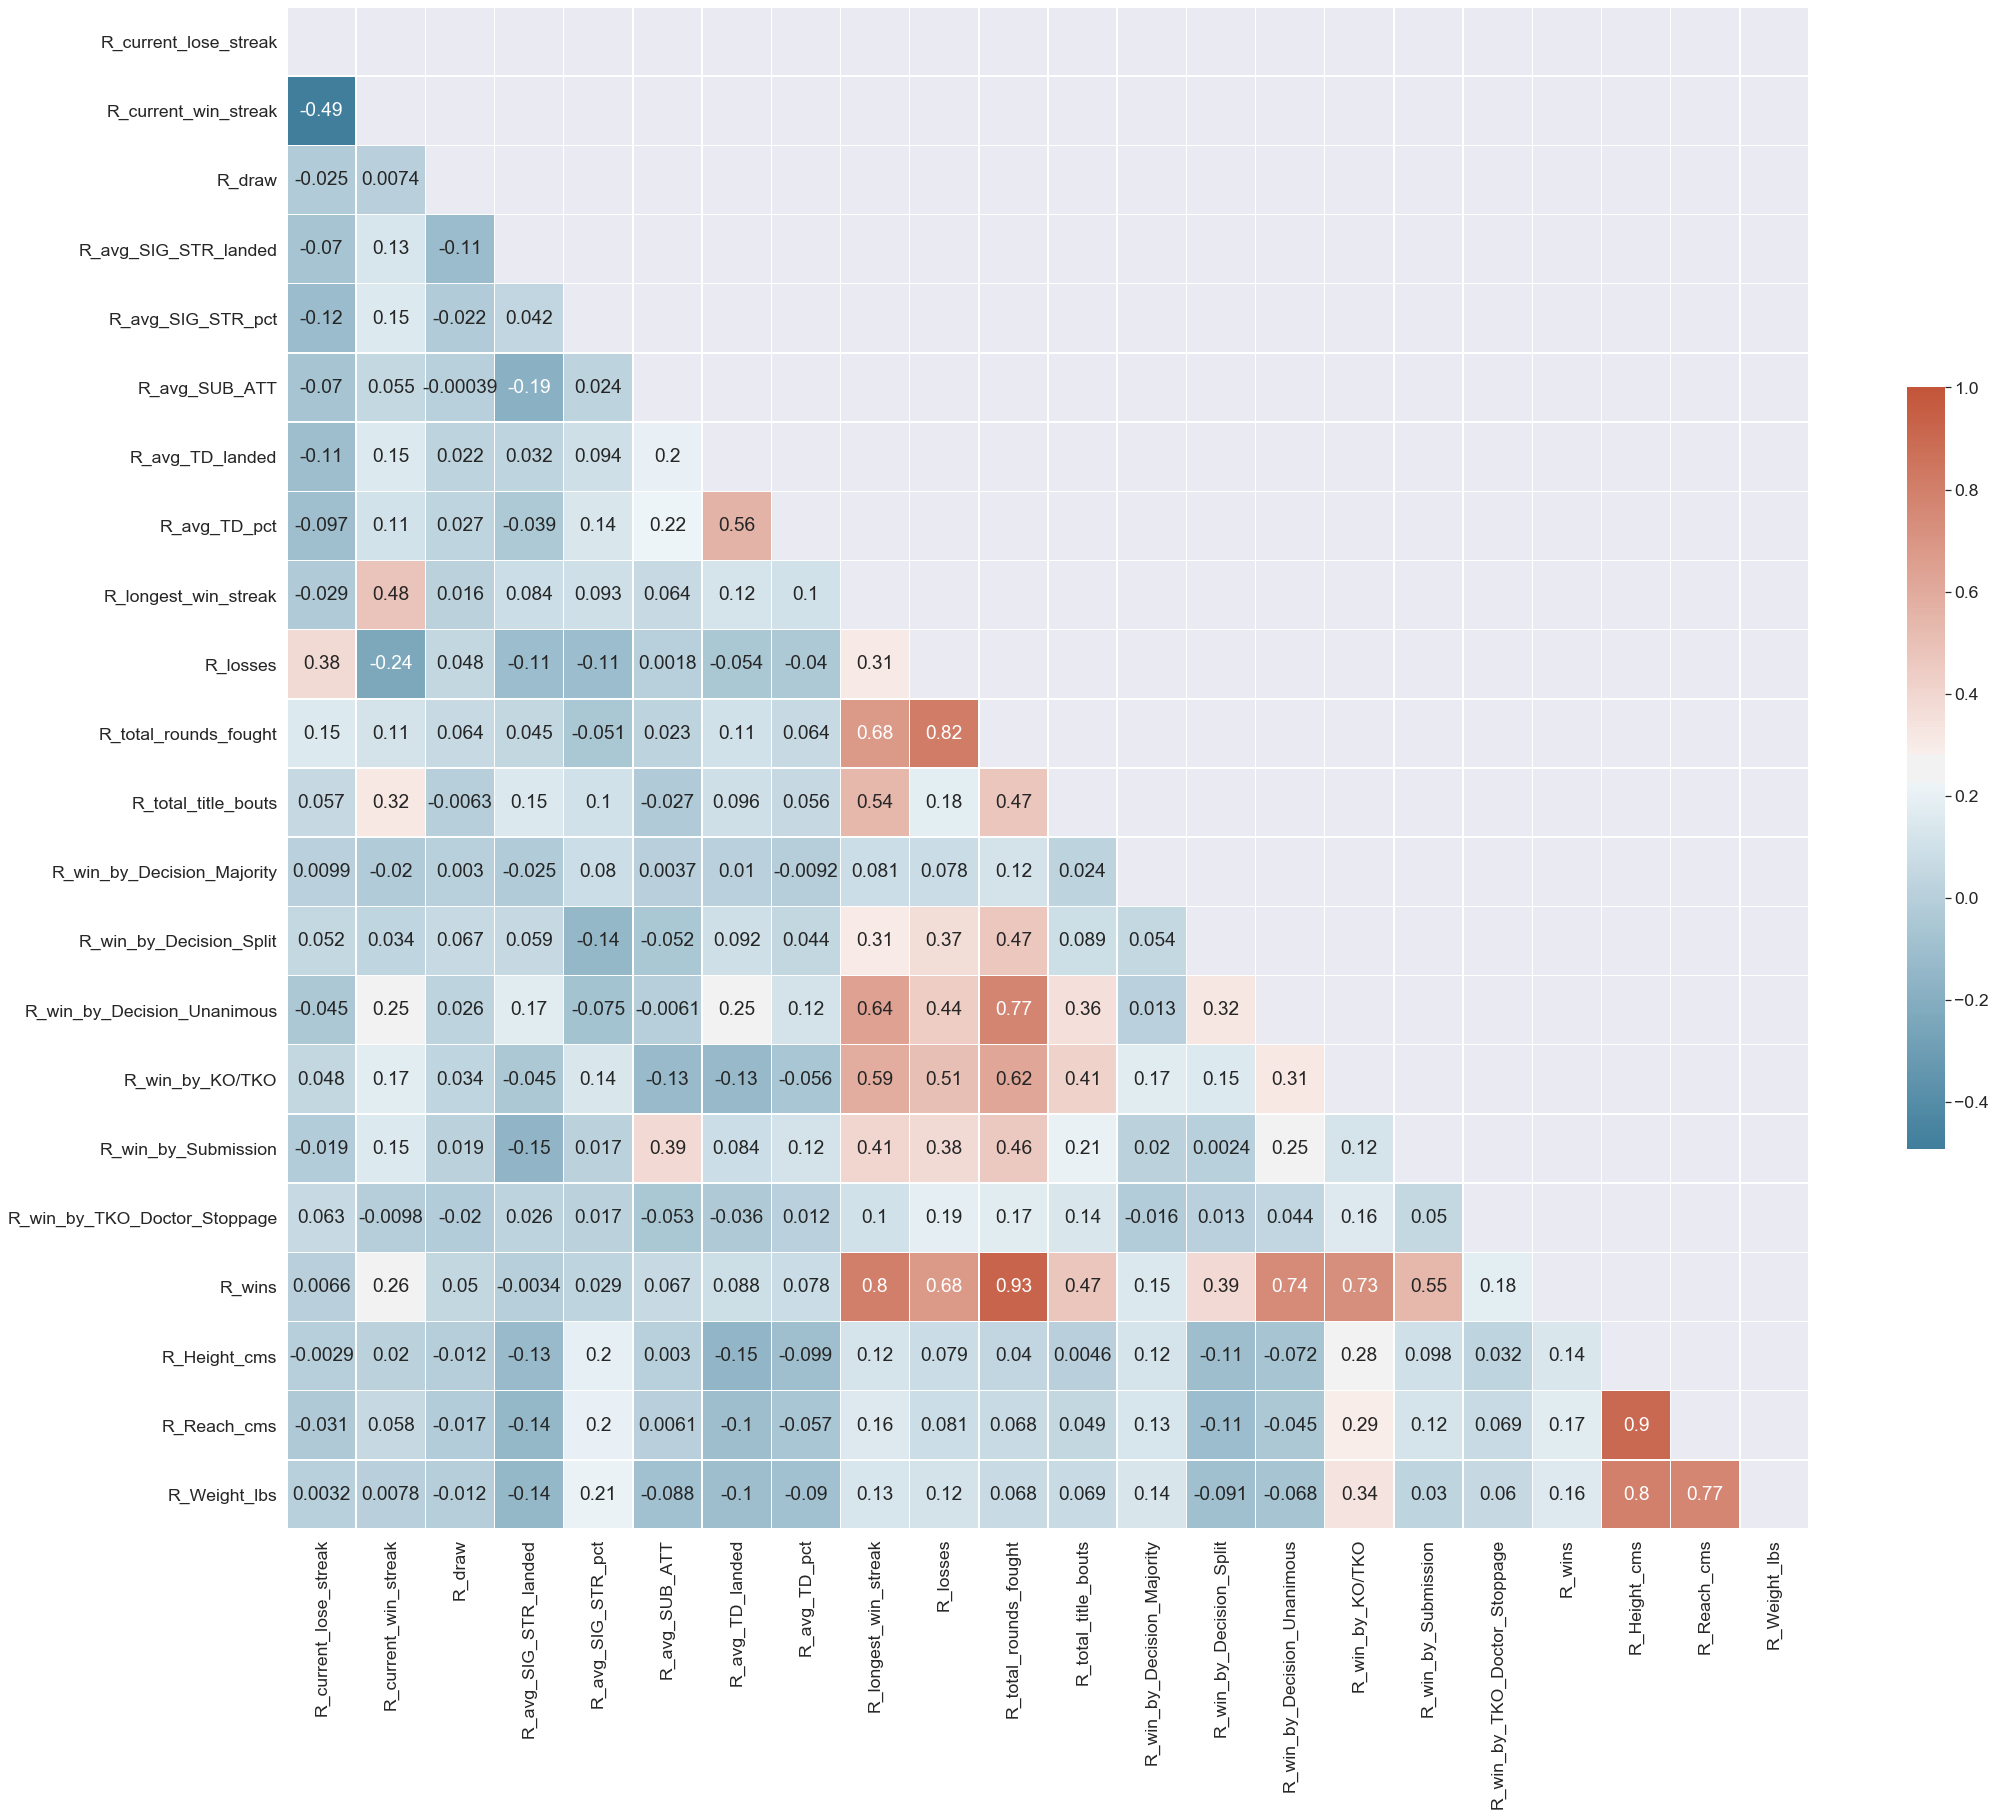

In [34]:
plt.figure(figsize=(35,28))
sns.set(font_scale=1.6)
mask = np.triu(np.ones_like(corr.iloc[28:50, 28:50], dtype=bool))
sns.heatmap(corr.iloc[28:50, 28:50], cmap=cmap, annot=True, mask=mask,square=True, linewidths=.5, cbar_kws={"shrink": .5})

Most importantly, we need to look at the numerical values for the difference in metric values between red and blue fighters.

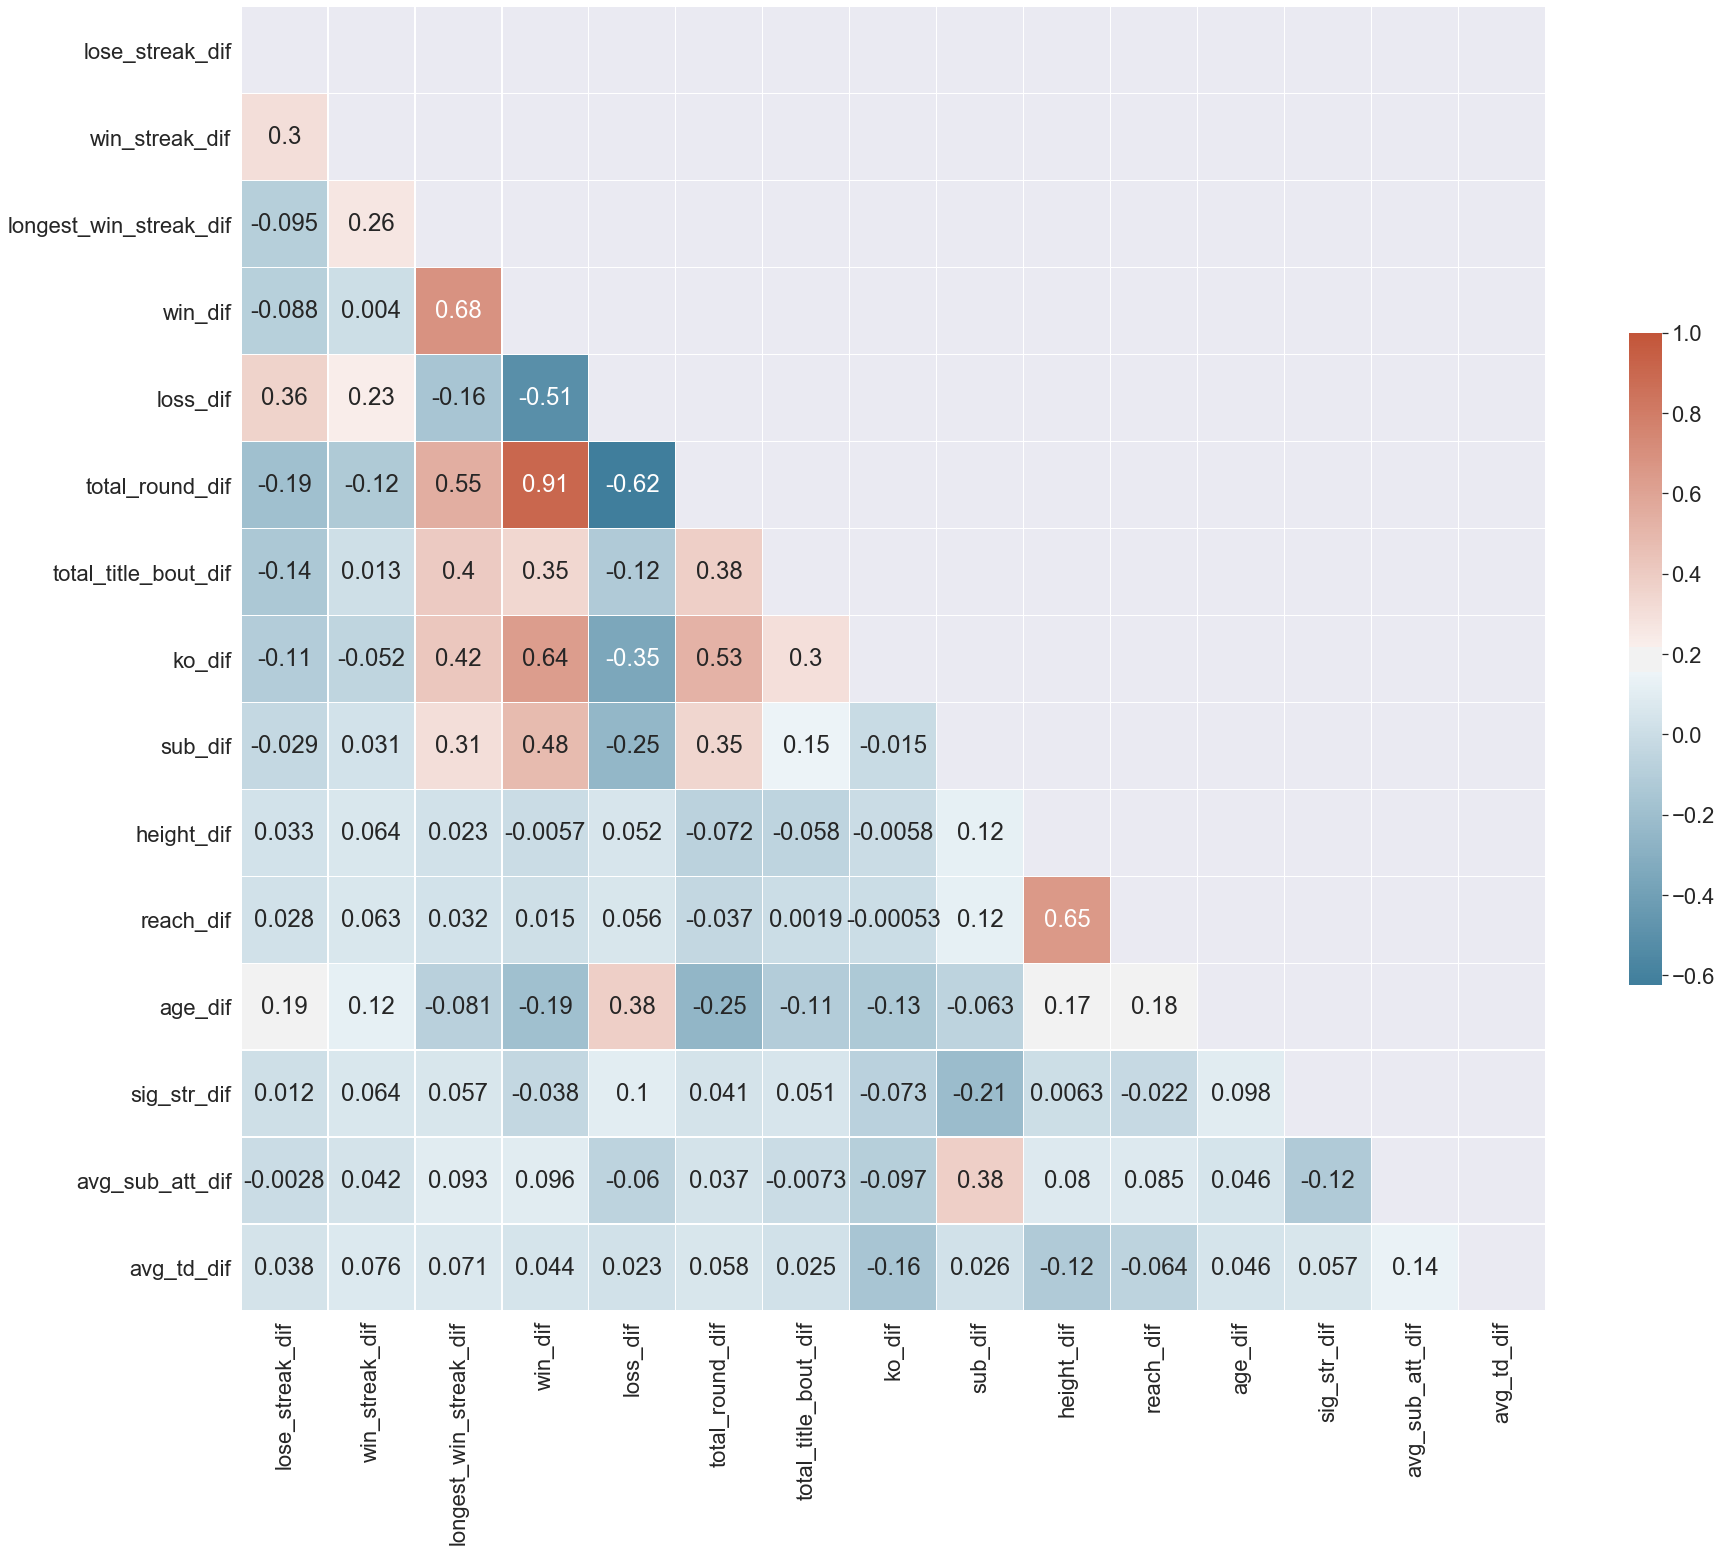

In [35]:
plt.figure(figsize=(30,24))
sns.set(font_scale=2.0)
mask = np.triu(np.ones_like(corr.iloc[52:67, 52:67], dtype=bool))
sns.heatmap(corr.iloc[52:67, 52:67], cmap=cmap, annot=True, mask=mask,square=True, linewidths=.5, cbar_kws={"shrink": .5})

It looks like most of the correlations here are not valueable. For example, the total round difference is correlated with the loss difference. This is because the more rounds (and more fights) a fighter has, the more losses they have, so a fighter with more rounds fought in than another fighter sensibly has more losses as they have competed more (and it should be noted that MMA contrasts boxing in 'perfect records'; many of the best fighters have multiple losses where boxing the top boxers maintain perfect or near perfect records).

I think looking at the different features individually will be more valueable. To do this, there will need to be a comparison of winner vs loser comparisons. The winner is described by the corner color.

In [36]:
# getting column names for blue metrics and red metrics
# taking a list of the column names from the indices I previously used for the heatmaps
blue_met_names = list(corr.columns.values[6:28])+['B_Stance']
red_met_names = list(corr.columns.values[28:50])+ ['R_Stance']

In [37]:
# need to create 2 dataframes for winner and loser stats
winners = pd.DataFrame(columns = [x.replace('B', '', 1) for x in blue_met_names])
losers = pd.DataFrame(columns = [x.replace('B', '', 1) for x in blue_met_names])

# check the winner in each row, and append the associated columns for that color to winners column, while the other
# colors column will be added to losers
for ind, row in df.iterrows():    
  
    if row['Winner'] == 'Blue':
        winners = winners.append(pd.DataFrame(row[blue_met_names].values.reshape(1,len(blue_met_names)), columns=winners.columns.values))
        losers = losers.append(pd.DataFrame(row[red_met_names].values.reshape(1,len(red_met_names)), columns=losers.columns.values))

    else:
        winners = winners.append(pd.DataFrame(row[red_met_names].values.reshape(1,len(red_met_names)), columns=winners.columns.values))
        losers = losers.append(pd.DataFrame(row[blue_met_names].values.reshape(1,len(blue_met_names)), columns=losers.columns.values))
    
    

In [38]:
# add winner or loser indicator to each frame
winners['outcome'] = 'winner'
losers['outcome'] = 'loser'
# combine along rows
winners_losers = pd.concat([winners,losers], axis=0)

In [39]:
winners_losers.reset_index(drop=True, inplace=True)

In [40]:
winners_losers.shape

(6622, 24)

In [41]:
winners_losers.describe()

_current_lose_streak  _current_win_streak  _draw  _avg_SIG_STR_landed  \
count                   6622                 6622   6622               6622.0   
unique                     8                   17      3               2319.0   
top                        0                    0      0                 18.0   
freq                    3738                 2886   6572                 50.0   

        _avg_SIG_STR_pct  _avg_SUB_ATT  _avg_TD_landed  _avg_TD_pct  \
count            6622.00        6622.0          6622.0       6622.0   
unique           1593.00         303.0           725.0       1652.0   
top                 0.41           0.0             0.0          0.0   
freq              123.00        2157.0          1099.0       1099.0   

        _longest_win_streak  _losses  _total_rounds_fought  \
count                  6622     6622                  6622   
unique                   18       18                    89   
top                       1        1                     3   
freq                   1708     1847                   626   

        _total_title_bouts  _win_by_Decision_Majority  _win_by_Decision_Split  \
count                 6622                       6622                    6622   
unique                  16                          3                       6   
top                      0                          0                       0   
freq                  5101                       6459                    4681   

        _win_by_Decision_Unanimous  _win_by_KO/TKO  _win_by_Submission  \
count                         6622            6622                6622   
unique                          11              16                  14   
top                              0               0                   0   
freq                          2394            2785                3813   

        _win_by_TKO_Doctor_Stoppage  _wins  _Height_cms  _Reach_cms  \
count                          6622   6622      6622.00      6622.0   
unique                            3     29        22.00        47.0   
top                               0      1       182.88       177.8   
freq                           6299   1268       748.00       644.0   

        _Weight_lbs   _Stance outcome  
count          6622      6622    6622  
unique           33         4       2  
top             170  Orthodox   loser  
freq           1261      4995    3311

Now that this frame has been created, we can begin to compare statistics for winners and losers. The dataframe has double the amount of fights in the original dataframe 'df', since the winner and loser metrics are now split.

#### winner / loser current win streak

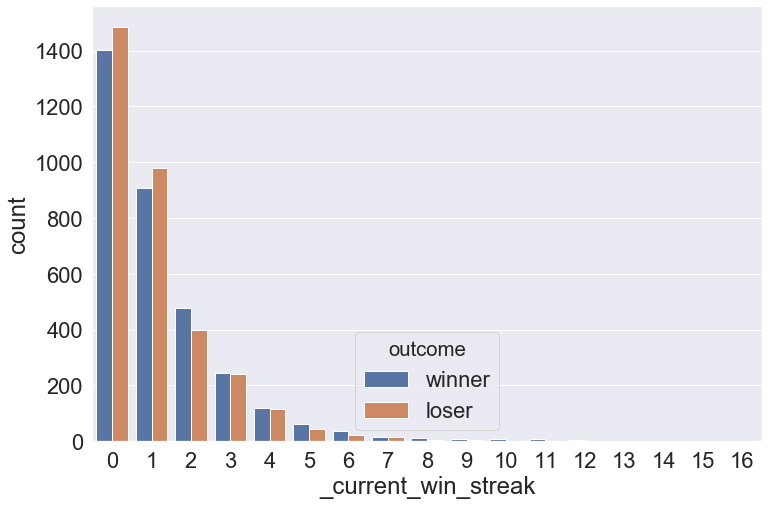

In [42]:
sns.countplot(x='_current_win_streak', data=winners_losers, hue='outcome')

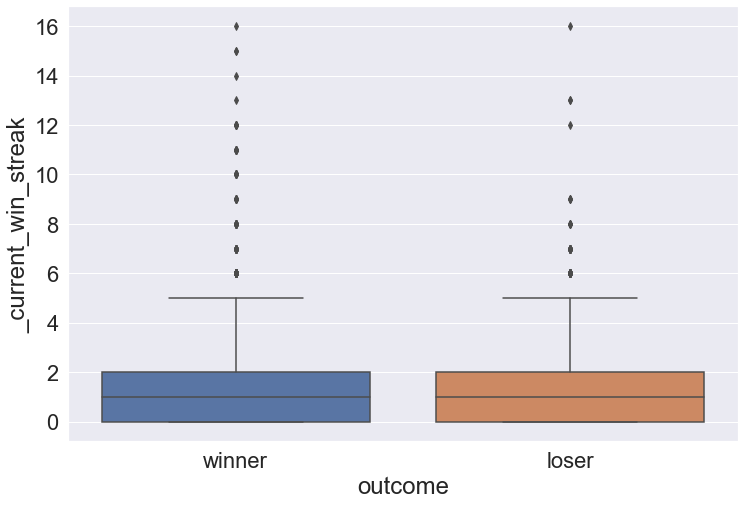

In [43]:
sns.boxplot(x='outcome', y='_current_win_streak', data = winners_losers)

The win streaks coming into a fight does not seem to give much explanation or indication of who the winner will be.

#### current lose streak

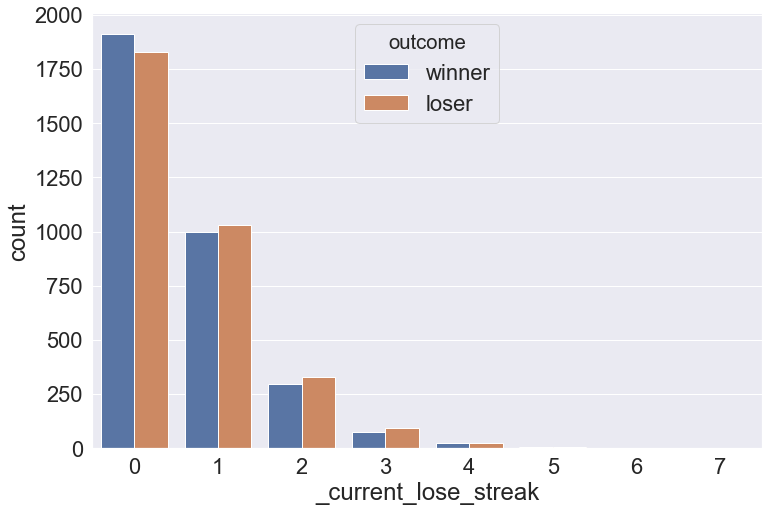

In [44]:
sns.countplot(x='_current_lose_streak', data=winners_losers, hue='outcome')

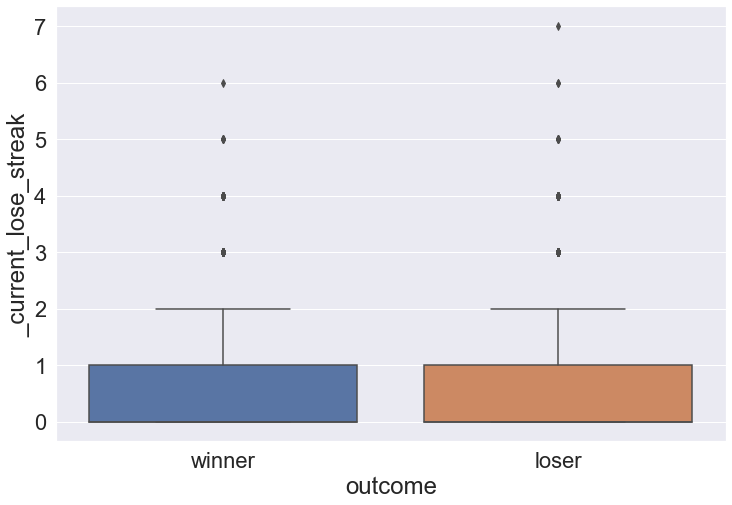

In [45]:
sns.boxplot(x='outcome', y='_current_lose_streak', data = winners_losers)

#### longest win streak

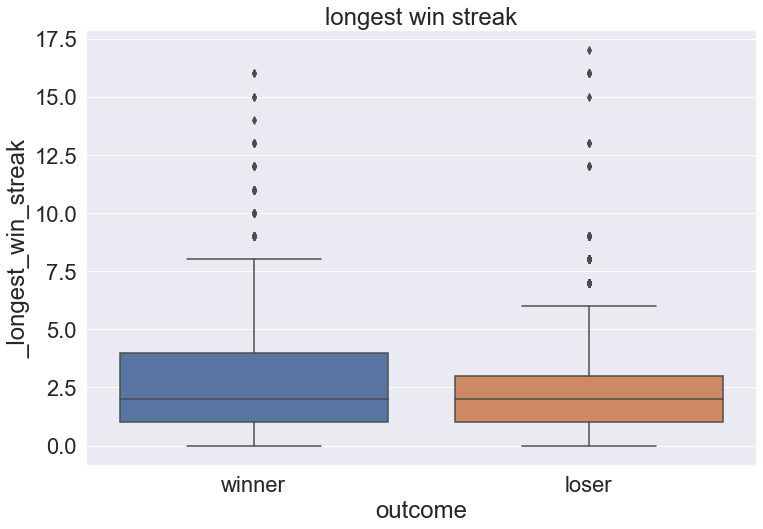

In [46]:
sns.boxplot(x='outcome', y='_longest_win_streak', data = winners_losers)
plt.title('longest win streak');

It seems that the top 50% of winners had a higher ceiling for their longest win streaks than the losers. Let's take a look at average signficiant strikes landed/min and significant striking percentage.

#### Signficiant strikng

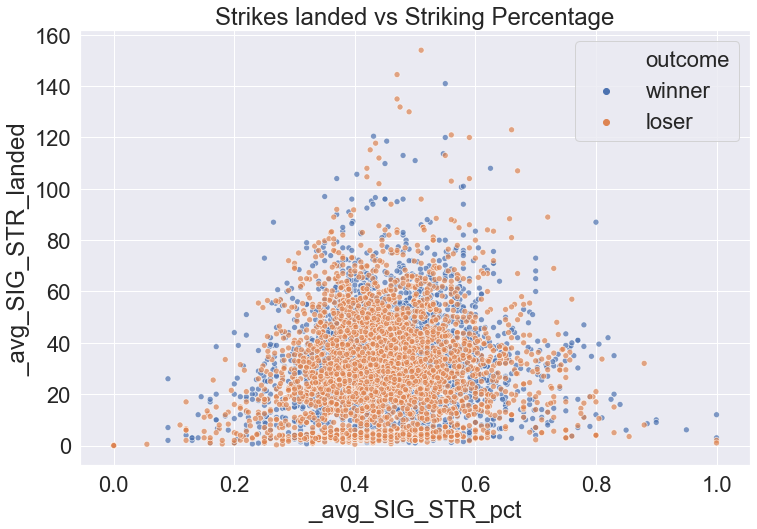

In [47]:
sns.scatterplot(x='_avg_SIG_STR_pct', y='_avg_SIG_STR_landed', data=winners_losers, hue='outcome', alpha=0.7)
plt.title('Strikes landed vs Striking Percentage');

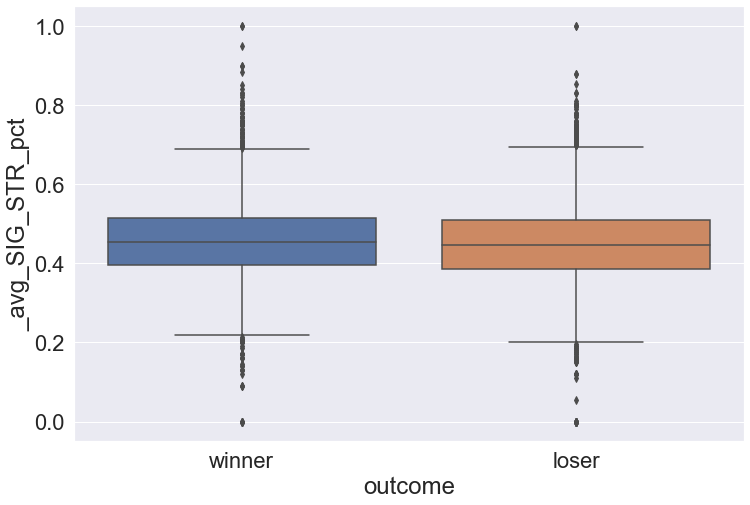

In [48]:
sns.boxplot(x='outcome', y='_avg_SIG_STR_pct', data=winners_losers);

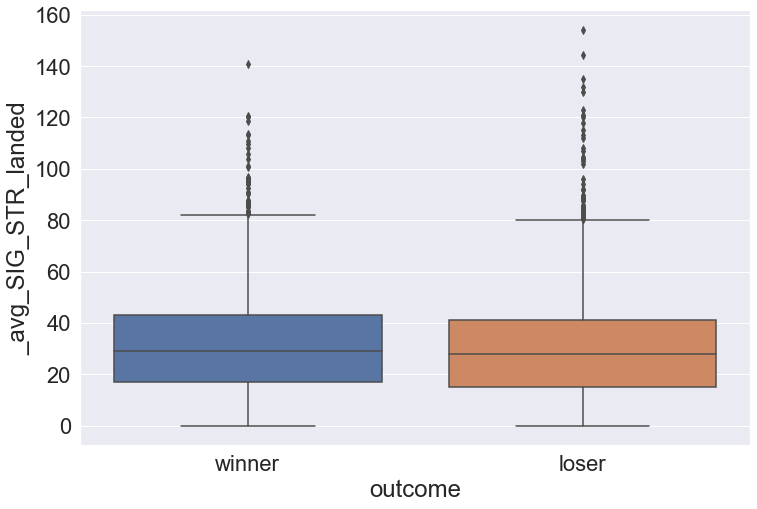

In [49]:
sns.boxplot(x='outcome', y='_avg_SIG_STR_landed', data=winners_losers)

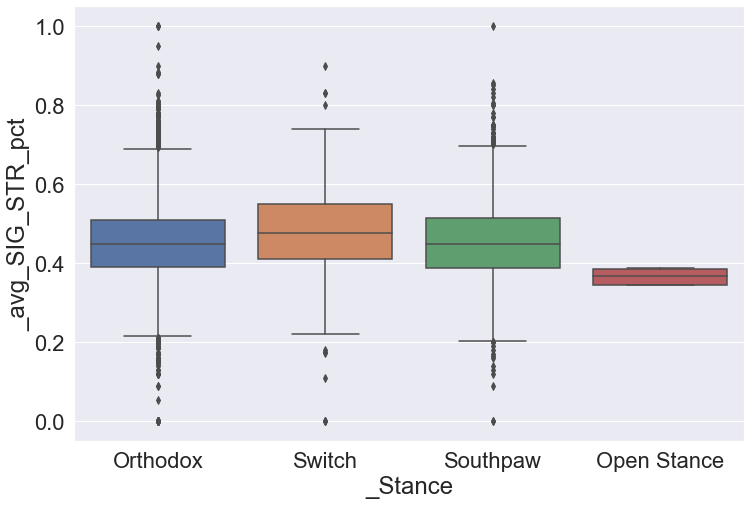

In [50]:
sns.boxplot(x='_Stance', y='_avg_SIG_STR_pct', data=winners_losers)

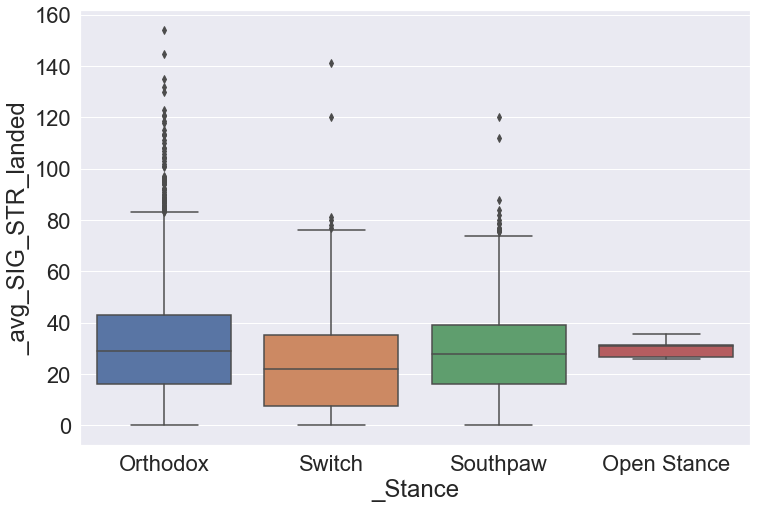

In [51]:
sns.boxplot(x='_Stance', y='_avg_SIG_STR_landed', data=winners_losers)

In [52]:
len(winners_losers[winners_losers['_avg_SIG_STR_landed']>5])

5733

In [53]:
winners_losers.shape

(6622, 24)

In [54]:
df['sig_str_dif'].describe()

count    3311.000000
mean       -0.409808
std        21.789045
min      -104.666667
25%       -12.333333
50%        -0.630000
75%        10.666667
max       128.222222
Name: sig_str_dif, dtype: float64

Ok, something is going on with these numbers. Signficant strikes per minute in the UFC are generally exceptional if they were anywhere near a value of 10, but there are tons of numbers here that show they are way outside this range. Even the differences between fighters are massive, indicating it's not just the _avg_sig_str_landed column (which represents the strikes/min metric for both colors) which is wacky, but the difference metric is probably a feature created from the 2 original columns.

A possible and likely explanation is the massive amount of outliers present. For all of the unique fighters in the dataset, they at one point had their first fight in the organization. If there first fight ended in under a minute or saw massive, quick beatdowns, their average significant strikes per minute in their next fight will be very large.

The other explanation is that these numbers are incosistent and not the same metrics when they were pulled from the original online data source, with some entries being strikes/min and other being total strikes landed and when the data was scraped an error was made. Let's see if these numbers start inflating at a certain date in the dataset.

In [55]:
df['sig_str_dif'][:50].describe()

count    50.000000
mean      0.010800
std       3.434695
min      -5.290000
25%      -1.695000
50%      -0.020000
75%       0.992500
max      17.680000
Name: sig_str_dif, dtype: float64

In [56]:
print(pd.DataFrame(df.loc[23,:]).loc['sig_str_dif'])
pd.DataFrame(df.loc[23,:])

23    1.97
Name: sig_str_dif, dtype: object


23
R_fighter                              Brendan Allen
B_fighter                            Sean Strickland
R_odds                                          -118
B_odds                                          -106
R_ev                                         84.7458
B_ev                                         94.3396
date                                      11/14/2020
location                      Las Vegas, Nevada, USA
country                                          USA
Winner                                          Blue
title_bout                                     False
weight_class                            Catch Weight
gender                                          MALE
no_of_rounds                                       3
B_current_lose_streak                              0
B_current_win_streak                               2
B_draw                                             0
B_avg_SIG_STR_landed                            4.64
B_avg_SIG_STR_pct                               0.36
B_avg_SUB_ATT                                    0.4
B_avg_TD_landed                                 1.22
B_avg_TD_pct                                    0.57
B_longest_win_streak                               3
B_losses                                           3
B_total_rounds_fought                             28
B_total_title_bouts                                0
B_win_by_Decision_Majority                         0
B_win_by_Decision_Split                            2
B_win_by_Decision_Unanimous                        3
B_win_by_KO/TKO                                    2
B_win_by_Submission                                1
B_win_by_TKO_Doctor_Stoppage                       0
B_wins                                             8
B_Stance                                    Orthodox
B_Height_cms                                  185.42
B_Reach_cms                                   193.04
B_Weight_lbs                                     185
R_current_lose_streak                              0
R_current_win_streak                               4
R_draw                                             0
R_avg_SIG_STR_landed                            2.67
R_avg_SIG_STR_pct                                0.6
R_avg_SUB_ATT                                    2.4
R_avg_TD_landed                                 1.42
R_avg_TD_pct                                    0.37
R_longest_win_streak                               4
R_losses                                           0
R_total_rounds_fought                              7
R_total_title_bouts                                0
R_win_by_Decision_Majority                         0
R_win_by_Decision_Split                            0
R_win_by_Decision_Unanimous                        1
R_win_by_KO/TKO                                    1
R_win_by_Submission                                2
R_win_by_TKO_Doctor_Stoppage                       0
R_wins                                             4
R_Stance                                    Orthodox
R_Height_cms                                  187.96
R_Reach_cms                                    190.5
R_Weight_lbs                                     185
R_age                                             24
B_age                                             29
lose_streak_dif                                    0
win_streak_dif                                    -2
longest_win_streak_dif                            -1
win_dif                                            4
loss_dif                                           3
total_round_dif                                   21
total_title_bout_dif                               0
ko_dif                                             1
sub_dif                                           -1
height_dif                                     -2.54
reach_dif                                       2.54
age_dif                                            5
sig_str_dif                                     1.97
avg_sub_att_dif       

The above example shows a signficiant striking difference of 17.68 per minute, which is absurdly good. I watched the fight where this took place, and I just checked the stats from the previous fight (https://www.google.com/search?client=firefox-b-1-d&q=khaos+williams+vs+alex+morono#tsp=opn, click on the box google displays). Khaos landed 10 strikes in the about 35 seconds that the fight lasted. This was his first fight in the UFC, which means that the fight outputted above would give his sig strike difference of over 17. Let's see what percentage of fighters had an average strikes landed per minute over 20 heading into a fight.

In [57]:
len(winners_losers[winners_losers['_avg_SIG_STR_landed'] > 20]) / len(winners_losers)

0.6784959226819692

Well, this is absurd. Almost nobody has 20 signficiant strikes per minute outside of the first few fights where an anomalic occurence of a super fast knockout happens. This means there must be a time period in the data where the metric was changed from average strikes landed per fight to average strikes landed per minute. Let's find out.

In [58]:
print('Number of fighters with more than 20 avg sig strikes:  ' ,
      len(df[(df['R_avg_SIG_STR_landed']>20) | (df['B_avg_SIG_STR_landed']>20)]))
df[(df['R_avg_SIG_STR_landed']>20) | (df['B_avg_SIG_STR_landed']>20)] \
[0:20][['R_fighter','B_fighter','R_avg_SIG_STR_landed', 'B_avg_SIG_STR_landed', 'sig_str_dif']]


Number of fighters with more than 20 avg sig strikes:   2708


R_fighter          B_fighter  R_avg_SIG_STR_landed  \
21    Abdul Razak Alhassan     Khaos Williams              4.540000   
136           Gavin Tucker      Justin Jaynes              2.660000   
465           Henry Cejudo      Marlon Moraes             44.000000   
466   Valentina Shevchenko        Jessica Eye             59.428571   
467          Tony Ferguson     Donald Cerrone             55.466667   
468          Jimmie Rivera           Petr Yan             45.750000   
469            Tai Tuivasa      Blagoy Ivanov             32.500000   
470         Tatiana Suarez      Nina Ansaroff             42.750000   
471      Aljamain Sterling       Pedro Munhoz             52.250000   
472  Karolina Kowalkiewicz       Alexa Grasso             73.555556   
473          Ricardo Lamas      Calvin Kattar             32.266667   
474            Yan Xiaonan        Angela Hill            105.666667   
475            Bevon Lewis     Darren Stewart             68.000000   
476      Katlyn Chookagian  Joanne Calderwood             61.166667   
477   Alexander Gustafsson      Anthony Smith             44.200000   
478            Jimi Manuwa   Aleksandar Rakic             26.090909   
480         Damir Hadzovic    Christos Giagos             34.800000   
481          Tonya Evinger      Lina Lansberg             20.500000   
482             Stevie Ray    Leonardo Santos             40.222222   
483              Nick Hein      Frank Camacho             34.142857   

     B_avg_SIG_STR_landed  sig_str_dif  
21              22.220000    17.680000  
136             23.410000    20.750000  
465             22.600000   -21.400000  
466             51.300000    -8.128571  
467             46.774194    -8.692473  
468             70.250000    24.500000  
469             61.500000    29.000000  
470             75.166667    32.416667  
471             41.500000   -10.750000  
472             53.750000   -19.805556  
473             56.250000    23.983333  
474             74.300000   -31.366667  
475             24.142857   -43.857143  
476             61.375000     0.208333  
477             33.181818   -11.018182  
478             60.333333    34.242424  
480             19.800000   -15.000000  
481             43.600000    23.100000  
482             25.166667   -15.055556  
483             95.000000    60.857143

In [59]:
len(df)

3311

I remember when Justin Jaynes finished Frank Camacho in under a minute in his UFC debut. His second fight, shown above against Gavin Tucker, has his striking average extremely high because of this outlier fight. However, it seems that UFC 238 with the main event Cejudo vs Moraes was the last event that has the striking averages as per fight, and after this event they switched to avg landed per minute. I am going to double check this.

In [60]:
df[['R_fighter','B_fighter','R_avg_SIG_STR_landed', 'B_avg_SIG_STR_landed', 'sig_str_dif', 'B_avg_SIG_STR_pct','B_avg_SUB_ATT', 'B_avg_TD_landed', 'B_avg_TD_pct']][455:475]

R_fighter           B_fighter  R_avg_SIG_STR_landed  \
455             Deron Winn      Darren Stewart              6.600000   
456           Charles Rosa      Manny Bermudez              3.790000   
457            Randy Costa       Boston Salmon              8.050000   
458            Court McGee          Sean Brady              4.860000   
459        Muslim Salikhov  Laureano Staropoli              2.920000   
460           Randa Markos        Ashley Yoder              3.010000   
461             Alex White       Rafael Fiziev              3.760000   
462        Enrique Barzola       Movsar Evloev              3.930000   
463         Maurice Greene    Sergei Pavlovich              4.190000   
464   Raphael Pessoa Nunes         Jeff Hughes              2.400000   
465           Henry Cejudo       Marlon Moraes             44.000000   
466   Valentina Shevchenko         Jessica Eye             59.428571   
467          Tony Ferguson      Donald Cerrone             55.466667   
468          Jimmie Rivera            Petr Yan             45.750000   
469            Tai Tuivasa       Blagoy Ivanov             32.500000   
470         Tatiana Suarez       Nina Ansaroff             42.750000   
471      Aljamain Sterling        Pedro Munhoz             52.250000   
472  Karolina Kowalkiewicz        Alexa Grasso             73.555556   
473          Ricardo Lamas       Calvin Kattar             32.266667   
474            Yan Xiaonan         Angela Hill            105.666667   

     B_avg_SIG_STR_landed  sig_str_dif  B_avg_SIG_STR_pct  B_avg_SUB_ATT  \
455              2.940000    -3.660000           0.440000       0.000000   
456              2.920000    -0.870000           0.610000       3.100000   
457              4.130000    -3.920000           0.370000       0.000000   
458              7.930000     3.070000           0.560000       0.000000   
459              4.290000     1.370000           0.310000       0.000000   
460              3.100000     0.090000           0.420000       0.500000   
461              4.080000     0.320000           0.500000       0.000000   
462              4.030000     0.100000           0.380000       0.000000   
463              6.550000     2.360000           0.520000       0.000000   
464              4.340000     1.940000           0.510000       0.000000   
465             22.600000   -21.400000           0.466000       0.400000   
466             51.300000    -8.128571           0.399000       0.700000   
467             46.774194    -8.692473           0.496129       0.354839   
468             70.250000    24.500000           0.550000       0.250000   
469             61.500000    29.000000           0.310000       0.000000   
470             75.166667    32.416667           0.470000       0.666667   
471             41.500000   -10.750000           0.499167       0.666667   
472             53.750000   -19.805556           0.502500       0.250000   
473             56.250000    23.983333           0.420000       0.000000   
474             74.300000   -31.366667           0.480000       0.000000   

     B_avg_TD_landed  B_avg_TD_pct  
455         1.380000      0.440000  
456         3.060000      0.540000  
457         0.000000      0.000000  
458         2.000000      0.660000  
459         0.330000      0.250000  
460         1.330000      0.380000  
461         0.910000      1.000000  
462         4.500000      0.330000  
463         0.000000      0.000000  
464         0.780000      0.500000  
465         0.200000      0.100000  
466         0.500000      0.225000  
467         0.677419      0.295484  
468         1.250000      0.287500  
469         0.000000      0.000000  
470         0.333333      0.250000  
471         0.583333      0.233333  
472         0.250000      0.125000  
473         0.500000      0.165000  
474         0.300000      0.250000

In [61]:
df[['R_fighter','B_fighter','R_avg_SIG_STR_landed', 'B_avg_SIG_STR_landed', 'sig_str_dif', 'B_avg_SIG_STR_pct','B_avg_SUB_ATT', 'B_avg_TD_landed', 'B_avg_TD_pct']][750:760]

R_fighter       B_fighter  R_avg_SIG_STR_landed  \
750  Aljamain Sterling    Cody Stamann             49.300000   
751         Geoff Neal   Frank Camacho             14.000000   
752       Charles Byrd  Darren Stewart             11.000000   
753      Diego Sanchez     Craig White             33.296296   
754         Jim Miller      Alex White             30.000000   
755       Irene Aldana  Lucie Pudilova             87.333333   
756    Roberto Sanchez   Jarred Brooks              2.000000   
757     Justin Gaethje      James Vick            113.666667   
758    Michael Johnson      Andre Fili             45.500000   
759      Cortney Casey     Angela Hill             53.375000   

     B_avg_SIG_STR_landed  sig_str_dif  B_avg_SIG_STR_pct  B_avg_SUB_ATT  \
750             85.000000    35.700000           0.513333       0.000000   
751            130.000000   116.000000           0.490000       0.000000   
752             22.200000    11.200000           0.470000       0.000000   
753              6.000000   -27.296296           0.350000       0.000000   
754             46.000000    16.000000           0.430000       0.142857   
755             75.666667   -11.666667           0.446667       0.666667   
756             29.333333    27.333333           0.446667       0.333333   
757             38.500000   -75.166667           0.332000       0.500000   
758             42.200000    -3.300000           0.356000       0.100000   
759             71.857143    18.482143           0.498571       0.000000   

     B_avg_TD_landed  B_avg_TD_pct  
750         4.000000      0.486667  
751         2.000000      0.600000  
752         1.200000      0.272000  
753         0.000000      0.000000  
754         0.714286      0.250000  
755         0.000000      0.000000  
756         4.666667      0.550000  
757         0.200000      0.100000  
758         2.100000      0.503000  
759         0.285714      0.214286

I believe I now understand the issues. UFC 238 Cejudo vs Moraes was the last event that recorded the average striking metric as total per fight. When I do pre-processing and feature engineering I will have to decide what course of action to take.

Let's move on to grappling (submissions and takedowns).

In [62]:
winners_losers.columns

Index(['_current_lose_streak', '_current_win_streak', '_draw',
       '_avg_SIG_STR_landed', '_avg_SIG_STR_pct', '_avg_SUB_ATT',
       '_avg_TD_landed', '_avg_TD_pct', '_longest_win_streak', '_losses',
       '_total_rounds_fought', '_total_title_bouts',
       '_win_by_Decision_Majority', '_win_by_Decision_Split',
       '_win_by_Decision_Unanimous', '_win_by_KO/TKO', '_win_by_Submission',
       '_win_by_TKO_Doctor_Stoppage', '_wins', '_Height_cms', '_Reach_cms',
       '_Weight_lbs', '_Stance', 'outcome'],
      dtype='object')

#### submission attempts and submission wins

In [63]:
winners_losers._avg_SUB_ATT.describe()

count     6622.0
unique     303.0
top          0.0
freq      2157.0
Name: _avg_SUB_ATT, dtype: float64

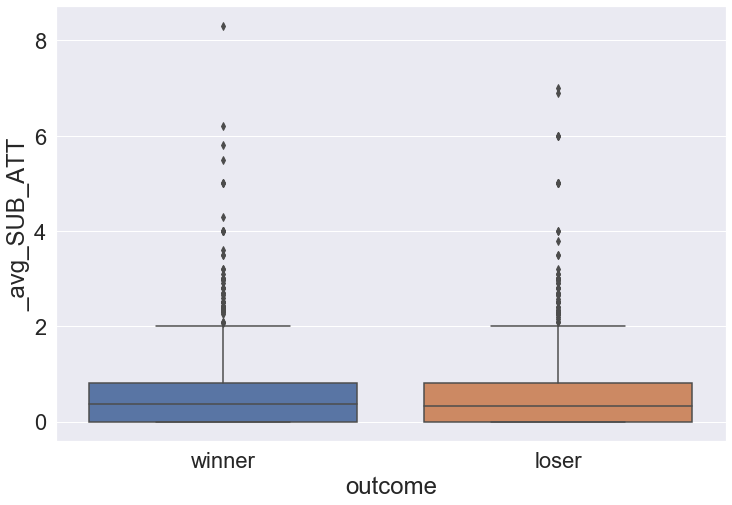

In [64]:
# sub attempts
sns.boxplot(x='outcome', y='_avg_SUB_ATT', data=winners_losers)

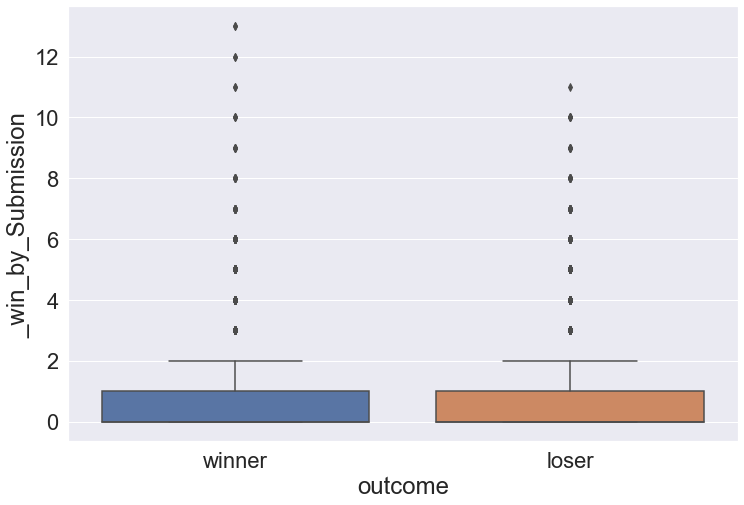

In [65]:
# sub wins
sns.boxplot(x='outcome', y='_win_by_Submission', data=winners_losers)

Looks like the outliers aren't revealing much info. Let's filter them out.

In [66]:
sub_filter = winners_losers[['outcome', '_avg_SUB_ATT','_win_by_Submission']][(winners_losers['_avg_SUB_ATT'] <3) &
                                                                              (winners_losers['_win_by_Submission']<3)]

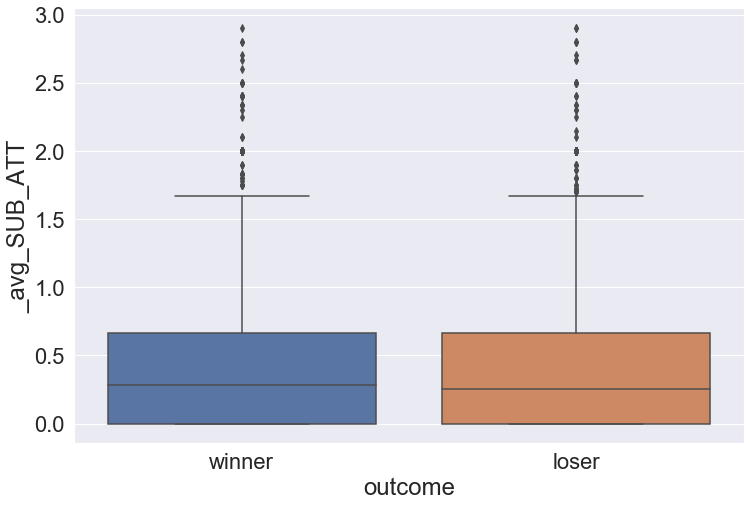

In [67]:
sns.boxplot(x='outcome', y='_avg_SUB_ATT', data=sub_filter)

Looking at submissions vs submission attempts including outliers now.

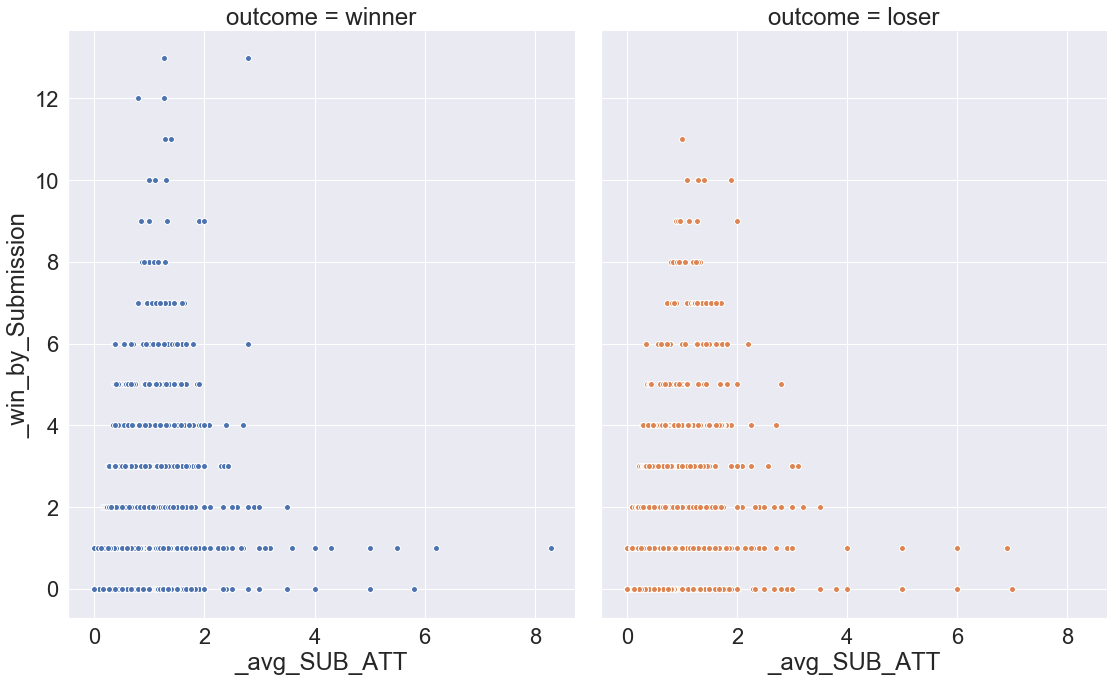

In [68]:
sns.set(font_scale=2.0)
grid = sns.FacetGrid(winners_losers,col='outcome', hue='outcome', height=10, aspect=0.8)
(grid.map(plt.scatter,'_avg_SUB_ATT','_win_by_Submission', edgecolor='w'))

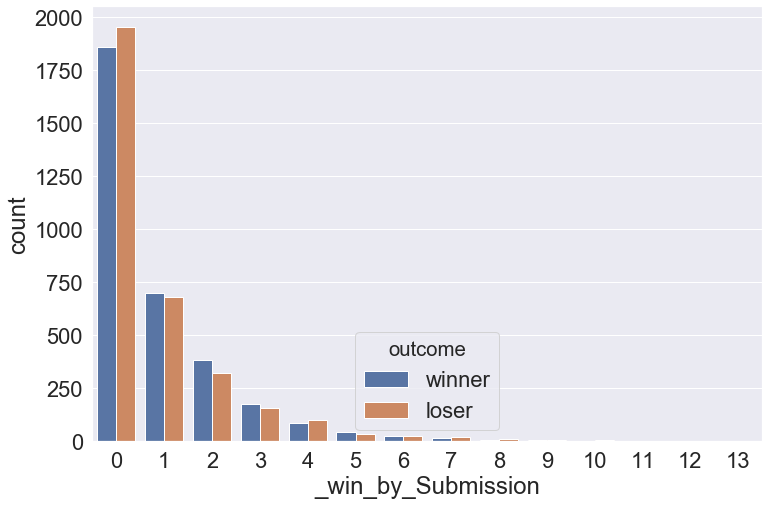

In [69]:
sns.countplot(x='_win_by_Submission',data=winners_losers, hue='outcome')

Even as a brazilian jiujitsu practicioner myself I have received insight that is obvious in hindsight: the fighters who have a lot of submission wins don't need a lot of attempts to get their wins.

#### Takedowns:
A quick discussion on takedowns in the sport of MMA. Takedowns are an extremley important part of MMA. Taking an opponent to the ground is critical, especially for fighters who have a grappling heavy style, or those that excel in a technique called 'ground and pound'; striking your opponent while they are no longer standing and are on the mat (ground). Also, they tend to score heavy with judges, and this is realized recently in the sport with many veterans going for a takedown in the last 30 seconds or so of a round to try to gain that round on the judges' scorecards.

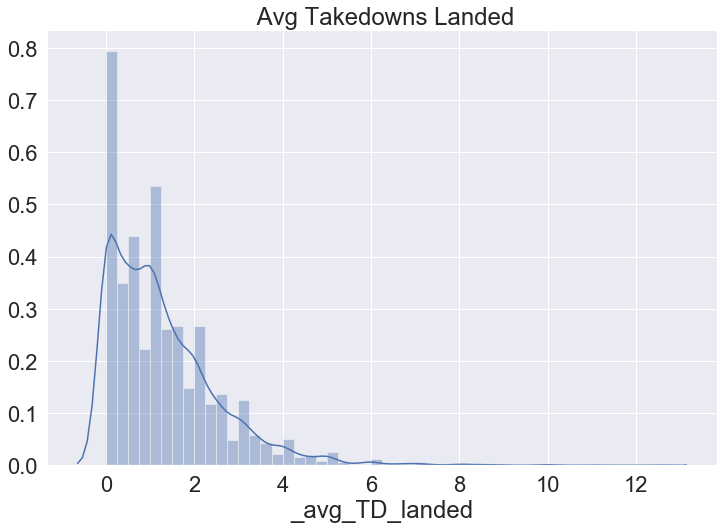

In [70]:
# takedowns landed
sns.distplot(winners_losers['_avg_TD_landed'])
plt.title(' Avg Takedowns Landed');

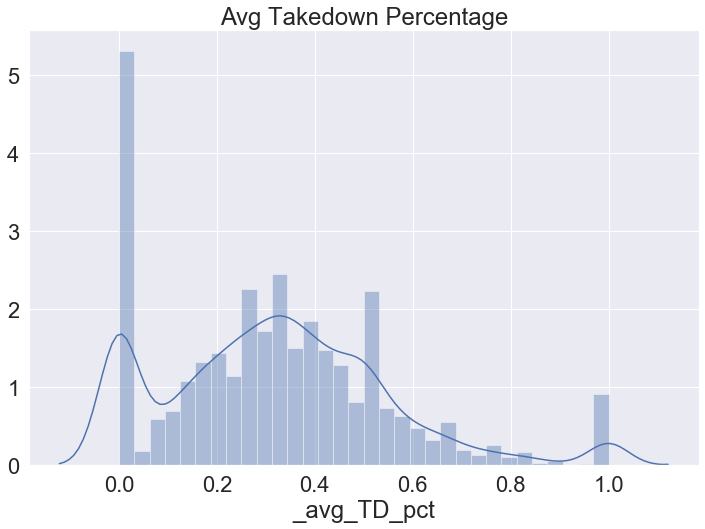

In [71]:
# takedown percentage
sns.distplot(winners_losers['_avg_TD_pct'])
plt.title('Avg Takedown Percentage');

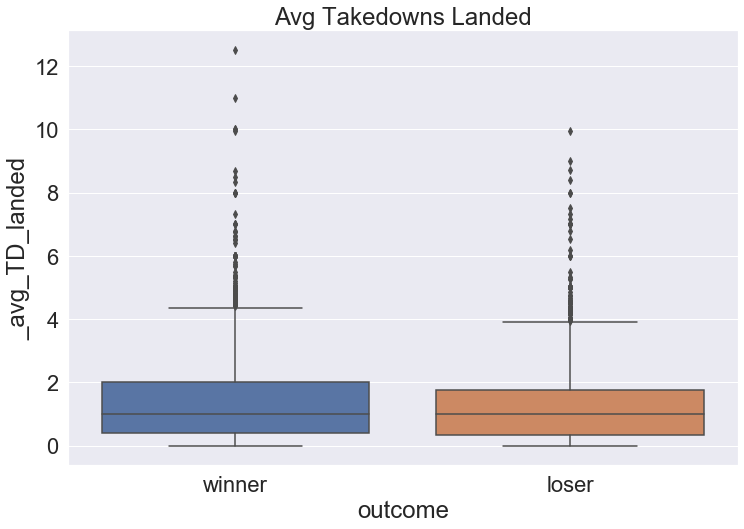

In [72]:
# takedowns landed
sns.boxplot(x='outcome', y='_avg_TD_landed', data=winners_losers)
plt.title('Avg Takedowns Landed');

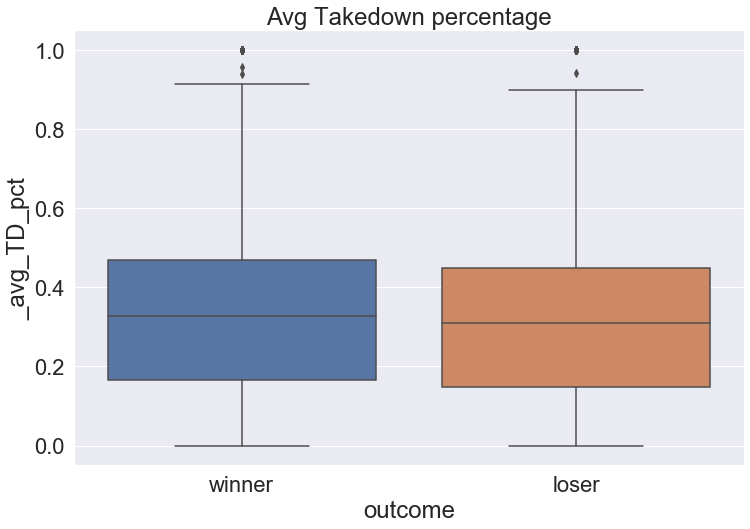

In [73]:
# takedown percentage 
sns.boxplot(x='outcome', y='_avg_TD_pct', data=winners_losers)
plt.title('Avg Takedown percentage');

Like the previous fighter metrics, there doesn't seem to be large differences between the metrics for winners and losers. Let's take a look at the fighters' historical win loss records, and number of knockouts/ finishes.

In [74]:
winners_losers.columns

Index(['_current_lose_streak', '_current_win_streak', '_draw',
       '_avg_SIG_STR_landed', '_avg_SIG_STR_pct', '_avg_SUB_ATT',
       '_avg_TD_landed', '_avg_TD_pct', '_longest_win_streak', '_losses',
       '_total_rounds_fought', '_total_title_bouts',
       '_win_by_Decision_Majority', '_win_by_Decision_Split',
       '_win_by_Decision_Unanimous', '_win_by_KO/TKO', '_win_by_Submission',
       '_win_by_TKO_Doctor_Stoppage', '_wins', '_Height_cms', '_Reach_cms',
       '_Weight_lbs', '_Stance', 'outcome'],
      dtype='object')

#### win by KO/TKO/DoctorStoppage,Decision 

In [75]:
# TKO_Doctor_Stoppage likely has very few entries that aren't 0
winners_losers['_win_by_TKO_Doctor_Stoppage'].value_counts()

0    6299
1     302
2      21
Name: _win_by_TKO_Doctor_Stoppage, dtype: int64

In [76]:
# making column that combines decision wins
winners_losers['_win_by_Decision'] = winners_losers['_win_by_Decision_Majority'] + \
winners_losers['_win_by_Decision_Split'] + winners_losers['_win_by_Decision_Unanimous']

# adding doctor stoppage to TKO/KO
winners_losers['_win_by_KO/TKO'] = winners_losers['_win_by_KO/TKO'] + winners_losers['_win_by_TKO_Doctor_Stoppage']

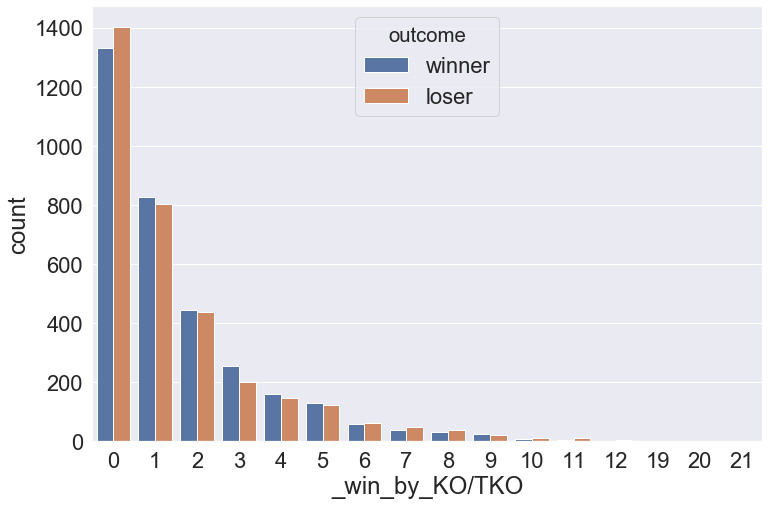

In [77]:
sns.countplot('_win_by_KO/TKO', data=winners_losers, hue='outcome')

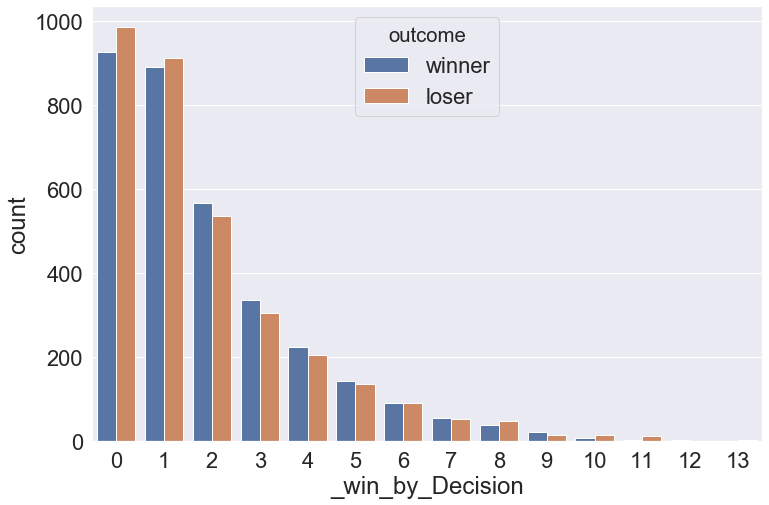

In [78]:
sns.countplot('_win_by_Decision', data=winners_losers, hue='outcome')

#### Let's create a column for the percentage of wins that are finishes (KO/TKO/Submission/DoctorStoppage

In [79]:
# column for total number of finishes
winners_losers['_finishes'] = winners_losers['_win_by_KO/TKO'] + winners_losers['_win_by_Submission']
# column for percentage of wins that are finishes
winners_losers['_finish_rate'] = winners_losers['_wins']
# need to use lambda expression with logic to avoid dicision by 0
winners_losers['_finish_rate'] = winners_losers[['_finish_rate','_finishes']] \
.apply(lambda x: x['_finish_rate'] if x['_finish_rate']==0 else x['_finishes'] / x['_finish_rate'], axis=1)

In [80]:
winners_losers[['_finish_rate','_wins','_finishes']]

_finish_rate _wins _finishes
0         0.900000    10         9
1         0.666667     3         2
2         0.000000     0         0
3         0.000000     0         0
4         0.000000     0         0
...            ...   ...       ...
6617      0.750000     4         3
6618      1.000000     2         2
6619      0.333333     3         1
6620      0.000000     0         0
6621      1.000000     3         3

[6622 rows x 3 columns]

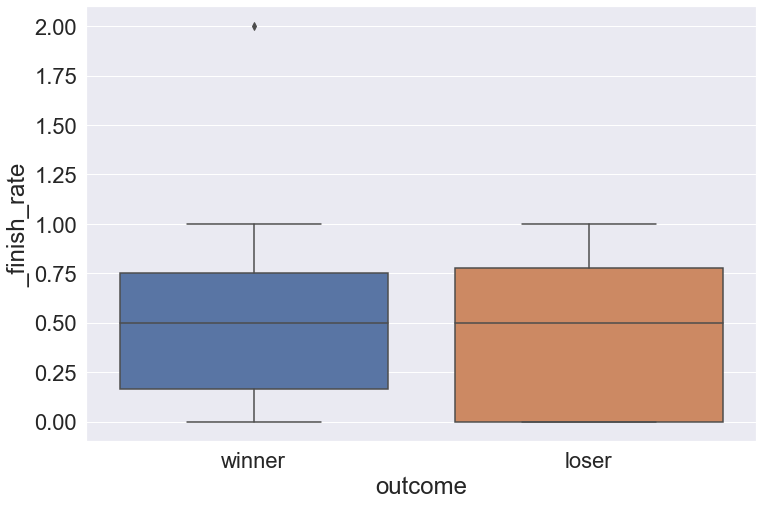

In [81]:
# visualizing
sns.boxplot(x='outcome', y='_finish_rate', data=winners_losers)

### I want to now compare this finish rate feature against win percentage, which is a column I will need to make

In [82]:
# meed logic for the scenario where a fighter has no wins, losses, and draws (sum is 0) because they're only fight(s)
# ended in disqualification
winners_losers['_win_percentage'] = winners_losers[['_wins','_losses','_draw']] \
.apply(lambda row: row['_wins'] / np.sum(row) if np.sum(row) > 0 else 0, axis=1)

In [83]:
winners_losers.iloc[500,]

_current_lose_streak                  1
_current_win_streak                   0
_draw                                 0
_avg_SIG_STR_landed             31.5556
_avg_SIG_STR_pct               0.465556
_avg_SUB_ATT                   0.666667
_avg_TD_landed                 0.888889
_avg_TD_pct                         0.4
_longest_win_streak                   4
_losses                               3
_total_rounds_fought                 22
_total_title_bouts                    1
_win_by_Decision_Majority             0
_win_by_Decision_Split                0
_win_by_Decision_Unanimous            2
_win_by_KO/TKO                        1
_win_by_Submission                    3
_win_by_TKO_Doctor_Stoppage           1
_wins                                 6
_Height_cms                      180.34
_Reach_cms                       182.88
_Weight_lbs                         170
_Stance                        Orthodox
outcome                          winner
_win_by_Decision                      2


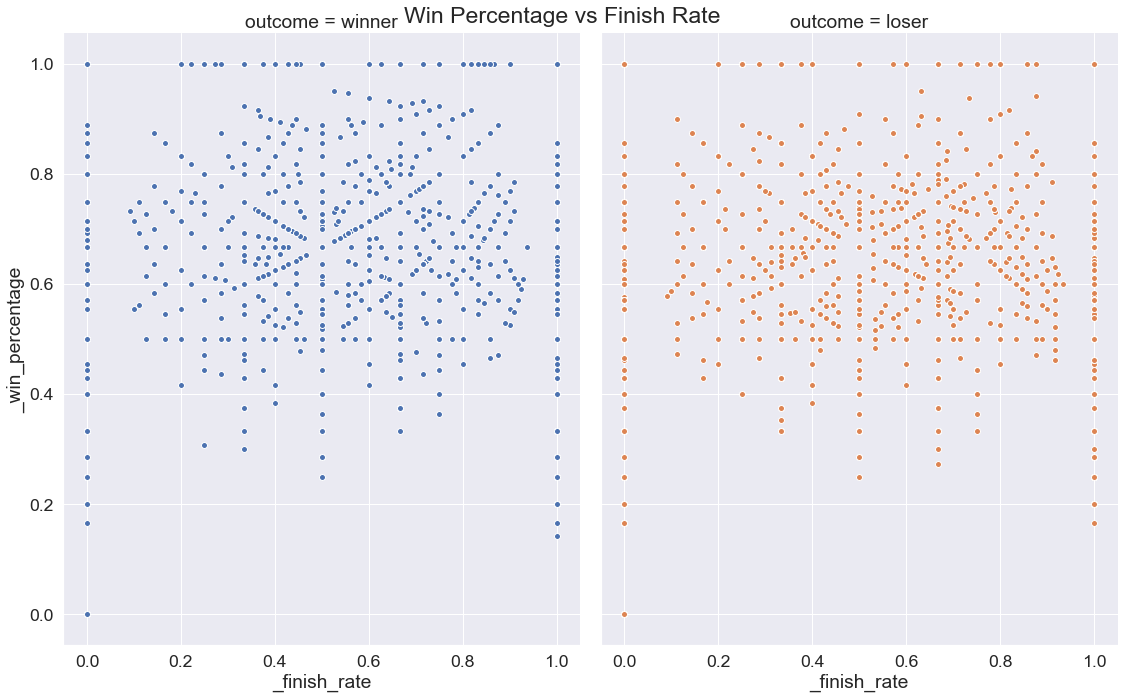

In [84]:
sns.set(font_scale=1.6)

grid = sns.FacetGrid(winners_losers,col='outcome', hue='outcome', height=10, aspect=0.8)
(grid.map(plt.scatter,'_finish_rate','_win_percentage', edgecolor='w'))
plt.xlim(-0.05, 1.05)
grid.fig.suptitle('Win Percentage vs Finish Rate');


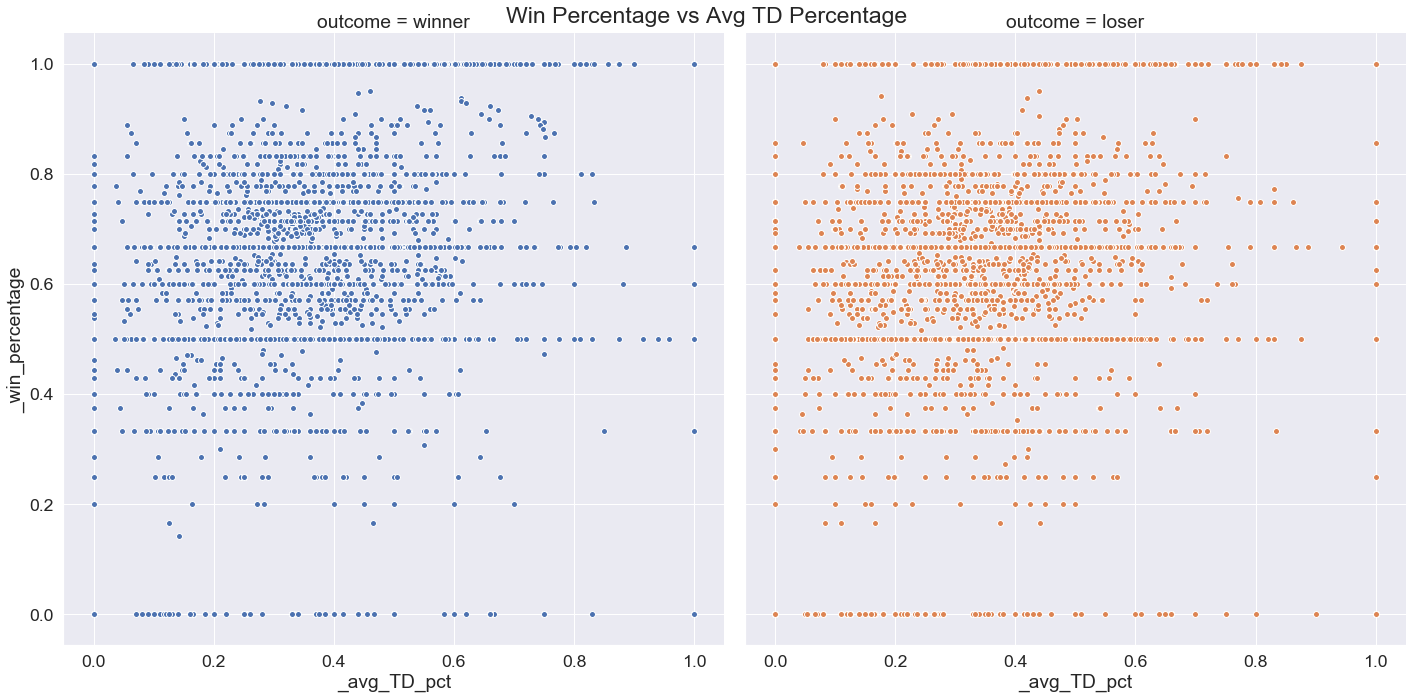

In [85]:
grid = sns.FacetGrid(winners_losers,col='outcome', hue='outcome', height=10, aspect=1.0)
(grid.map(plt.scatter,'_avg_TD_pct','_win_percentage', edgecolor='w'))
plt.xlim(-0.05, 1.05)
grid.fig.suptitle('Win Percentage vs Avg TD Percentage');

In [86]:
from scipy.stats.stats import pearsonr

In [87]:
print('Correlation between win percentage and avg TD percentage: ', 
      pearsonr(winners_losers['_win_percentage'].values, winners_losers['_avg_TD_pct'].values)[0])

Correlation between win percentage and avg TD percentage:  0.21608481383731407


The past few visualizations and findings still are not super impactful, but I see a bit of progress. Making temporary features in my expanded dataset (winners_losers) with each individual fighter's metrics before a fight reveals a bit more. Although there is a relatively weak correlation between win percentage and avg TD percentage, it is positive and the scatterplots show increasing win percentages with increasing TD percentage for both winners and losers of contests.


# Differences
Now I will explore the features for differences between fighters. The 'dif' columns are the blue fighter's stats minues the red fighter's stats. A dataframe for winners will be made to look at the differences in metrics for winners. Looking at winners vs losers would be uninformative as the losers will simply present the opposite number of winners.

In [88]:
df.columns

Index(['R_fighter', 'B_fighter', 'R_odds', 'B_odds', 'R_ev', 'B_ev', 'date',
       'location', 'country', 'Winner', 'title_bout', 'weight_class', 'gender',
       'no_of_rounds', 'B_current_lose_streak', 'B_current_win_streak',
       'B_draw', 'B_avg_SIG_STR_landed', 'B_avg_SIG_STR_pct', 'B_avg_SUB_ATT',
       'B_avg_TD_landed', 'B_avg_TD_pct', 'B_longest_win_streak', 'B_losses',
       'B_total_rounds_fought', 'B_total_title_bouts',
       'B_win_by_Decision_Majority', 'B_win_by_Decision_Split',
       'B_win_by_Decision_Unanimous', 'B_win_by_KO/TKO', 'B_win_by_Submission',
       'B_win_by_TKO_Doctor_Stoppage', 'B_wins', 'B_Stance', 'B_Height_cms',
       'B_Reach_cms', 'B_Weight_lbs', 'R_current_lose_streak',
       'R_current_win_streak', 'R_draw', 'R_avg_SIG_STR_landed',
       'R_avg_SIG_STR_pct', 'R_avg_SUB_ATT', 'R_avg_TD_landed', 'R_avg_TD_pct',
       'R_longest_win_streak', 'R_losses', 'R_total_rounds_fought',
       'R_total_title_bouts', 'R_win_by_Decision_Majority',
  

In [89]:
# start and end index of differnce columns
start_ind = df.columns.get_loc('lose_streak_dif')
end_ind = df.columns.get_loc('avg_td_dif')+1
# names of difference columns
dif_names = list(df.columns.values[start_ind: end_ind])
dif_names

['lose_streak_dif',
 'win_streak_dif',
 'longest_win_streak_dif',
 'win_dif',
 'loss_dif',
 'total_round_dif',
 'total_title_bout_dif',
 'ko_dif',
 'sub_dif',
 'height_dif',
 'reach_dif',
 'age_dif',
 'sig_str_dif',
 'avg_sub_att_dif',
 'avg_td_dif']

In [90]:
winners = pd.DataFrame(columns =['fighter', 'color'] + dif_names)
#losers = pd.DataFrame(columns = ['fighter', 'color'] + dif_names)


# check the winner in each row, and append the associated columns for that color to winners column, while the other
# colors column will be added to losers
for ind, row in df.iterrows():    
  
    if row['Winner'] == 'Blue':
        winners = winners.append(pd.Series([row['B_fighter'],'Blue'] + list(row[dif_names].values),
                                           index=winners.columns), ignore_index=True) 
        #losers = losers.append(pd.Series([row['R_fighter'],'Red'] + list(row[dif_names].values),
                                           #index=winners.columns), ignore_index=True) 
        
    else:
        winners = winners.append(pd.Series([row['R_fighter'],'Red'] + list(row[dif_names].values),
                                           index=winners.columns), ignore_index=True) 
        #losers = losers.append(pd.Series([row['B_fighter'],'Blue'] + list(row[dif_names].values),
                                           #index=winners.columns), ignore_index=True) 

In [91]:
# add outcome columns and then concat the 2 dataframes
winners['outcome'] = 'winner'
#losers['outcome'] = 'loser'
#winners_losers_dif = pd.concat([winners,losers], axis=0)

In [92]:
# reorder columns
winners = winners.reindex(['fighter','color','outcome']+list(winners.columns.values)[2:-1], axis=1)

In [93]:
winners.head()

fighter color outcome lose_streak_dif win_streak_dif  \
0  Anthony Smith   Red  winner              -2              2   
1   Miguel Baeza   Red  winner               0             -2   
2  Parker Porter  Blue  winner               1             -2   
3     Bill Algeo  Blue  winner               1              0   
4   Norma Dumont  Blue  winner               0              0   

  longest_win_streak_dif win_dif loss_dif total_round_dif  \
0                     -1      -4       -4             -21   
1                     -2      -1        1              -1   
2                     -2      -2        1              -1   
3                     -1      -1        1               2   
4                     -2      -3       -3             -16   

  total_title_bout_dif ko_dif sub_dif  height_dif  reach_dif age_dif  \
0                   -1     -6      -3      -10.16      -2.54      -2   
1                    0      0       0      -10.16      -2.54       2   
2                    0     -2       0      -10.16     -10.16       4   
3                    0     -1       0       10.16       5.08       4   
4                    0     -1       0       -2.54       0.00      -3   

   sig_str_dif  avg_sub_att_dif  avg_td_dif  
0         0.43             -0.6        2.35  
1        -0.84             -1.1        0.25  
2        -0.25             -1.7        1.22  
3         4.40              0.0       -2.24  
4        -3.44              0.0        2.97

In [94]:
winners.shape

(3311, 18)

I also want to change the dif values in this dataframe. As was mentioned before the values are blue fighter minus redfighter. For the red fighters, a negative metric isn't indicative of their actual difference. For example a red fighter's dif value of -2.54 on reach is actually a +2.54 reach difference for them. I need to multiply the dif value of red fighters by -1. I put a column for the fighters' color so this can easily be done.


In [95]:
winners.loc[winners['color']=='Red',list(winners.columns.values[3:])] *= -1

In [96]:
winners.head()

fighter color outcome lose_streak_dif win_streak_dif  \
0  Anthony Smith   Red  winner               2             -2   
1   Miguel Baeza   Red  winner               0              2   
2  Parker Porter  Blue  winner               1             -2   
3     Bill Algeo  Blue  winner               1              0   
4   Norma Dumont  Blue  winner               0              0   

  longest_win_streak_dif win_dif loss_dif total_round_dif  \
0                      1       4        4              21   
1                      2       1       -1               1   
2                     -2      -2        1              -1   
3                     -1      -1        1               2   
4                     -2      -3       -3             -16   

  total_title_bout_dif ko_dif sub_dif  height_dif  reach_dif age_dif  \
0                    1      6       3       10.16       2.54       2   
1                    0      0       0       10.16       2.54      -2   
2                    0     -2       0      -10.16     -10.16       4   
3                    0     -1       0       10.16       5.08       4   
4                    0     -1       0       -2.54       0.00      -3   

   sig_str_dif  avg_sub_att_dif  avg_td_dif  
0        -0.43              0.6       -2.35  
1         0.84              1.1       -0.25  
2        -0.25             -1.7        1.22  
3         4.40              0.0       -2.24  
4        -3.44              0.0        2.97

In [97]:
# changing to numeric type for better descriptive statistics
winners.iloc[:,3:] = winners.iloc[:,3:].apply(pd.to_numeric)


### total_round_dif


In [98]:
winners['total_round_dif'].describe()

count    3311.000000
mean       -0.204168
std        16.903190
min       -84.000000
25%        -8.000000
50%         0.000000
75%         8.000000
max        79.000000
Name: total_round_dif, dtype: float64

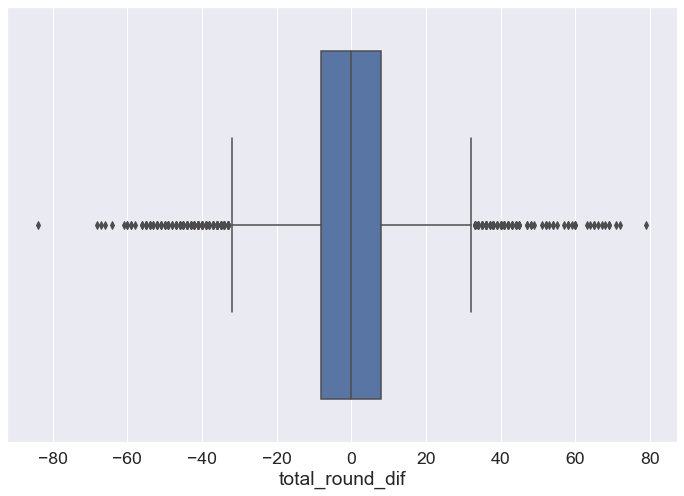

In [99]:
sns.boxplot(x='total_round_dif', data=winners)

Surprisingly, it doesn't seem that winners have a median difference in rounds they have competed in that is greater than 0.

### win streak difference

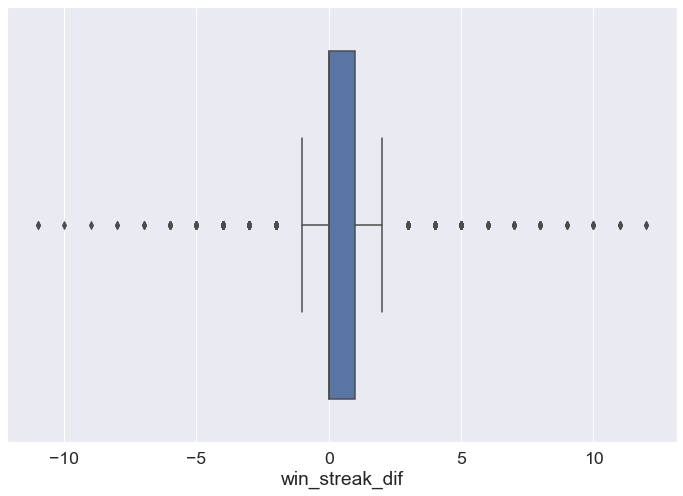

In [100]:
sns.boxplot(x='win_streak_dif', data=winners)

The boxplot shows that winning fighters had a median winstreak of 1 going into their fight.

### total wins difference

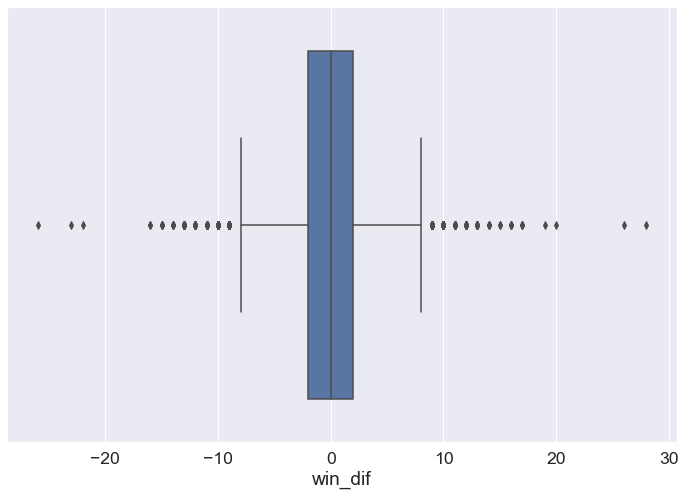

In [101]:
sns.boxplot(x='win_dif', data=winners)

### Ko difference

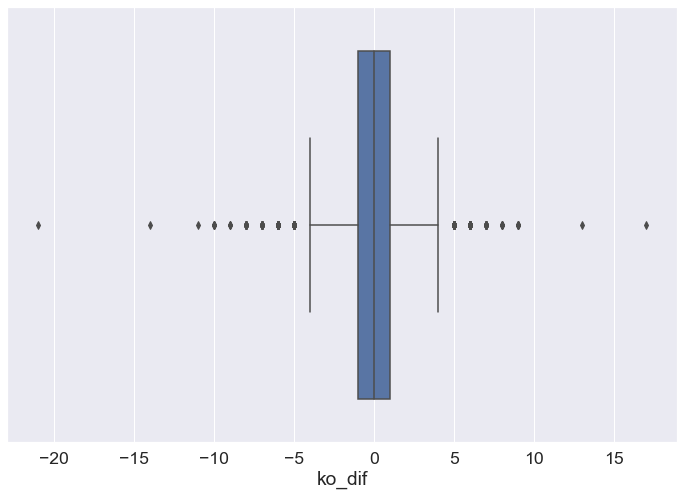

In [102]:
sns.boxplot(x='ko_dif', data=winners)

### submission difference

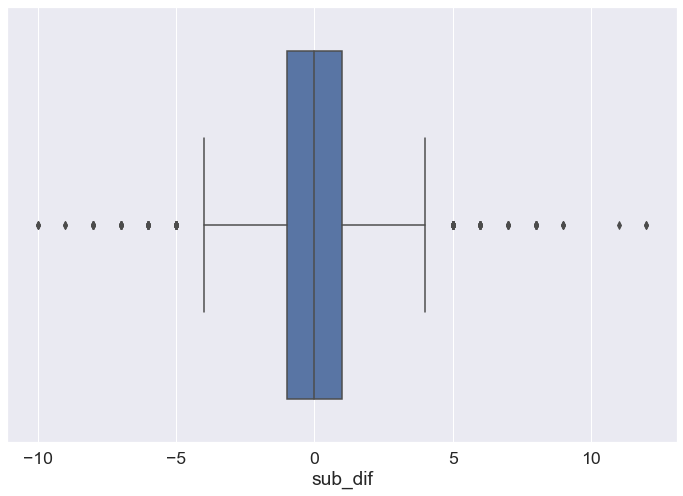

In [103]:
sns.boxplot(x='sub_dif', data=winners)

### average sub attempt difference

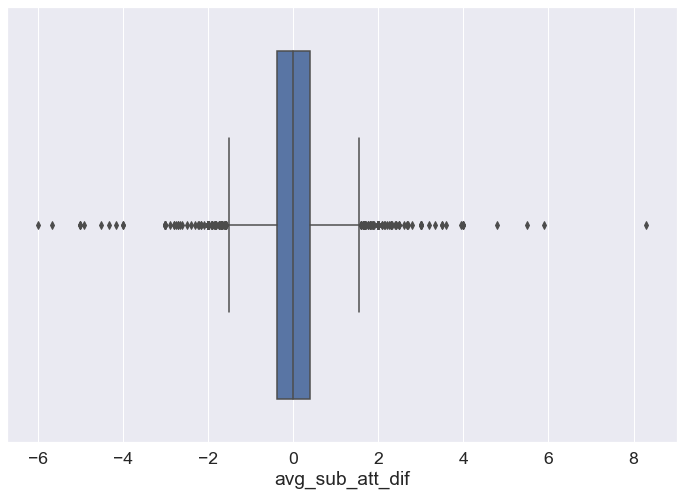

In [104]:
sns.boxplot(x='avg_sub_att_dif', data=winners)

### takedown difference

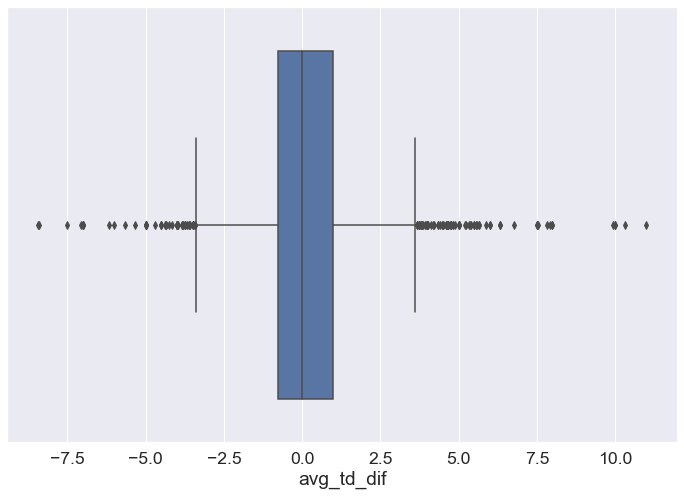

In [105]:
sns.boxplot(x='avg_td_dif', data=winners)

### Physical characteristics (age, height, reach)
### reach difference

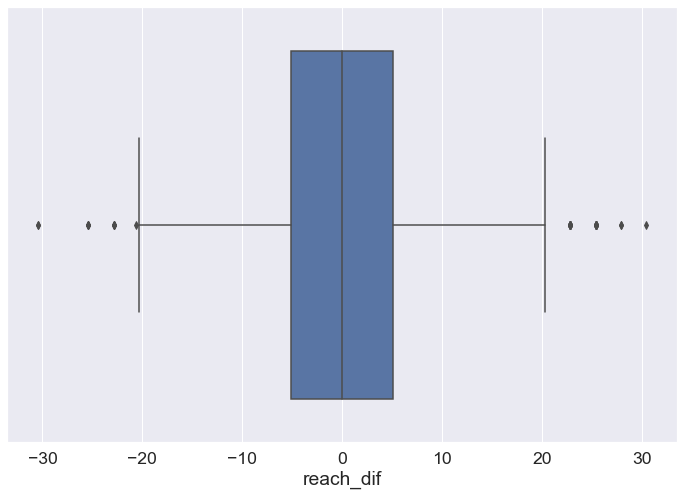

In [106]:
sns.boxplot(x='reach_dif', data=winners)

### age difference

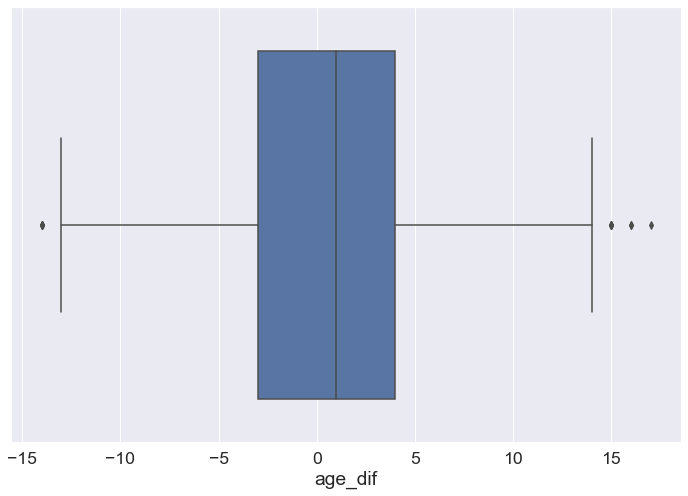

In [107]:
sns.boxplot(x='age_dif', data=winners)

Finally a signficiant finding. The winning fighters tended to be older and likely more experienced. This makes me wonder why the total rounds difference didn't show a higher level of difference since these metrics should be related. However, in more recent years the UFC has seen much more young fighters joining the organization and gaining experience at an earlier ages (as young as 20), despite not being in what analysts and experts of MMA consider the prime competing age(30-34).

### height difference

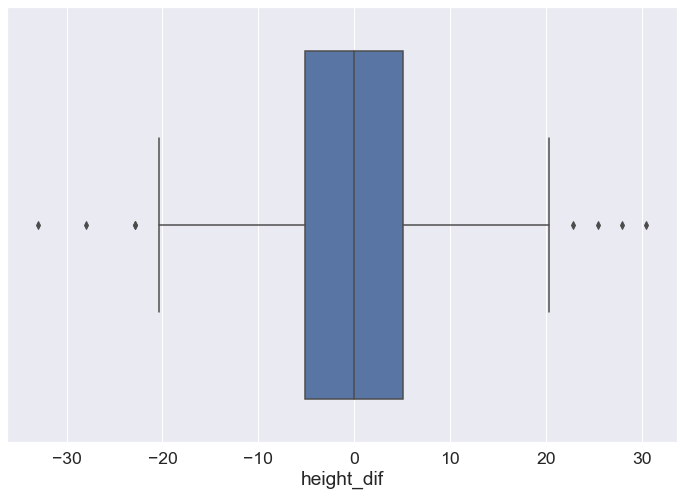

In [108]:
sns.boxplot(x='height_dif', data=winners)

### title bout difference

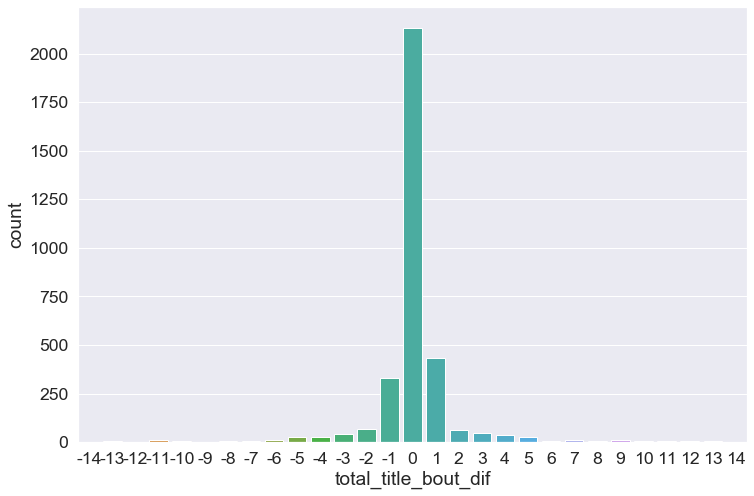

In [109]:
sns.countplot(x='total_title_bout_dif', data=winners)

# Summary of difference in metrics

Excluding age, these metric differences don't seem to show much of an indicator of winner. The raw metrics explored earlier were a bit more signficant. However, I still have valueable metrics that need to be feature engineered or fixed (like strikes landed). I think going into this next feature engineering stage with the dataset I will need to carefully choose which features are important. 

I also need to decide my approach to modeling this problem. Frameworks such as an ANN (artifical neural network) will create these differences features for me and weight them appropriately if they have value, and I can use feature selection with a logistic regression. I could also use random forests for feature selection. Overall, my approach is to not make too many features that overfit this dataset for my purpose of binary classification.

While I still might need to explore features I create moving forward, it is now appropriate to remove the features I fill will not be valueable or are absolutely useless, and begin to engineer the features I will need for different models.

# Feature engineering

Now I will create some features form exisiting ones, and remove ones that I feel hold no value. Feature selection will also be done with my models and techniques that are TBD such as elastic net, lasso, LARS, ridge etc.

In [110]:
# looking at original dataframe again

In [111]:
df.head()

R_fighter      B_fighter  R_odds  B_odds       R_ev   B_ev  \
0       Anthony Smith    Devin Clark    -139     115  71.942446  115.0   
1        Miguel Baeza   Takashi Sato    -175     140  57.142857  140.0   
2       Josh Parisian  Parker Porter    -200     160  50.000000  160.0   
3       Spike Carlyle     Bill Algeo    -177     140  56.497175  140.0   
4  Ashlee Evans-Smith   Norma Dumont    -137     110  72.992701  110.0   

         date                location country Winner  title_bout  \
0  11/28/2020  Las Vegas, Nevada, USA     USA    Red       False   
1  11/28/2020  Las Vegas, Nevada, USA     USA    Red       False   
2  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   
3  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   
4  11/28/2020  Las Vegas, Nevada, USA     USA   Blue       False   

           weight_class  gender  no_of_rounds  B_current_lose_streak  \
0     Light Heavyweight    MALE             5                      0   
1          Welterweight    MALE             3                      0   
2           Heavyweight    MALE             3                      1   
3         Featherweight    MALE             3                      2   
4  Women's Bantamweight  FEMALE             3                      1   

   B_current_win_streak  B_draw  B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  \
0                     2       0                  3.40               0.57   
1                     1       0                  3.94               0.41   
2                     0       0                  6.82               0.43   
3                     0       0                  7.87               0.53   
4                     0       0                  1.42               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  \
0         4                     24                    0   
1         1                      6                    0   
2         1                      1                    0   
3         2                      6                    0   
4         1                      1                    0   

   B_win_by_Decision_Majority  B_win_by_Decision_Split  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
0                            6                0                    0   
1                            0                2                    0   
2                            0                0                    0   
3                            0                0                    0   
4                            0                0                    0   

   B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                             0       6  Orthodox        182.88       190.50   
1                             0       2  Southpaw        177.80       185.42   
2                             0       0  Orthodox        182.88       190.50   
3                             0       0    Switch        182.88       185.42   
4                             0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  R_draw  \
0           205                      2                     0       0   
1           170                      0                     3       

There are many columns I can drop. I will keep fighter names for now to check my features I create. Location and country are not useful in prediciton and can be removed. Date is also not useful but I will keep it along with fighter names to join from the original dataset if need be. Title bout is a feature with so few cases (only for championship fights) that I do not see the value in keeping it (and it is a title bout for both fighters). Weight class  of the bout is also for both fighters, and should be removed, as well as gender and number of rounds. I want to remove the columns for odds and evaluation (B_ev, R_ev). These odds and evaluations are generated by other experts of the sport and reflect a likelihood of victory. I am attempting to create my own accurate model, not use the information and models that others have created. The empty arena indicator and constant 1 column can be removed. 

In [112]:
df = df.drop(['R_odds','B_odds', 'R_ev', 'B_ev', 'location', 'country'] + list(df.columns.values[10:df.columns.get_loc('no_of_rounds')+1]) + ['empty_arena', 'constant_1'], axis=1)

In [113]:
df.head()

R_fighter      B_fighter        date Winner  \
0       Anthony Smith    Devin Clark  11/28/2020    Red   
1        Miguel Baeza   Takashi Sato  11/28/2020    Red   
2       Josh Parisian  Parker Porter  11/28/2020   Blue   
3       Spike Carlyle     Bill Algeo  11/28/2020   Blue   
4  Ashlee Evans-Smith   Norma Dumont  11/28/2020   Blue   

   B_current_lose_streak  B_current_win_streak  B_draw  B_avg_SIG_STR_landed  \
0                      0                     2       0                  3.40   
1                      0                     1       0                  3.94   
2                      1                     0       0                  6.82   
3                      2                     0       0                  7.87   
4                      1                     0       0                  1.42   

   B_avg_SIG_STR_pct  B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  \
0               0.57            0.1             2.76          0.36   
1               0.41            0.0             0.79          0.50   
2               0.43            1.2             1.22          1.00   
3               0.53            0.0             0.50          0.33   
4               0.31            0.0             4.27          0.33   

   B_longest_win_streak  B_losses  B_total_rounds_fought  B_total_title_bouts  \
0                     2         4                     24                    0   
1                     1         1                      6                    0   
2                     0         1                      1                    0   
3                     0         2                      6                    0   
4                     0         1                      1                    0   

   B_win_by_Decision_Majority  B_win_by_Decision_Split  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
0                            6                0                    0   
1                            0                2                    0   
2                            0                0                    0   
3                            0                0                    0   
4                            0                0                    0   

   B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                             0       6  Orthodox        182.88       190.50   
1                             0       2  Southpaw        177.80       185.42   
2                             0       0  Orthodox        182.88       190.50   
3                             0       0    Switch        182.88       185.42   
4                             0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  R_draw  \
0           205                      2                     0       0   
1           170                      0                     3       0   
2           265                      0                     2       0   
3           145                      1                     0       0   
4           135                      1                     0       0   

   R_avg_SIG_STR_landed  R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_landed  \
0                  2.97               0.46            0.7             0.41   
1                  4.78               0.56            1.1             0.54   
2                  7.07               0.55            2.9             0.00   
3                  3.47               0.60            0.0             2.74   
4                  4.86               0.35            0.0             1.30   

   R_avg_TD_pct  R_longest_win_streak  R_losses  R_total_rounds_fought  \
0          0.25              

Also removing any rows where a fighter has no wins, losses, or draws.

In [114]:
df = df[~(((df['R_wins']==0)& (df['R_losses']==0) & (df['R_draw']==0)) | \
   ((df['B_wins']==0) & (df['B_losses']==0) & (df['B_draw']==0)))]

#### Fixing signficant striking column
It was shown in my EDA section that the signficant strikes landed column is faulty. 

In [115]:
df.loc[460:475,['R_fighter', 'B_fighter', 'R_avg_SIG_STR_landed','B_avg_SIG_STR_landed']]

R_fighter         B_fighter  R_avg_SIG_STR_landed  \
460           Randa Markos      Ashley Yoder              3.010000   
461             Alex White     Rafael Fiziev              3.760000   
462        Enrique Barzola     Movsar Evloev              3.930000   
463         Maurice Greene  Sergei Pavlovich              4.190000   
464   Raphael Pessoa Nunes       Jeff Hughes              2.400000   
465           Henry Cejudo     Marlon Moraes             44.000000   
466   Valentina Shevchenko       Jessica Eye             59.428571   
467          Tony Ferguson    Donald Cerrone             55.466667   
468          Jimmie Rivera          Petr Yan             45.750000   
469            Tai Tuivasa     Blagoy Ivanov             32.500000   
470         Tatiana Suarez     Nina Ansaroff             42.750000   
471      Aljamain Sterling      Pedro Munhoz             52.250000   
472  Karolina Kowalkiewicz      Alexa Grasso             73.555556   
473          Ricardo Lamas     Calvin Kattar             32.266667   
474            Yan Xiaonan       Angela Hill            105.666667   
475            Bevon Lewis    Darren Stewart             68.000000   

     B_avg_SIG_STR_landed  
460              3.100000  
461              4.080000  
462              4.030000  
463              6.550000  
464              4.340000  
465             22.600000  
466             51.300000  
467             46.774194  
468             70.250000  
469             61.500000  
470             75.166667  
471             41.500000  
472             53.750000  
473             56.250000  
474             74.300000  
475             24.142857

I have four options for this column. First: Convert the rows that are strikes landed per minute to strikes landed per fight. 2: convert the rows with fights landed per fight to strikes landed per minute. The downside of this is that I do not have the average number of minutes each fighter competes in per fight. 3: Create a new metric such as strikes landed per round. 4: do not use the column at all

I am considering using strikes landed per minute as a metric. Strikes landed per fight is going to heavily favor the fighters that are in longer fights, which doesn't necessarily mean they are winning more. A fighter can be losing a bunch of decisions and land a lot of strikes but still lose, where a dominant fighter might only need 30 strikes in 1 round to get the job done.

My strikes landed per minute conversion for the rows with the per fight metric is going to be an estimate. We have the number of rounds each fighter competed in, where each round is 5 minutes. However, unless a fighter has never been finished (knockout, submission, or doctor stoppage) and never finished an opponent, the 5 minutes per round assumption is not accurate. To compensate for this, a will calculate the fight time of a fighter in a new column. The calculation for fight time will be $FT = 5*numrounds - 3*finishes$
A fighter's fight time is 5 minutes per each round they have competed in, however each finish will subtract 3 minutes from the total.

### Decision:
After careful consideration I have decided to remove the strikes landed column. There are too many assumptions and estimates to be made for converting a subset of the rows to mimic the format of the remaining columns in order to have a uniform striking metric. I simply do not have enough information in the dataset to create an accurate column for this metric. I will remove this column, and the column for the striking difference between fighters as well.

In [116]:
df2 = df.copy()

In [117]:
df = df.drop(['R_avg_SIG_STR_landed', 'B_avg_SIG_STR_landed', 'sig_str_dif'], axis=1)

#### Handling the rankings column

The column for each fighter's rank is very important. In theory, a fighter with a higher rank than the other is expected to win the fight, so the difference in ranking between the fighters is crucial to predicting a winner. I can either make a categorical indicator of which fighter is ranked higher or if there isnt a ranking difference (if the contest is between two unranked fighters), or assign the variables a difference in based on ranking and assign my own ranking values for unranked fighters and champions.

I think a numerical column for ranks is an approach that will give my models better information. As mentioned before the ranking system in the UFC for each weight class is unranked fighters, ranks 15-1 (with one being the highest ranked figher), and a champion.

My scheme is going to be reversing the rankings for fighters. The champion will have a ranking value of 21 points (rank=0 in the dataset), the top ranked fighter (rank=1) will have a value of 18, rank=2 will be assigned 16 etc. and unranked fighters a value of 0. The columns are changed below. This scheme is chosen to account for the large performance gap between champions and challengers, as well as ranked fighters that are fighting unranked fighters.

In [118]:
# arrays or original ranks and the values they will be replaced with
orig_rank = np.concatenate((np.arange(1,16), np.array([0,np.nan])))
replace_rank = np.concatenate((np.flip(np.arange(4,19)), np.array([21.0,1.0])))


In [119]:
print('original rank:      ',orig_rank)
print('replacement rank:   ',replace_rank)

original rank:       [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.  0. nan]
replacement rank:    [18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4. 21.  1.]


In [120]:
# dictionary with keys being original and values being replacement
rank_replace_dict = dict(zip(orig_rank, replace_rank))

In [121]:
# creating new columns for these new ranking values
df['R_weightclass_rank_value'] = df['R_match_weightclass_rank'].replace(rank_replace_dict)
df['B_weightclass_rank_value'] = df['B_match_weightclass_rank'].replace(rank_replace_dict)

In [122]:
#dropping old columns
df = df.drop(['R_match_weightclass_rank', 'B_match_weightclass_rank'], axis=1)

In [123]:
df.head()

R_fighter      B_fighter        date Winner  \
0       Anthony Smith    Devin Clark  11/28/2020    Red   
1        Miguel Baeza   Takashi Sato  11/28/2020    Red   
2       Josh Parisian  Parker Porter  11/28/2020   Blue   
3       Spike Carlyle     Bill Algeo  11/28/2020   Blue   
4  Ashlee Evans-Smith   Norma Dumont  11/28/2020   Blue   

   B_current_lose_streak  B_current_win_streak  B_draw  B_avg_SIG_STR_pct  \
0                      0                     2       0               0.57   
1                      0                     1       0               0.41   
2                      1                     0       0               0.43   
3                      2                     0       0               0.53   
4                      1                     0       0               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  \
0         4                     24                    0   
1         1                      6                    0   
2         1                      1                    0   
3         2                      6                    0   
4         1                      1                    0   

   B_win_by_Decision_Majority  B_win_by_Decision_Split  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
0                            6                0                    0   
1                            0                2                    0   
2                            0                0                    0   
3                            0                0                    0   
4                            0                0                    0   

   B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                             0       6  Orthodox        182.88       190.50   
1                             0       2  Southpaw        177.80       185.42   
2                             0       0  Orthodox        182.88       190.50   
3                             0       0    Switch        182.88       185.42   
4                             0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  R_draw  \
0           205                      2                     0       0   
1           170                      0                     3       0   
2           265                      0                     2       0   
3           145                      1                     0       0   
4           135                      1                     0       0   

   R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_landed  R_avg_TD_pct  \
0               0.46            0.7             0.41          0.25   
1               0.56            1.1             0.54          0.33   
2               0.55            2.9             0.00          0.00   
3               0.60            0.0             2.74          0.50   
4               0.35            0.0             1.30          0.25   

   R_longest_win_streak  R_losses  R_total_rounds_fought  R_total_title_bouts  \
0                     3         8                     45                    1   
1                     3         0                      7                    0   
2                     2         0       

#### Draws

In [124]:
df['B_draw'].value_counts()

0    3283
1      24
2       2
Name: B_draw, dtype: int64

In [125]:
df['R_draw'].value_counts()

0    3285
1      22
2       2
Name: R_draw, dtype: int64

There are only 50 instances of a fighter that has a at least one draw competing in the dataset. I think this column should be removed, however, I first will need it to create a column for the number of fights that each fighter has competed in (num_fights).

In [126]:
df['R_num_fights'] = df['R_wins'] + df['R_losses'] + df['R_draw']
df['B_num_fights'] = df['B_wins'] + df['B_losses'] + df['B_draw']

In [127]:
df.head()

R_fighter      B_fighter        date Winner  \
0       Anthony Smith    Devin Clark  11/28/2020    Red   
1        Miguel Baeza   Takashi Sato  11/28/2020    Red   
2       Josh Parisian  Parker Porter  11/28/2020   Blue   
3       Spike Carlyle     Bill Algeo  11/28/2020   Blue   
4  Ashlee Evans-Smith   Norma Dumont  11/28/2020   Blue   

   B_current_lose_streak  B_current_win_streak  B_draw  B_avg_SIG_STR_pct  \
0                      0                     2       0               0.57   
1                      0                     1       0               0.41   
2                      1                     0       0               0.43   
3                      2                     0       0               0.53   
4                      1                     0       0               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  \
0         4                     24                    0   
1         1                      6                    0   
2         1                      1                    0   
3         2                      6                    0   
4         1                      1                    0   

   B_win_by_Decision_Majority  B_win_by_Decision_Split  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
0                            6                0                    0   
1                            0                2                    0   
2                            0                0                    0   
3                            0                0                    0   
4                            0                0                    0   

   B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                             0       6  Orthodox        182.88       190.50   
1                             0       2  Southpaw        177.80       185.42   
2                             0       0  Orthodox        182.88       190.50   
3                             0       0    Switch        182.88       185.42   
4                             0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  R_draw  \
0           205                      2                     0       0   
1           170                      0                     3       0   
2           265                      0                     2       0   
3           145                      1                     0       0   
4           135                      1                     0       0   

   R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_landed  R_avg_TD_pct  \
0               0.46            0.7             0.41          0.25   
1               0.56            1.1             0.54          0.33   
2               0.55            2.9             0.00          0.00   
3               0.60            0.0             2.74          0.50   
4               0.35            0.0             1.30          0.25   

   R_longest_win_streak  R_losses  R_total_rounds_fought  R_total_title_bouts  \
0                     3         8                     45                    1   
1                     3         0                      7                    0   
2                     2         0       

In [128]:
df = df.drop(['R_draw','B_draw'], axis=1)

#### Decision victories
I will combine the decision win columns into 1 column as I did during my EDA to reduce my model complexities.

In [129]:
df['R_win_by_Decision'] = df['R_win_by_Decision_Majority'] + df['R_win_by_Decision_Split'] + df['R_win_by_Decision_Unanimous']
df['B_win_by_Decision'] = df['B_win_by_Decision_Majority'] + df['B_win_by_Decision_Split'] + df['B_win_by_Decision_Unanimous']

In [130]:
df = df.drop(['R_win_by_Decision_Majority', 'R_win_by_Decision_Split', 'R_win_by_Decision_Unanimous',
             'B_win_by_Decision_Majority', 'B_win_by_Decision_Split', 'B_win_by_Decision_Unanimous'], axis=1)

In [131]:
df.head()

R_fighter      B_fighter        date Winner  \
0       Anthony Smith    Devin Clark  11/28/2020    Red   
1        Miguel Baeza   Takashi Sato  11/28/2020    Red   
2       Josh Parisian  Parker Porter  11/28/2020   Blue   
3       Spike Carlyle     Bill Algeo  11/28/2020   Blue   
4  Ashlee Evans-Smith   Norma Dumont  11/28/2020   Blue   

   B_current_lose_streak  B_current_win_streak  B_avg_SIG_STR_pct  \
0                      0                     2               0.57   
1                      0                     1               0.41   
2                      1                     0               0.43   
3                      2                     0               0.53   
4                      1                     0               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  B_win_by_KO/TKO  \
0         4                     24                    0                0   
1         1                      6                    0                2   
2         1                      1                    0                0   
3         2                      6                    0                0   
4         1                      1                    0                0   

   B_win_by_Submission  B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  \
0                    0                             0       6  Orthodox   
1                    0                             0       2  Southpaw   
2                    0                             0       0  Orthodox   
3                    0                             0       0    Switch   
4                    0                             0       0  Orthodox   

   B_Height_cms  B_Reach_cms  B_Weight_lbs  R_current_lose_streak  \
0        182.88       190.50           205                      2   
1        177.80       185.42           170                      0   
2        182.88       190.50           265                      0   
3        182.88       185.42           145                      1   
4        170.18       170.18           135                      1   

   R_current_win_streak  R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_landed  \
0                     0               0.46            0.7             0.41   
1                     3               0.56            1.1             0.54   
2                     2               0.55            2.9             0.00   
3                     0               0.60            0.0             2.74   
4                     0               0.35            0.0             1.30   

   R_avg_TD_pct  R_longest_win_streak  R_losses  R_total_rounds_fought  \
0          0.25                     3         8                     45   
1          0.33                     3         0                      7   
2          0.00                     2         0                      2   
3          0.50                     1         1                      4   
4          0.25                     2         4                     17   

   R_total_title_bouts  R_win_by_KO/TKO  R_win_by_Submission  \
0                    1                6                    3   
1                    0                2                    0   
2                    0                2                    0   
3                    0                1                    0   
4                    0                1                    0   

   R_win_by_TKO_Doctor_Stoppage  R_wins  R_Stance  R_Height_cms  R_Reach_cms  \
0                             0      10  Orthodox        193.04       193.04   
1                          

### Wins/Losses
While there is great value in showing the number of wins a fighter has, I think using losses can be a bit tricky. A fighter with a record of 20-2 obviously has the same number of losses as a fighter with a record of 0-2. The same does go for wins, since a 5-0 fighter has the same number of wins as an 5-18 fighter, yet these records clearly tell different stories. Since the experience of fighters is already shown in the number of fights they have and the number of rounds they have participated in, I don't think the raw win/loss values will be as informative for models as a win percentage. I think keeping these columns but also using a win percentage will aid my models. This win percentage feature is created below.

In [132]:
df['R_win_percentage'] = df['R_wins'] / df['R_num_fights']
df['B_win_percentage'] = df['B_wins'] / df['B_num_fights']

In [133]:
df.head()

R_fighter      B_fighter        date Winner  \
0       Anthony Smith    Devin Clark  11/28/2020    Red   
1        Miguel Baeza   Takashi Sato  11/28/2020    Red   
2       Josh Parisian  Parker Porter  11/28/2020   Blue   
3       Spike Carlyle     Bill Algeo  11/28/2020   Blue   
4  Ashlee Evans-Smith   Norma Dumont  11/28/2020   Blue   

   B_current_lose_streak  B_current_win_streak  B_avg_SIG_STR_pct  \
0                      0                     2               0.57   
1                      0                     1               0.41   
2                      1                     0               0.43   
3                      2                     0               0.53   
4                      1                     0               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  B_win_by_KO/TKO  \
0         4                     24                    0                0   
1         1                      6                    0                2   
2         1                      1                    0                0   
3         2                      6                    0                0   
4         1                      1                    0                0   

   B_win_by_Submission  B_win_by_TKO_Doctor_Stoppage  B_wins  B_Stance  \
0                    0                             0       6  Orthodox   
1                    0                             0       2  Southpaw   
2                    0                             0       0  Orthodox   
3                    0                             0       0    Switch   
4                    0                             0       0  Orthodox   

   B_Height_cms  B_Reach_cms  B_Weight_lbs  R_current_lose_streak  \
0        182.88       190.50           205                      2   
1        177.80       185.42           170                      0   
2        182.88       190.50           265                      0   
3        182.88       185.42           145                      1   
4        170.18       170.18           135                      1   

   R_current_win_streak  R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_landed  \
0                     0               0.46            0.7             0.41   
1                     3               0.56            1.1             0.54   
2                     2               0.55            2.9             0.00   
3                     0               0.60            0.0             2.74   
4                     0               0.35            0.0             1.30   

   R_avg_TD_pct  R_longest_win_streak  R_losses  R_total_rounds_fought  \
0          0.25                     3         8                     45   
1          0.33                     3         0                      7   
2          0.00                     2         0                      2   
3          0.50                     1         1                      4   
4          0.25                     2         4                     17   

   R_total_title_bouts  R_win_by_KO/TKO  R_win_by_Submission  \
0                    1                6                    3   
1                    0                2                    0   
2                    0                2                    0   
3                    0                1                    0   
4                    0                1                    0   

   R_win_by_TKO_Doctor_Stoppage  R_wins  R_Stance  R_Height_cms  R_Reach_cms  \
0                             0      10  Orthodox        193.04       193.04   
1                          

### Win by TKO Doctor Stoppage

In [134]:
df['R_win_by_TKO_Doctor_Stoppage'].value_counts()

0    3120
1     174
2      15
Name: R_win_by_TKO_Doctor_Stoppage, dtype: int64

In [135]:
df['B_win_by_TKO_Doctor_Stoppage'].value_counts()

0    3175
1     128
2       6
Name: B_win_by_TKO_Doctor_Stoppage, dtype: int64

Doctor stoppages are an uncommon yet not rare occurence in the sport of MMA. They are officially a win for the fighter who inflicted enough damage to cause a doctor stoppage, or are the result of an accidental injury for the fighter who got stopped by the doctor. In my experience watching the sport, there are enough of these stoppages that are stopped due to damage inflicted on the loser (cuts opened by elbows, massive swelling due to impact from strikes, torn ligaments from kicks to the leg etc.) that this column shouldn't be dropped, but there are few enough cases that they should be combined with the KO/TKO column.

In [136]:
df['R_win_by_KO/TKO'] = df['R_win_by_KO/TKO'] + df['R_win_by_TKO_Doctor_Stoppage'] 
df['B_win_by_KO/TKO'] = df['B_win_by_KO/TKO'] + df['B_win_by_TKO_Doctor_Stoppage']
df = df.drop(['R_win_by_TKO_Doctor_Stoppage', 'B_win_by_TKO_Doctor_Stoppage'], axis=1)

In [137]:
df.head()

R_fighter      B_fighter        date Winner  \
0       Anthony Smith    Devin Clark  11/28/2020    Red   
1        Miguel Baeza   Takashi Sato  11/28/2020    Red   
2       Josh Parisian  Parker Porter  11/28/2020   Blue   
3       Spike Carlyle     Bill Algeo  11/28/2020   Blue   
4  Ashlee Evans-Smith   Norma Dumont  11/28/2020   Blue   

   B_current_lose_streak  B_current_win_streak  B_avg_SIG_STR_pct  \
0                      0                     2               0.57   
1                      0                     1               0.41   
2                      1                     0               0.43   
3                      2                     0               0.53   
4                      1                     0               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  B_win_by_KO/TKO  \
0         4                     24                    0                0   
1         1                      6                    0                2   
2         1                      1                    0                0   
3         2                      6                    0                0   
4         1                      1                    0                0   

   B_win_by_Submission  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                    0       6  Orthodox        182.88       190.50   
1                    0       2  Southpaw        177.80       185.42   
2                    0       0  Orthodox        182.88       190.50   
3                    0       0    Switch        182.88       185.42   
4                    0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  \
0           205                      2                     0   
1           170                      0                     3   
2           265                      0                     2   
3           145                      1                     0   
4           135                      1                     0   

   R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_landed  R_avg_TD_pct  \
0               0.46            0.7             0.41          0.25   
1               0.56            1.1             0.54          0.33   
2               0.55            2.9             0.00          0.00   
3               0.60            0.0             2.74          0.50   
4               0.35            0.0             1.30          0.25   

   R_longest_win_streak  R_losses  R_total_rounds_fought  R_total_title_bouts  \
0                     3         8                     45                    1   
1                     3         0                      7                    0   
2                     2         0                      2                    0   
3                     1         1                      4                    0   
4                     2         4                     17                    0   

   R_win_by_KO/TKO  R_win_by_Submission  R_wins  R_Stance  R_Height_cms  \
0                6                    3      10  Orthodox        193.04   
1                2                    0       3  Orthodox        187.96   
2                2                    0       2  Orthodox        193.04   
3                1                    0       1    Switch        172.72   
4                1                    0       3  Orthodox        172.72   

   R_Reach_cms  R_Weight_lbs  R_age  B_age  lose_streak_dif  win_streak_dif  \
0       193.04           205     32     30               -2               2   
1       187.96   

### Finishes / Finish rate
Fighters that get many finishes (KO(knockout), TKO(technical knockout), submission, Doctor Stoppage) are usually more dominant than fighters, and there was a positive correlation between finish rate and win percentage in my EDA. A column for number of finishes and finish rate (number of finishes divided by number of fights) will be valueable.

In [138]:
df['R_finishes'] = df['R_win_by_Submission'] + df['R_win_by_KO/TKO']
df['B_finishes'] = df['B_win_by_Submission'] + df['B_win_by_Submission']
df['R_win_finish_rate'] = df[['R_finishes','R_wins']].apply(
    lambda row: 0 if row['R_wins']==0 else row['R_finishes']/row['R_wins'], axis=1)
df['B_win_finish_rate'] = df[['B_finishes','B_wins']].apply(
    lambda row: 0 if row['B_wins']==0 else row['B_finishes']/row['B_wins'], axis=1)

In [139]:
df.head()

R_fighter      B_fighter        date Winner  \
0       Anthony Smith    Devin Clark  11/28/2020    Red   
1        Miguel Baeza   Takashi Sato  11/28/2020    Red   
2       Josh Parisian  Parker Porter  11/28/2020   Blue   
3       Spike Carlyle     Bill Algeo  11/28/2020   Blue   
4  Ashlee Evans-Smith   Norma Dumont  11/28/2020   Blue   

   B_current_lose_streak  B_current_win_streak  B_avg_SIG_STR_pct  \
0                      0                     2               0.57   
1                      0                     1               0.41   
2                      1                     0               0.43   
3                      2                     0               0.53   
4                      1                     0               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  B_win_by_KO/TKO  \
0         4                     24                    0                0   
1         1                      6                    0                2   
2         1                      1                    0                0   
3         2                      6                    0                0   
4         1                      1                    0                0   

   B_win_by_Submission  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                    0       6  Orthodox        182.88       190.50   
1                    0       2  Southpaw        177.80       185.42   
2                    0       0  Orthodox        182.88       190.50   
3                    0       0    Switch        182.88       185.42   
4                    0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  \
0           205                      2                     0   
1           170                      0                     3   
2           265                      0                     2   
3           145                      1                     0   
4           135                      1                     0   

   R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_landed  R_avg_TD_pct  \
0               0.46            0.7             0.41          0.25   
1               0.56            1.1             0.54          0.33   
2               0.55            2.9             0.00          0.00   
3               0.60            0.0             2.74          0.50   
4               0.35            0.0             1.30          0.25   

   R_longest_win_streak  R_losses  R_total_rounds_fought  R_total_title_bouts  \
0                     3         8                     45                    1   
1                     3         0                      7                    0   
2                     2         0                      2                    0   
3                     1         1                      4                    0   
4                     2         4                     17                    0   

   R_win_by_KO/TKO  R_win_by_Submission  R_wins  R_Stance  R_Height_cms  \
0                6                    3      10  Orthodox        193.04   
1                2                    0       3  Orthodox        187.96   
2                2                    0       2  Orthodox        193.04   
3                1                    0       1    Switch        172.72   
4                1                    0       3  Orthodox        172.72   

   R_Reach_cms  R_Weight_lbs  R_age  B_age  lose_streak_dif  win_streak_dif  \
0       193.04           205     32     30               -2               2   
1       187.96   

### Dif columns
I believe that some of the columns for the difference between fighter metrics are not valueable from my EDA and intuition, but I do not want to remove any at this point as I believe they will be more important than individual metrics. Individual metrics might help create a ranking of fighters, but the difference between opponents is very important for a fight itself. I will keep my current difference columns, and create new difference features.

I will create difference features for win percentage, finish rate, number of finishes, takedown percentage, number of fights, and most importantly, the ranking difference. These will follow the methodology from the creator of the dataset where the differenes are Blue fighter minues Red fighter.

In [140]:
df['win_percentage_dif'] = df['B_win_percentage'] - df['R_win_percentage']
df['win_finish_rate_dif'] = df['B_win_finish_rate'] - df['R_win_finish_rate']
df['finishes_dif'] = df['B_finishes'] - df['R_finishes']
df['avg_TD_pct_dif'] = df['B_avg_TD_pct'] - df['R_avg_TD_pct']
df['num_fights_dif'] = df['B_num_fights'] - df['R_num_fights']
df['weightclass_rank_value_dif'] = df['B_weightclass_rank_value'] - df['R_weightclass_rank_value']

In [141]:
df.head()

R_fighter      B_fighter        date Winner  \
0       Anthony Smith    Devin Clark  11/28/2020    Red   
1        Miguel Baeza   Takashi Sato  11/28/2020    Red   
2       Josh Parisian  Parker Porter  11/28/2020   Blue   
3       Spike Carlyle     Bill Algeo  11/28/2020   Blue   
4  Ashlee Evans-Smith   Norma Dumont  11/28/2020   Blue   

   B_current_lose_streak  B_current_win_streak  B_avg_SIG_STR_pct  \
0                      0                     2               0.57   
1                      0                     1               0.41   
2                      1                     0               0.43   
3                      2                     0               0.53   
4                      1                     0               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  B_win_by_KO/TKO  \
0         4                     24                    0                0   
1         1                      6                    0                2   
2         1                      1                    0                0   
3         2                      6                    0                0   
4         1                      1                    0                0   

   B_win_by_Submission  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                    0       6  Orthodox        182.88       190.50   
1                    0       2  Southpaw        177.80       185.42   
2                    0       0  Orthodox        182.88       190.50   
3                    0       0    Switch        182.88       185.42   
4                    0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  \
0           205                      2                     0   
1           170                      0                     3   
2           265                      0                     2   
3           145                      1                     0   
4           135                      1                     0   

   R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_landed  R_avg_TD_pct  \
0               0.46            0.7             0.41          0.25   
1               0.56            1.1             0.54          0.33   
2               0.55            2.9             0.00          0.00   
3               0.60            0.0             2.74          0.50   
4               0.35            0.0             1.30          0.25   

   R_longest_win_streak  R_losses  R_total_rounds_fought  R_total_title_bouts  \
0                     3         8                     45                    1   
1                     3         0                      7                    0   
2                     2         0                      2                    0   
3                     1         1                      4                    0   
4                     2         4                     17                    0   

   R_win_by_KO/TKO  R_win_by_Submission  R_wins  R_Stance  R_Height_cms  \
0                6                    3      10  Orthodox        193.04   
1                2                    0       3  Orthodox        187.96   
2                2                    0       2  Orthodox        193.04   
3                1                    0       1    Switch        172.72   
4                1                    0       3  Orthodox        172.72   

   R_Reach_cms  R_Weight_lbs  R_age  B_age  lose_streak_dif  win_streak_dif  \
0       193.04           205     32     30               -2               2   
1       187.96   

### Stance variable
The categorical stance variable will need to be converted to dummy variables.

In [142]:
R_stance_dummies = pd.get_dummies(df['R_Stance'], drop_first=False, prefix='R')
B_stance_dummies = pd.get_dummies(df['B_Stance'], drop_first = False, prefix='B')

In [143]:
R_stance_dummies.head()

R_Open Stance  R_Orthodox  R_Southpaw  R_Switch
0              0           1           0         0
1              0           1           0         0
2              0           1           0         0
3              0           0           0         1
4              0           1           0         0

In [144]:
df = pd.concat([df,B_stance_dummies, R_stance_dummies], axis=1)

In [145]:
df.head()

R_fighter      B_fighter        date Winner  \
0       Anthony Smith    Devin Clark  11/28/2020    Red   
1        Miguel Baeza   Takashi Sato  11/28/2020    Red   
2       Josh Parisian  Parker Porter  11/28/2020   Blue   
3       Spike Carlyle     Bill Algeo  11/28/2020   Blue   
4  Ashlee Evans-Smith   Norma Dumont  11/28/2020   Blue   

   B_current_lose_streak  B_current_win_streak  B_avg_SIG_STR_pct  \
0                      0                     2               0.57   
1                      0                     1               0.41   
2                      1                     0               0.43   
3                      2                     0               0.53   
4                      1                     0               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  B_win_by_KO/TKO  \
0         4                     24                    0                0   
1         1                      6                    0                2   
2         1                      1                    0                0   
3         2                      6                    0                0   
4         1                      1                    0                0   

   B_win_by_Submission  B_wins  B_Stance  B_Height_cms  B_Reach_cms  \
0                    0       6  Orthodox        182.88       190.50   
1                    0       2  Southpaw        177.80       185.42   
2                    0       0  Orthodox        182.88       190.50   
3                    0       0    Switch        182.88       185.42   
4                    0       0  Orthodox        170.18       170.18   

   B_Weight_lbs  R_current_lose_streak  R_current_win_streak  \
0           205                      2                     0   
1           170                      0                     3   
2           265                      0                     2   
3           145                      1                     0   
4           135                      1                     0   

   R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_landed  R_avg_TD_pct  \
0               0.46            0.7             0.41          0.25   
1               0.56            1.1             0.54          0.33   
2               0.55            2.9             0.00          0.00   
3               0.60            0.0             2.74          0.50   
4               0.35            0.0             1.30          0.25   

   R_longest_win_streak  R_losses  R_total_rounds_fought  R_total_title_bouts  \
0                     3         8                     45                    1   
1                     3         0                      7                    0   
2                     2         0                      2                    0   
3                     1         1                      4                    0   
4                     2         4                     17                    0   

   R_win_by_KO/TKO  R_win_by_Submission  R_wins  R_Stance  R_Height_cms  \
0                6                    3      10  Orthodox        193.04   
1                2                    0       3  Orthodox        187.96   
2                2                    0       2  Orthodox        193.04   
3                1                    0       1    Switch        172.72   
4                1                    0       3  Orthodox        172.72   

   R_Reach_cms  R_Weight_lbs  R_age  B_age  lose_streak_dif  win_streak_dif  \
0       193.04           205     32     30               -2               2   
1       187.96   

In [146]:
df = df.drop(['R_Stance', 'B_Stance'], axis=1)

### Winner label
The winner label will need to be converted to a numeric type. **I will be using 1=Red, and 0=Blue for my label** since red is the UFC favored fighter.

In [147]:
df['Winner']

0        Red
1        Red
2       Blue
3       Blue
4       Blue
        ... 
3306     Red
3307     Red
3308    Blue
3309     Red
3310    Blue
Name: Winner, Length: 3309, dtype: object

In [148]:
label_replace = {'Red':1,'Blue':0}

In [149]:
df['winner'] = df['Winner'].replace(label_replace)
df.drop(['Winner'], axis=1, inplace=True)

In [150]:
df = df.reindex(labels=['winner']+list(df.columns.values[0:len(df.columns)-1]),axis=1)

In [151]:
df.head()

winner           R_fighter      B_fighter        date  \
0       1       Anthony Smith    Devin Clark  11/28/2020   
1       1        Miguel Baeza   Takashi Sato  11/28/2020   
2       0       Josh Parisian  Parker Porter  11/28/2020   
3       0       Spike Carlyle     Bill Algeo  11/28/2020   
4       0  Ashlee Evans-Smith   Norma Dumont  11/28/2020   

   B_current_lose_streak  B_current_win_streak  B_avg_SIG_STR_pct  \
0                      0                     2               0.57   
1                      0                     1               0.41   
2                      1                     0               0.43   
3                      2                     0               0.53   
4                      1                     0               0.31   

   B_avg_SUB_ATT  B_avg_TD_landed  B_avg_TD_pct  B_longest_win_streak  \
0            0.1             2.76          0.36                     2   
1            0.0             0.79          0.50                     1   
2            1.2             1.22          1.00                     0   
3            0.0             0.50          0.33                     0   
4            0.0             4.27          0.33                     0   

   B_losses  B_total_rounds_fought  B_total_title_bouts  B_win_by_KO/TKO  \
0         4                     24                    0                0   
1         1                      6                    0                2   
2         1                      1                    0                0   
3         2                      6                    0                0   
4         1                      1                    0                0   

   B_win_by_Submission  B_wins  B_Height_cms  B_Reach_cms  B_Weight_lbs  \
0                    0       6        182.88       190.50           205   
1                    0       2        177.80       185.42           170   
2                    0       0        182.88       190.50           265   
3                    0       0        182.88       185.42           145   
4                    0       0        170.18       170.18           135   

   R_current_lose_streak  R_current_win_streak  R_avg_SIG_STR_pct  \
0                      2                     0               0.46   
1                      0                     3               0.56   
2                      0                     2               0.55   
3                      1                     0               0.60   
4                      1                     0               0.35   

   R_avg_SUB_ATT  R_avg_TD_landed  R_avg_TD_pct  R_longest_win_streak  \
0            0.7             0.41          0.25                     3   
1            1.1             0.54          0.33                     3   
2            2.9             0.00          0.00                     2   
3            0.0             2.74          0.50                     1   
4            0.0             1.30          0.25                     2   

   R_losses  R_total_rounds_fought  R_total_title_bouts  R_win_by_KO/TKO  \
0         8                     45                    1                6   
1         0                      7                    0                2   
2         0                      2                    0                2   
3         1                      4                    0                1   
4         4                     17                    0                1   

   R_win_by_Submission  R_wins  R_Height_cms  R_Reach_cms  R_Weight_lbs  \
0                    3      10        193.04       193.04           205   
1                    0       3        187.96       187.96           170   
2                    0       2        193.04       200.66           265   
3                    0       1        172.72       180.34           145   
4                    0       3        172.72       170.18           135   

   R_age  B_age  lose_streak_dif  win_streak_dif  longest_win_streak_dif  \
0     32     30               -2          

In [152]:
cols = df.columns.values

In [153]:
dif_cols = [x for x in cols if 'dif' in x]

In [154]:
df[dif_cols]*=-1

# Final check for multi-collinearity

In [155]:
corr = df.corr()

In [156]:
corr1 = corr.iloc[0:int(len(corr)/2),0:int(len(corr)/2)]
corr2 = corr.iloc[int(len(corr)/2):,int(len(corr)/2):]

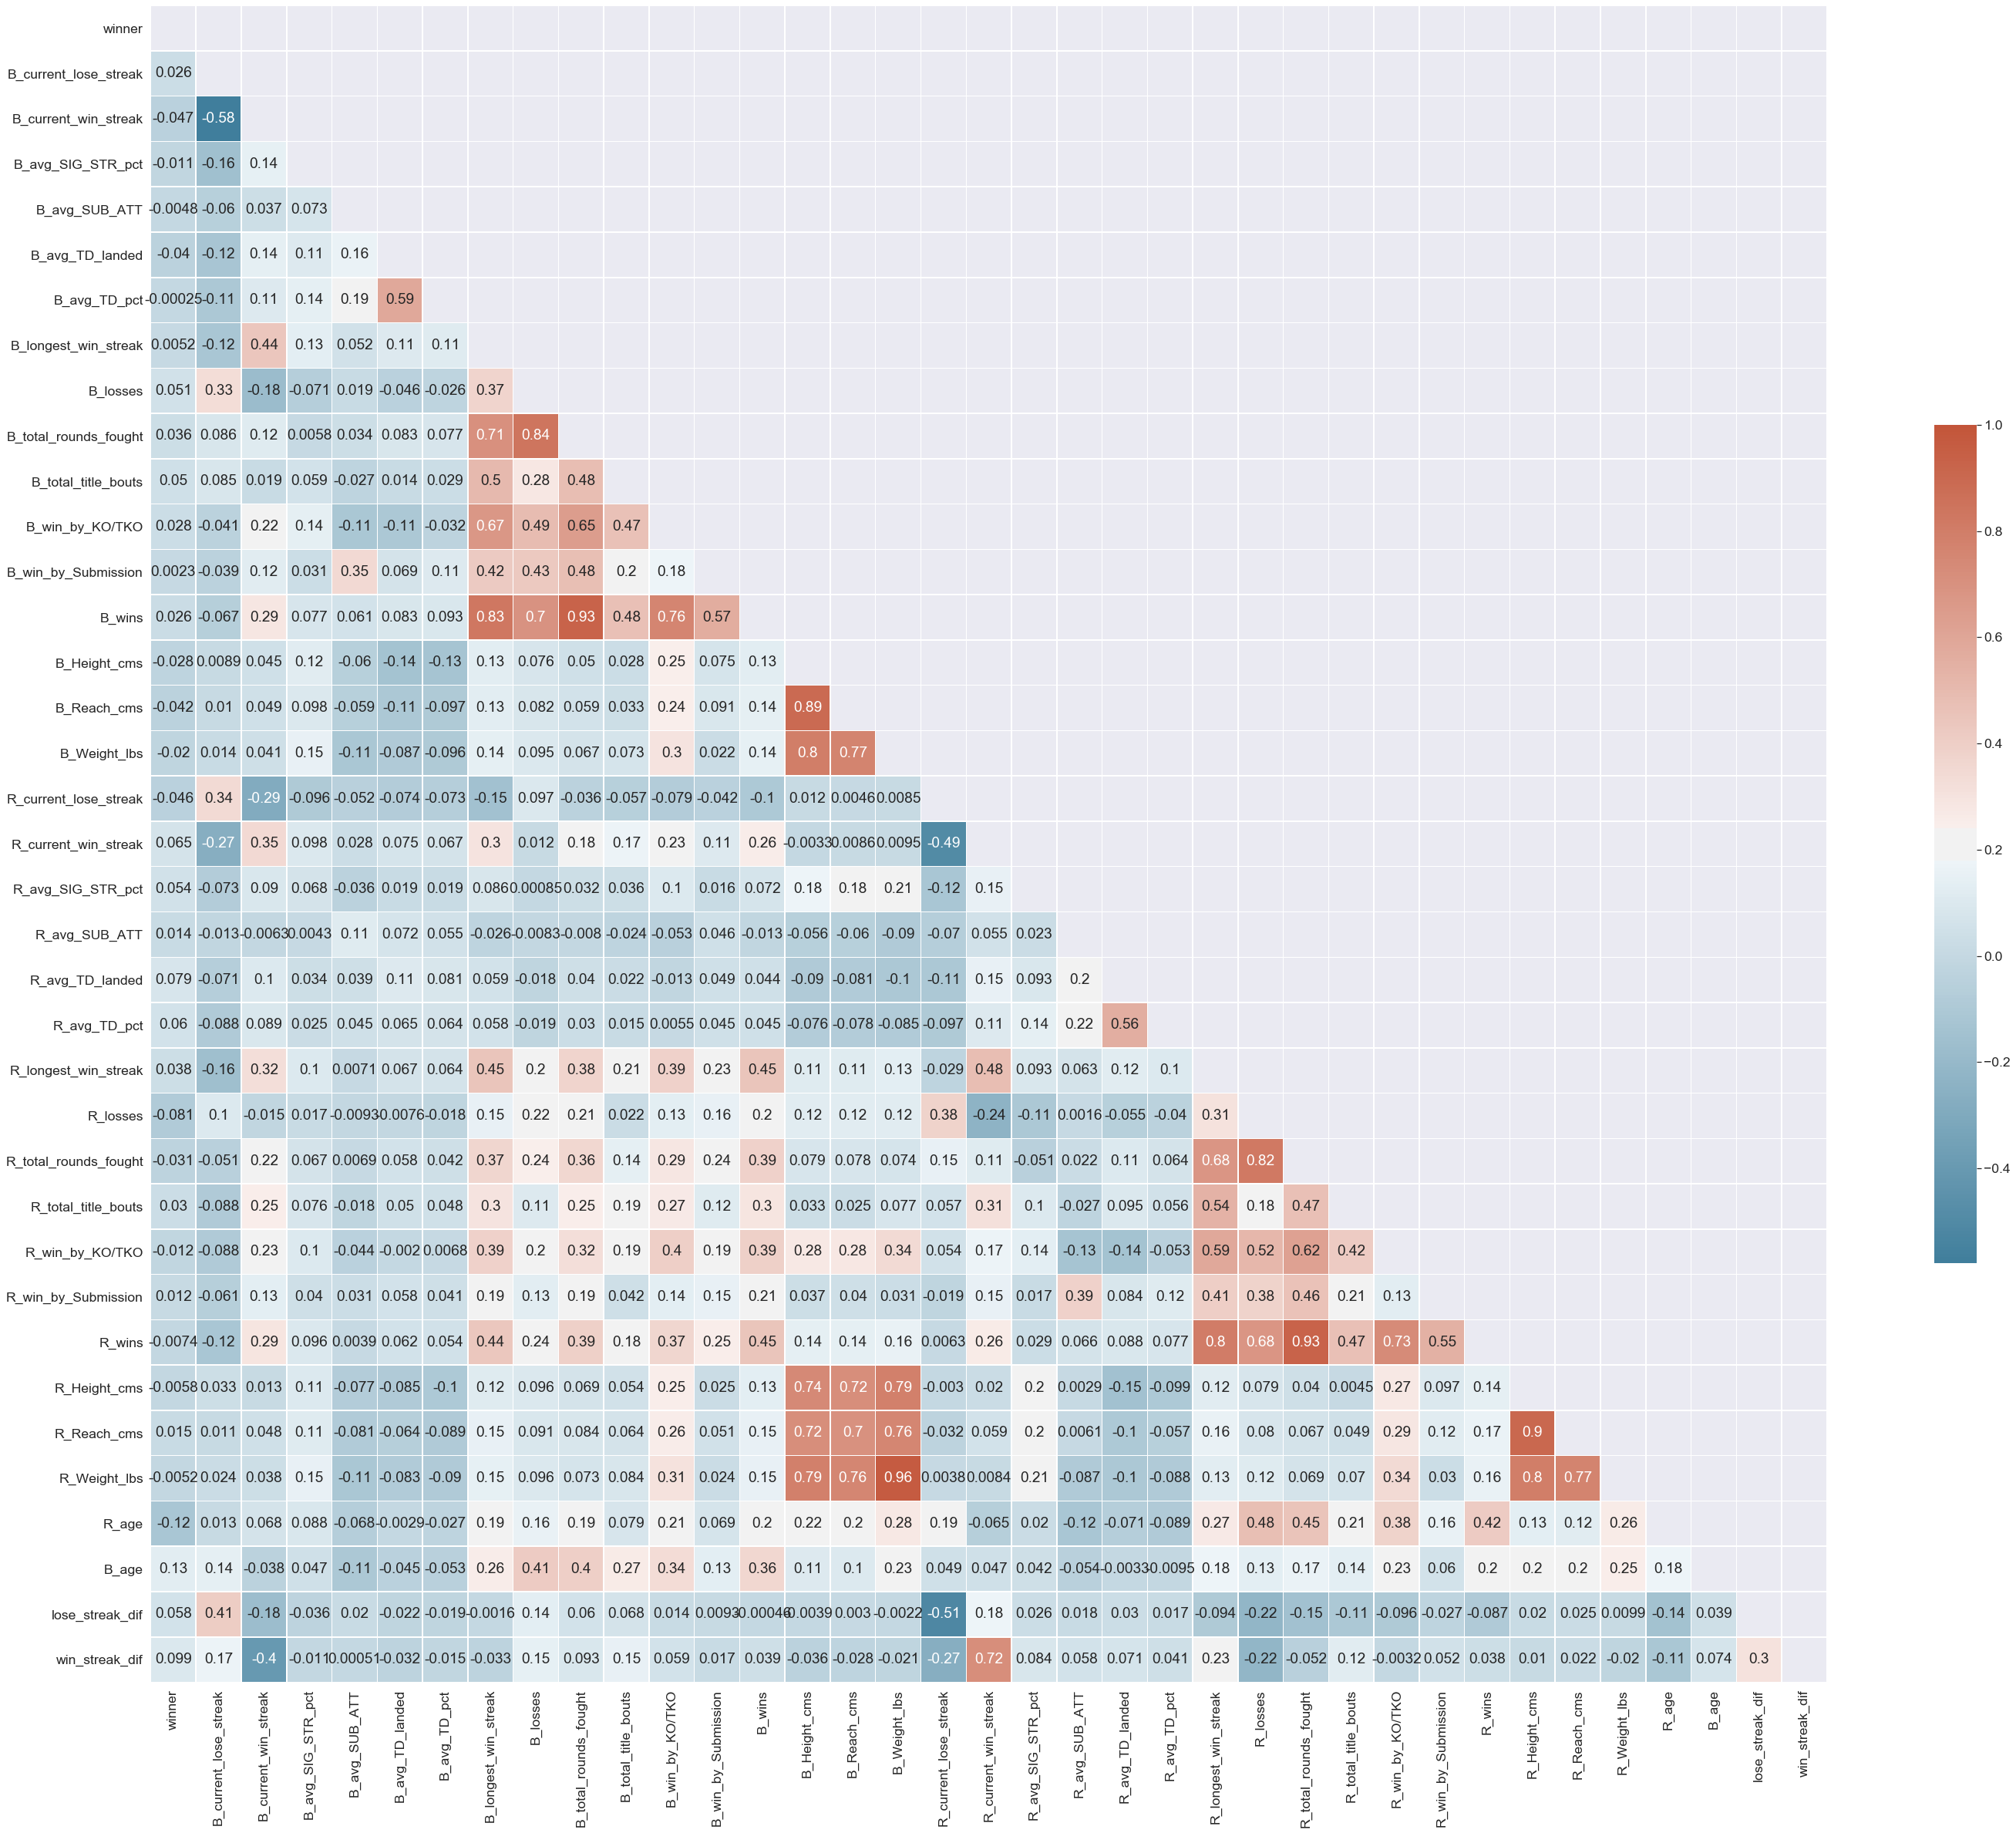

In [157]:
%matplotlib inline 
plt.figure(figsize=(50,40))
sns.set(font_scale=1.6)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr1, dtype=bool))
sns.heatmap(corr1, cmap=cmap, annot=True, mask=mask,square=True, linewidths=.5, cbar_kws={"shrink": .5})


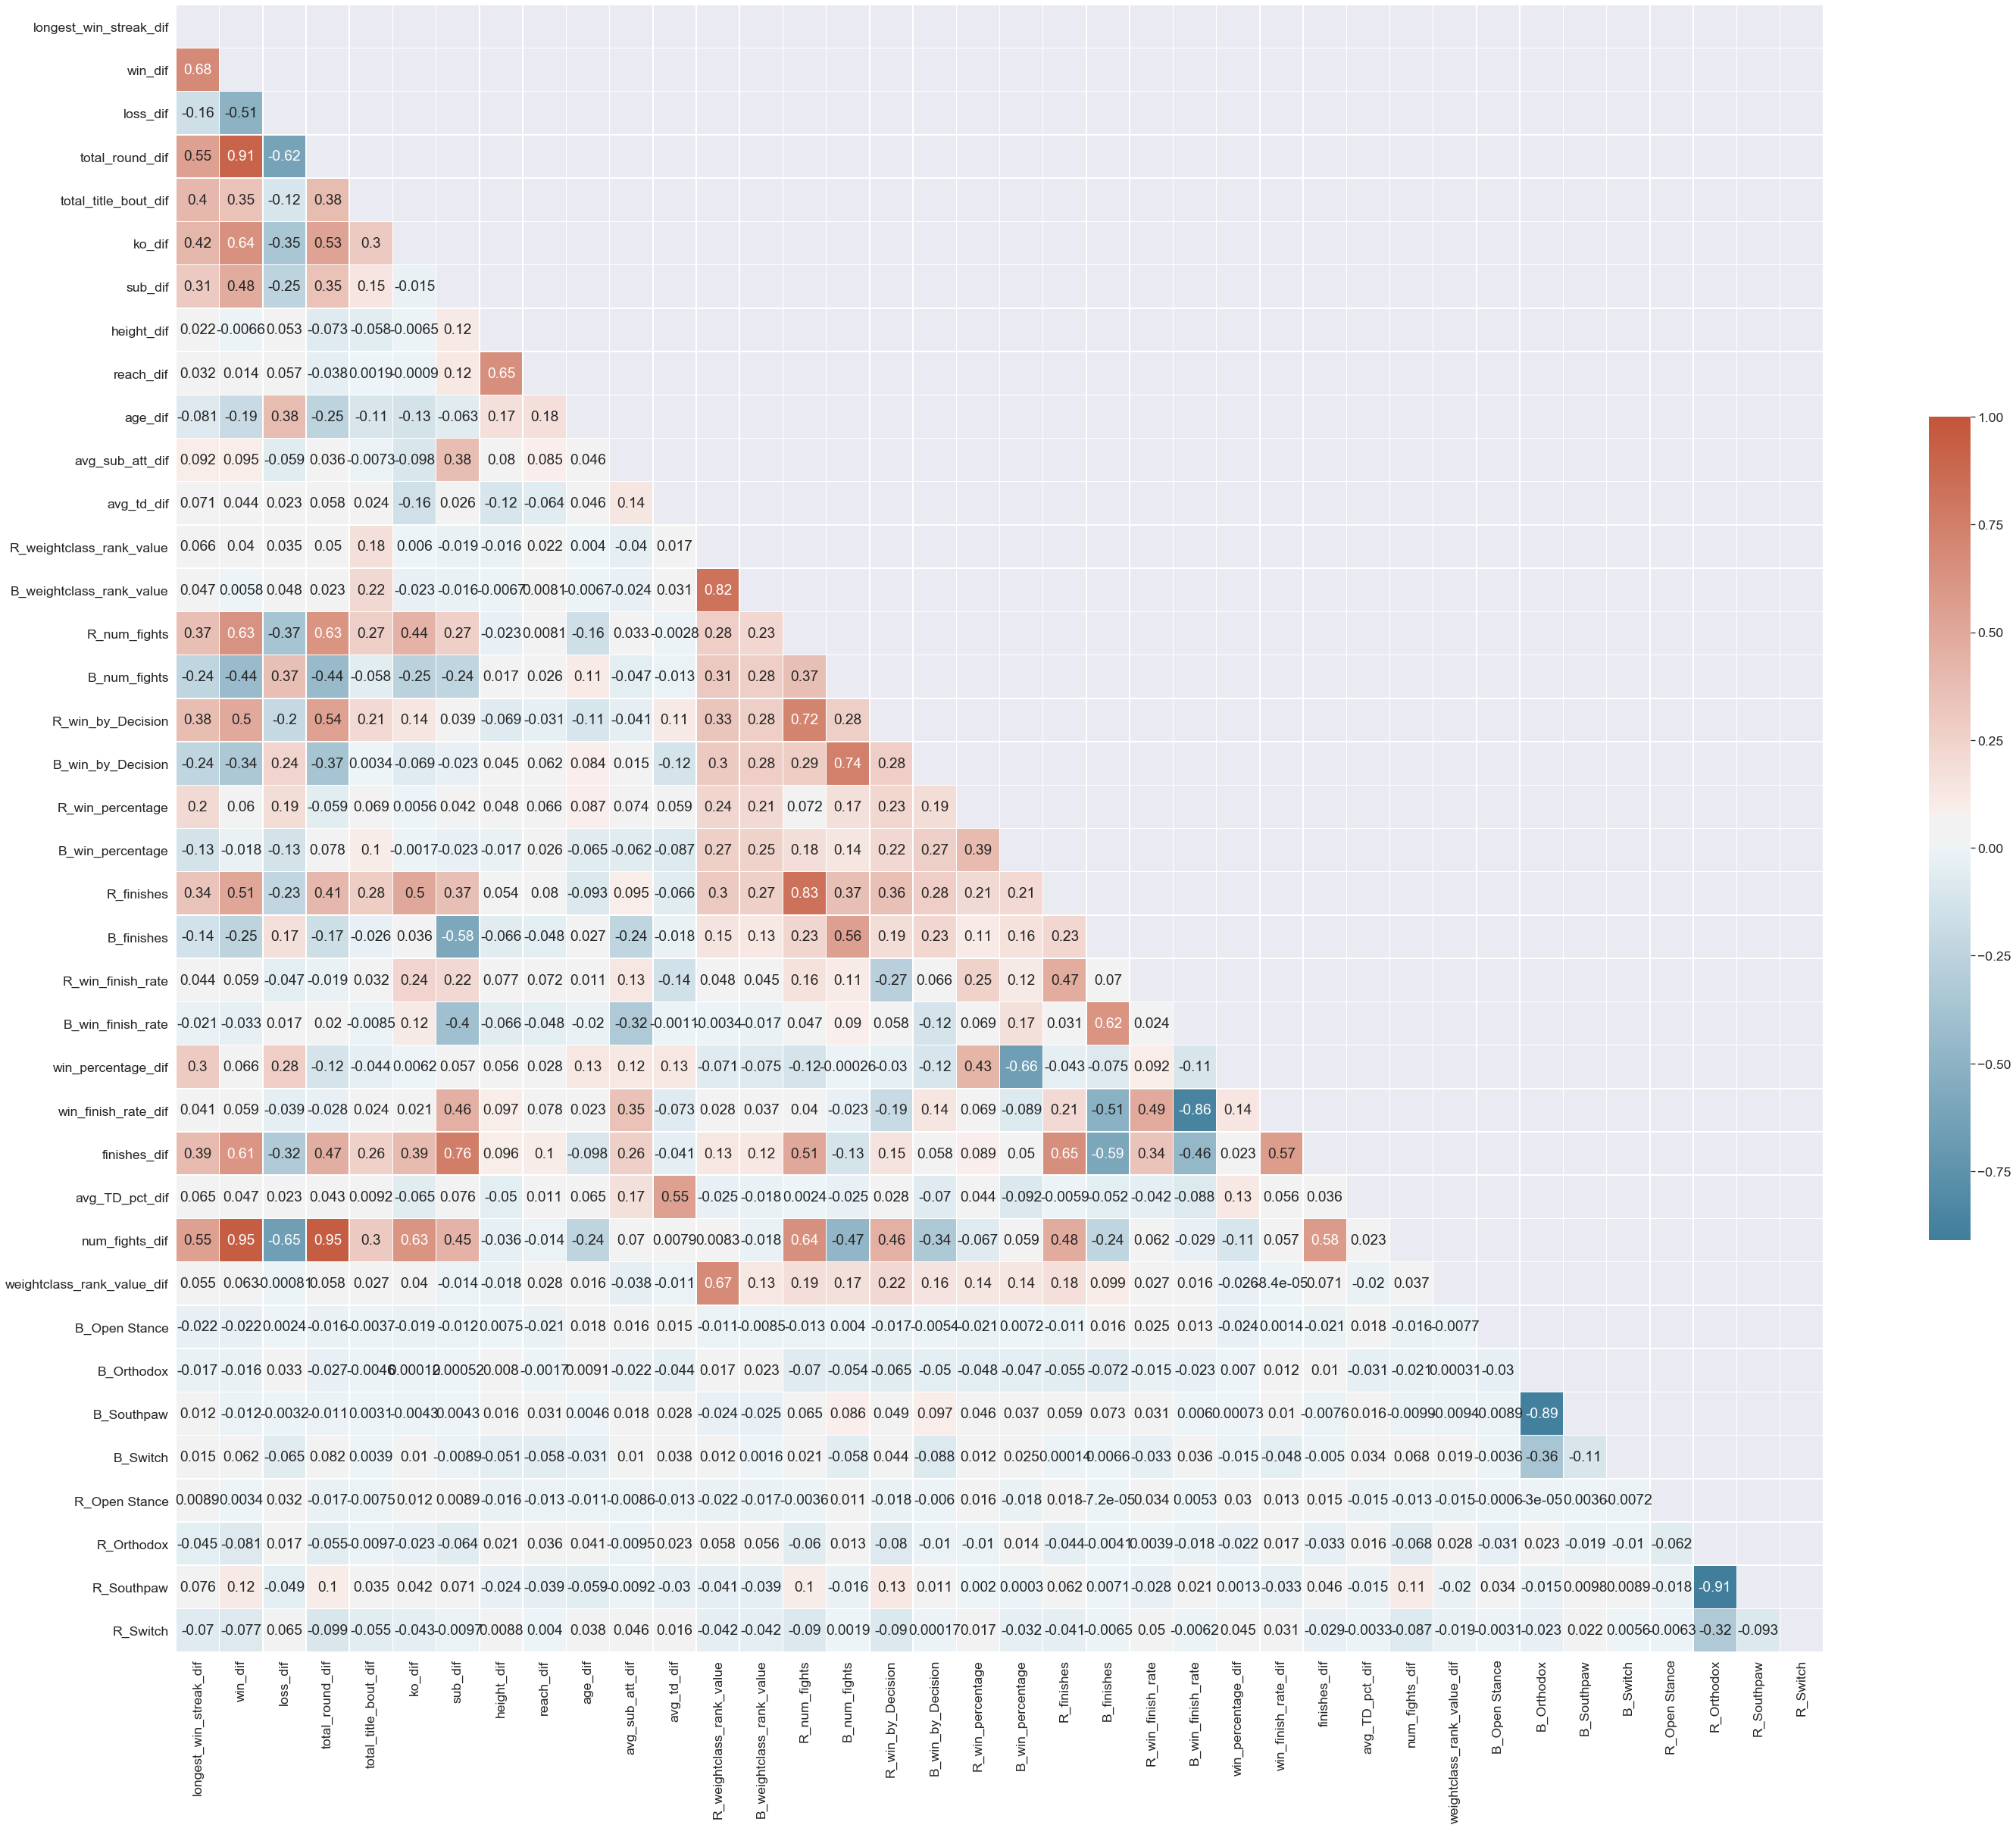

In [158]:
%matplotlib inline 
plt.figure(figsize=(50,40))
sns.set(font_scale=1.6)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr2, dtype=bool))
sns.heatmap(corr2, cmap=cmap, annot=True, mask=mask,square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Distribution of Labels (1 and 0, Red and Blue)

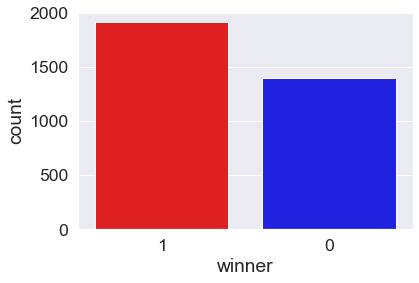

In [159]:
sns.countplot(df['winner'], order=[1,0], palette=['red','blue'])

The label seems to be balanced for the task of binary classification.

### Target Accuracy

The target accuracy for this binary classification task of predicting a winner will not be simply greater than 50%, but rather by always predicting the red fighter. The red fighter is who the UFC believes is a stronger fighter. Using this one assumption, I seek to achieve an accuracy equal to or greater than this target accuracy with a model. Of course, different expectations will be had for my test set (where the target accuracy will be shown once it is created), but all of the fights in our dataset have the target accuracy computed below.

In [160]:
baseline_predict = np.ones(len(df))

In [161]:
# importing prediction report classes
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [162]:
print(accuracy_score(df['winner'].values, baseline_predict))

0.5784224841341795


## TARGET ACCURACY = 0.578 = 57.8%

By using just 1 piece of outside information (the favored fighter form the UFC) the baseline accuracy is 0.578 or 57.8%. I think that a model that matches this accuracy would actually be performing quite well, as this is well above a truly random guess that would yield 50% accuracy, and it greater than the accuracy obtained by always selecting the fighter that the UFC promotion has declared the better fighter.

Of course, it would be sensible to use who is considered the favored fighter by the UFC to aid prediction in the model. However, I consider this data leakage, and for me defeats the purpose of predicting a winner soley off the metrics and past performance that fighters have shown before. My exception to this of course is the rankings of fighters, which will be of considerable use in the model. However, using the UFCs designated favorite is not what I would like to use for predicting a favorite. Rankings also are a bit less well defined, as there are often ranked, older fighters who are not considered favorites against lower ranked young fighters.

## Training and Test Splits, standard scaling for logistic regression.
Using random seed, my training sets for only difference columns and all columns will have the same samples. Also for reproducibility.

In [164]:
from sklearn.model_selection import train_test_split

In [165]:
X = df.drop(['winner','R_fighter', 'B_fighter', 'date'], axis=1)
y = df['winner']

# for difference columns
X_dif = X[dif_cols]

In [166]:
# Using an 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train_inds = X_train.index.values
X_test_inds = X_test.index.values

In [167]:
X_train_dif, X_test_dif, y_train, y_test = train_test_split(X_dif, y, test_size=0.2, random_state=1234)


In [168]:
from sklearn.preprocessing import StandardScaler

In [169]:
standard_scaler = StandardScaler()

In [170]:
X_train = standard_scaler.fit_transform(X = X_train)
X_test = standard_scaler.transform(X_test)

In [171]:
print('Training set size: ',len(X_train))
print('Testing set size: ', len(X_test))

Training set size:  2647
Testing set size:  662


In [172]:
standard_scaler = StandardScaler()

In [173]:
X_train_dif = standard_scaler.fit_transform(X_train_dif)
X_test_dif = standard_scaler.transform(X_test_dif)

## Accuracy in test set by always predicting UFC favorite

In [339]:
accuracy_score(y_train, np.ones(len(y_train)))

0.5859463543634303

While my target accuracy is still 57.8%, i thought it worth observing the proportion red winners in the test set.

# Principal Components Visualization

In [174]:
from sklearn.decomposition import PCA

In [175]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X)
pca_X = pca.transform(X)

In [176]:
pca_X[:][0]

array([59.23235387, 30.30038133])

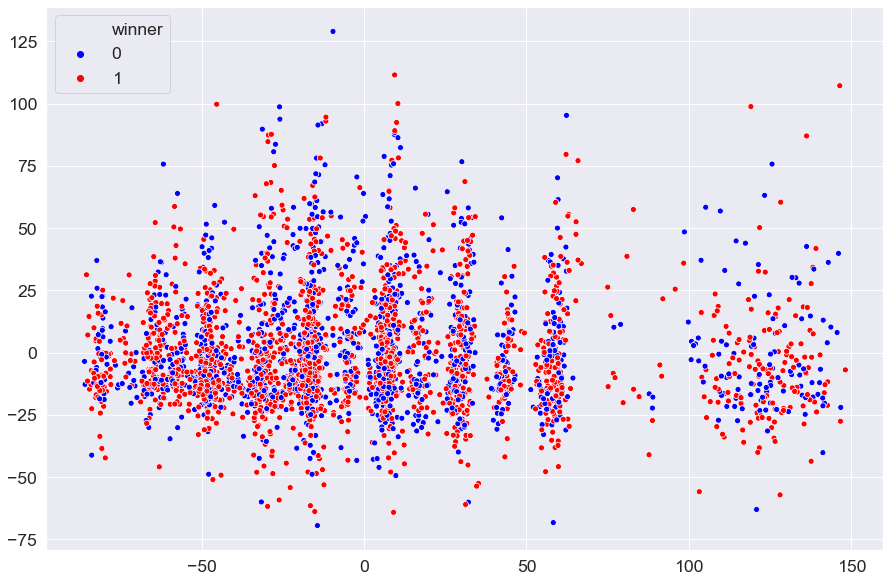

In [177]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=pca_X[:,0], y=pca_X[:,1], hue=df.winner, palette=['Blue','Red'])

## First Model: Logistic Regression
The first model will be logistic regression with no cross validation, or penalty applied

In [178]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [179]:
# using default optimizer LBGFS, and no penalty
model_LogReg = LogisticRegression(penalty='none',max_iter=10000, solver='lbfgs', random_state=1234)

In [180]:
model_LogReg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, penalty='none', random_state=1234)

In [181]:
Log_Reg_predictions = model_LogReg.predict(X_test)

In [182]:
print('Mean accuracy: ', model_LogReg.score(X_test, y_test))

Mean accuracy:  0.5649546827794562


In [183]:
print(classification_report(y_test, Log_Reg_predictions))

              precision    recall  f1-score   support

           0       0.53      0.32      0.40       299
           1       0.58      0.77      0.66       363

    accuracy                           0.56       662
   macro avg       0.55      0.54      0.53       662
weighted avg       0.56      0.56      0.54       662



In [184]:
print(confusion_matrix(y_test, Log_Reg_predictions))

[[ 95 204]
 [ 84 279]]


#### Using difference columns

In [185]:
# using default optimizer LBGFS, and no penalty
model_LogReg_dif = LogisticRegression(penalty='none',max_iter=10000, solver='lbfgs', random_state=1234)

In [186]:
model_LogReg_dif.fit(X_train_dif, y_train)

LogisticRegression(max_iter=10000, penalty='none', random_state=1234)

In [187]:
Log_Reg_dif_predictions = model_LogReg_dif.predict(X_test_dif)

In [188]:
print('Mean accuracy: ', model_LogReg_dif.score(X_test_dif, y_test))

Mean accuracy:  0.5694864048338368


In [189]:
print(classification_report(y_test, Log_Reg_dif_predictions))

              precision    recall  f1-score   support

           0       0.54      0.28      0.37       299
           1       0.58      0.80      0.67       363

    accuracy                           0.57       662
   macro avg       0.56      0.54      0.52       662
weighted avg       0.56      0.57      0.54       662



In [190]:
print(confusion_matrix(y_test, Log_Reg_dif_predictions))

[[ 85 214]
 [ 71 292]]


## Results:
Logistic Regression with no penalies applied results in rather poor performance; it achieved **an accuracy of 56.5%**.
Logistic Regression with no penalties applied and using only the difference columns achieve **an accuracy of 56.9%.**

Now I will try using Cross Validated Logistic Regression with a L1 (lasso) penalization.

## Logistic Regression Cross Validated (CV, folds=5) with Lasso (L1) penalization:

In [191]:
model_LogReg_lasso = LogisticRegressionCV(n_jobs=-1,cv = 5, penalty='l1', max_iter=10000, solver='liblinear', random_state=1234)

In [192]:
model_LogReg_lasso = model_LogReg_lasso.fit(X_train, y_train)

In [193]:
Log_Reg_lasso_predictions = model_LogReg_lasso.predict(X_test)

In [194]:
print('Mean accuracy (lasso): ', model_LogReg_lasso.score(X_test, y_test))

Mean accuracy (lasso):  0.5558912386706949


In [195]:
print(classification_report(y_test, Log_Reg_lasso_predictions))

              precision    recall  f1-score   support

           0       0.51      0.29      0.37       299
           1       0.57      0.77      0.66       363

    accuracy                           0.56       662
   macro avg       0.54      0.53      0.52       662
weighted avg       0.55      0.56      0.53       662



In [196]:
print(confusion_matrix(y_test, Log_Reg_lasso_predictions))

[[ 88 211]
 [ 83 280]]


In [197]:
print('Number of features in training set: ',len(model_LogReg_lasso.coef_[0]))
print('Number of Selected Features: ', len(model_LogReg_lasso.coef_[model_LogReg_lasso.coef_!=0]) )

Number of features in training set:  74
Number of Selected Features:  43


### Lasso selected features

In [198]:
lasso_features = pd.DataFrame(index = X.columns.values, columns=['Weight'])
lasso_features['Weight'] = model_LogReg_lasso.coef_[0]
lasso_features[lasso_features['Weight'] != 0]


Weight
B_current_lose_streak      -0.068660
B_current_win_streak       -0.161759
B_avg_SIG_STR_pct          -0.004938
B_avg_TD_pct                0.069499
B_losses                    0.023480
B_total_title_bouts         0.048822
B_win_by_KO/TKO            -0.007612
B_wins                      0.033579
B_Reach_cms                -0.000521
B_Weight_lbs               -0.119298
R_current_lose_streak       0.008770
R_avg_SIG_STR_pct           0.045657
R_avg_SUB_ATT              -0.013163
R_avg_TD_landed             0.066340
R_avg_TD_pct                0.011630
R_longest_win_streak        0.023594
R_losses                   -0.115912
R_total_title_bouts         0.057369
R_Height_cms               -0.015762
R_Weight_lbs                0.072007
R_age                      -0.252783
B_age                       0.309044
lose_streak_dif             0.007932
win_streak_dif              0.014823
longest_win_streak_dif      0.031546
loss_dif                    0.091642
total_round_dif             0.023795
ko_dif                      0.032792
sub_dif                     0.050646
height_dif                 -0.090601
reach_dif                   0.131674
avg_td_dif                  0.202752
R_weightclass_rank_value    0.005958
B_win_by_Decision          -0.049219
R_win_finish_rate           0.120124
B_win_finish_rate           0.003635
win_percentage_dif         -0.016773
weightclass_rank_value_dif  0.103854
B_Southpaw                  0.002041
B_Switch                   -0.025787
R_Open Stance              -0.000055
R_Orthodox                 -0.046042
R_Southpaw                  0.082351

## Logistic Regression with Lasso (L1) penalization results:
This time the model actually performed even worse than before. There was a **mean accuracy of 55.6%**, a slight decrease from the unpenalized model.

Now let's try a Ridge regression (L2 penalization).

## Logistic Regression using Elastic Net (L1 ratio = 0.5)

In [199]:
# saga solver must be used for elastic net regression, l1 ratio set to 0.5
model_LogReg_EN = LogisticRegressionCV(n_jobs=4,cv = 5,penalty='elasticnet',max_iter=10000, solver='saga', l1_ratios=[0.25, 0.5, 0.75], random_state=1234)

In [200]:
model_LogReg_EN = model_LogReg_EN.fit(X_train, y_train)

In [201]:
Log_Reg_EN_predictions = model_LogReg_EN.predict(X_test)

In [202]:
print('Mean accuracy (EN): ', model_LogReg_EN.score(X_test, y_test))

Mean accuracy (EN):  0.552870090634441


In [203]:
print(classification_report(y_test, Log_Reg_EN_predictions))

              precision    recall  f1-score   support

           0       0.51      0.27      0.35       299
           1       0.57      0.79      0.66       363

    accuracy                           0.55       662
   macro avg       0.54      0.53      0.50       662
weighted avg       0.54      0.55      0.52       662



In [204]:
print(confusion_matrix(y_test, Log_Reg_EN_predictions))

[[ 80 219]
 [ 77 286]]


In [205]:
print('number of Elatic net selected features: ', len(model_LogReg_EN.coef_[model_LogReg_EN.coef_ !=0]))

number of Elatic net selected features:  27


In [206]:
EN_features = pd.DataFrame(index = X.columns.values, columns=['Weight'])
EN_features['Weight'] = model_LogReg_EN.coef_[0]
EN_features[EN_features['Weight'] != 0]


Weight
B_current_lose_streak      -0.021971
B_current_win_streak       -0.102180
B_avg_TD_pct                0.044490
B_total_title_bouts         0.026368
B_Reach_cms                -0.010578
B_Weight_lbs               -0.021502
R_avg_SIG_STR_pct           0.036083
R_avg_TD_landed             0.067510
R_avg_TD_pct                0.010945
R_losses                   -0.071509
R_total_title_bouts         0.050337
R_win_by_Submission         0.010746
R_Height_cms               -0.012345
R_age                      -0.204298
B_age                       0.253780
win_streak_dif              0.036727
longest_win_streak_dif      0.048812
loss_dif                    0.064965
height_dif                 -0.043322
reach_dif                   0.089868
age_dif                     0.041533
avg_td_dif                  0.174355
R_win_finish_rate           0.106021
weightclass_rank_value_dif  0.099531
B_Switch                   -0.014113
R_Orthodox                 -0.046832
R_Southpaw                  0.064279

### Logistic Regression with Elastic net (l1 ratio = 0.5) results:

Again, relatively poor results. The **mean accuracy was 55.3%**. There were only 27 features selected, but the predictive performance has not improved.

## Logistic Regression with Stratified K-Fold RFE feature selection:

Now I will use an unpenalized logistic regression but by selecting features using cross validated recursive feature elimination to eliminate features. I have 74 features, and I believe there is a lot of noise from the poor performance of the previous logistic regressions. I will use RFE to eliminate features, then create a logistic regression.

In [207]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [208]:
# 5 folds that are shuffled, using a random state seed for reproducibility
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

In [209]:
log_reg = LogisticRegression(penalty='none',max_iter=10000, solver='lbfgs', random_state=1234)

min_features = 5

# RFE cross validated with stratified KFold object created above

rfecv = RFECV(estimator=log_reg, step=1, cv=skf,
              scoring='accuracy',
              min_features_to_select=min_features, n_jobs = 4)
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
      estimator=LogisticRegression(max_iter=10000, penalty='none',
                                   random_state=1234),
      min_features_to_select=5, n_jobs=4, scoring='accuracy')

Optimal number of features : 44


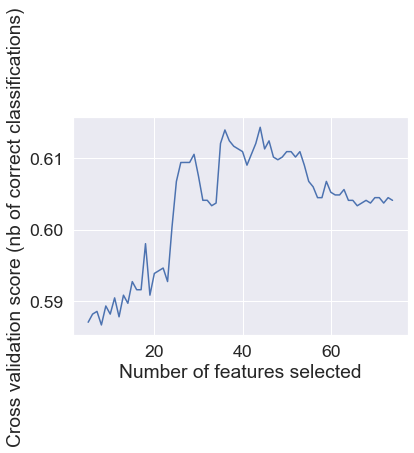

In [210]:


print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features,
               len(rfecv.grid_scores_) + min_features),
         rfecv.grid_scores_)
plt.show()

In [211]:
rfecv_preds = rfecv.predict(X_test)

In [212]:
accuracy_score(y_test, rfecv_preds)

0.5558912386706949

This is horrible accuracy. I am going to increase the number of folds. My model still seems to be too biased to the training data.

In [213]:
skf_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
rfecv_10 = RFECV(estimator=log_reg, step=1, cv=skf_10,
              scoring='accuracy',
              min_features_to_select=min_features, n_jobs = 4)
rfecv_10.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
      estimator=LogisticRegression(max_iter=10000, penalty='none',
                                   random_state=1234),
      min_features_to_select=5, n_jobs=4, scoring='accuracy')

Optimal number of features : 38


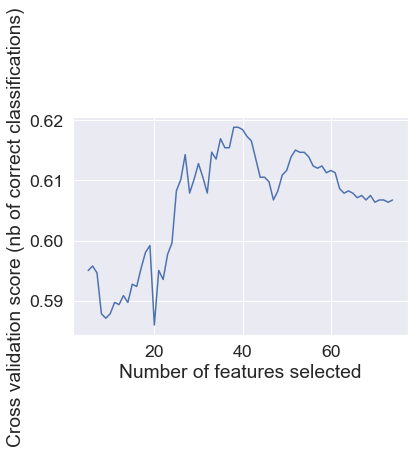

In [214]:


print("Optimal number of features : %d" % rfecv_10.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features,
               len(rfecv_10.grid_scores_) + min_features),
         rfecv_10.grid_scores_)
plt.show()

In [215]:
rfecv_10_preds = rfecv_10.predict(X_test)

In [216]:
accuracy_score(y_test, rfecv_10_preds)

0.5619335347432024

In [217]:
print(classification_report(y_test, rfecv_10_preds))

              precision    recall  f1-score   support

           0       0.53      0.31      0.39       299
           1       0.58      0.77      0.66       363

    accuracy                           0.56       662
   macro avg       0.55      0.54      0.52       662
weighted avg       0.55      0.56      0.54       662



## Logistic Regression with RFE feature selection results:

**An accuracy of 56.2% was acheived with 38 features.** Something of note with this model and the previous ones is the big difference in recall for the positive and negative classes. The models are predicting the Red fighter victory much more than the losing fighter, and this is helping increase accuracy but underdog winners (blue fighters) are only correctly predicted about 30% of the time accross the models.

Now, I will use the same RFE approach but for a Linear Support Vector Machine classifier (LienarSVC). First I will get a baseline prediction using all features, then predictions using stratified K fold RFE with 10 folds. Then, I will use a grid search to find the optimal 

# Feature selection using random forests:

Using random forests to get feature importance.

In [218]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [219]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 300, random_state=1234))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=300,
                                                 random_state=1234))

In [220]:
len(np.sort(X.columns.values[sel.get_support()]))

33

In [221]:
sel_features = np.sort(X.columns.values[sel.get_support()])

In [222]:
print(sel_features)

['B_Height_cms' 'B_Reach_cms' 'B_Weight_lbs' 'B_age' 'B_avg_SIG_STR_pct'
 'B_avg_SUB_ATT' 'B_avg_TD_landed' 'B_avg_TD_pct' 'B_total_rounds_fought'
 'B_win_percentage' 'R_Height_cms' 'R_Reach_cms' 'R_Weight_lbs' 'R_age'
 'R_avg_SIG_STR_pct' 'R_avg_SUB_ATT' 'R_avg_TD_landed' 'R_avg_TD_pct'
 'R_total_rounds_fought' 'R_win_finish_rate' 'R_win_percentage' 'age_dif'
 'avg_TD_pct_dif' 'avg_sub_att_dif' 'avg_td_dif' 'height_dif' 'loss_dif'
 'num_fights_dif' 'reach_dif' 'total_round_dif' 'win_dif'
 'win_finish_rate_dif' 'win_percentage_dif']


The selected features from the random forest are shown above. Now, I will train a random forest model with grid search on these selected parameters. First I will make a test set with the new features, and rescale this new training set.

### Random Forest Classifier using selected features and randomized search

In [223]:
# first creating new training set with selected features
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X.loc[:,sel_features], y, test_size=0.2, random_state=1234)
X_train_sel_inds = X_train_sel.index.values
X_test_sel_inds = X_test_sel.index.values


In [224]:
# rescaling
scaler_new = StandardScaler()

In [225]:
X_train_sel = scaler_new.fit_transform(X_train_sel)
X_test_sel = scaler_new.transform(X_test_sel)

In [226]:
# params for grid search
grid_search_params = {
    'n_estimators':np.arange(300,800,step=100),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, None],
    'criterion' : ['gini', 'entropy'],
    'min_samples_leaf': [2,4,6],
    'min_samples_split': [2,5,10]
}

In [227]:
import time
from sklearn.model_selection import RandomizedSearchCV

In [228]:
# random forest to use for grid search
rand_forest = RandomForestClassifier(n_jobs = -1, random_state=1234)

In [229]:
start = time.time()
# randomized search object that will contain the best parameters for a random forest model
# I have elected 10 folds Stratified cross validation (Strat KFold is default for randomized search)
rs_CV = RandomizedSearchCV(estimator = rand_forest, param_distributions = grid_search_params, cv=10, n_iter = 50,
                           random_state=1234, verbose=0, n_jobs=-1)
rs_CV.fit(X_train_sel, y_train_sel)
end = time.time()

In [230]:
end-start

637.547844171524

In [231]:
# best parameters from the cross validated randomized search
rs_CV.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 80,
 'criterion': 'gini'}

In [232]:
rs_CV.best_estimator_

RandomForestClassifier(max_depth=80, max_features='log2', min_samples_leaf=4,
                       n_estimators=600, n_jobs=-1, random_state=1234)

In [233]:
selected_rand_forest = rs_CV.best_estimator_ #RandomForestClassifier(n_estimators = 500, min_samples_split=5, min_samples_leaf=2,
                                             #max_features='auto', max_depth=30, criterion='gini', bootstrap=True,
                                              #n_jobs=-1, random_state=1234)
selected_rand_forest.fit(X_train_sel, y_train_sel)
                                                

RandomForestClassifier(max_depth=80, max_features='log2', min_samples_leaf=4,
                       n_estimators=600, n_jobs=-1, random_state=1234)

In [234]:
# predictions
sel_rand_forest_predictions = selected_rand_forest.predict(X_test_sel)

In [235]:
accuracy_score(y_test_sel, sel_rand_forest_predictions)

0.5709969788519638

In [236]:
print(classification_report(y_test_sel, sel_rand_forest_predictions))

              precision    recall  f1-score   support

           0       0.55      0.26      0.35       299
           1       0.58      0.83      0.68       363

    accuracy                           0.57       662
   macro avg       0.56      0.54      0.52       662
weighted avg       0.57      0.57      0.53       662



# Linear SVC
Now I will try a support vector machine approach using a Linear Support Vector Classifier. First I will get baseline SVC models (suing all default parameters) for the full training set, then with the Random Forest selected features (X_train_sel), and finally with with the training set using only the difference columns. Then, I will use a randomized or grid search to find the best SVC model.

#### Full dataset

In [238]:
from sklearn.svm import LinearSVC, SVC

In [244]:
model_SVC =  LinearSVC(random_state=1234, max_iter=100000)

In [245]:
model_SVC.fit(X_train, y_train)

LinearSVC(max_iter=100000, random_state=1234)

In [246]:
svc_predictions = model_SVC.predict(X_test)

In [247]:
accuracy_score(y_test, svc_predictions)

0.5619335347432024

In [248]:
print(classification_report(y_test, svc_predictions))

              precision    recall  f1-score   support

           0       0.53      0.30      0.39       299
           1       0.57      0.77      0.66       363

    accuracy                           0.56       662
   macro avg       0.55      0.54      0.52       662
weighted avg       0.55      0.56      0.54       662



In [249]:
print(confusion_matrix(y_test, svc_predictions))

[[ 91 208]
 [ 82 281]]


#### Random Forest selected features

In [250]:
model_SVC_sel = LinearSVC(random_state=1234, max_iter=1000000)

In [251]:
model_SVC_sel.fit(X_train_sel, y_train)

LinearSVC(max_iter=1000000, random_state=1234)

In [252]:
svc_sel_predictions = model_SVC_sel.predict(X_test_sel)

In [253]:
accuracy_score(y_test, svc_sel_predictions)

0.5664652567975831

In [254]:
print(classification_report(y_test, svc_sel_predictions))

              precision    recall  f1-score   support

           0       0.54      0.25      0.35       299
           1       0.57      0.82      0.68       363

    accuracy                           0.57       662
   macro avg       0.56      0.54      0.51       662
weighted avg       0.56      0.57      0.53       662



In [255]:
print(confusion_matrix(y_test, svc_sel_predictions))

[[ 76 223]
 [ 64 299]]


#### Difference in metrics only features training set

In [256]:
model_SVC_dif = LinearSVC(random_state=1234, max_iter=1000000)

In [257]:
model_SVC_dif.fit(X_train_dif, y_train)

LinearSVC(max_iter=1000000, random_state=1234)

In [258]:
svc_dif_predictions = model_SVC_dif.predict(X_test_dif)

In [259]:
accuracy_score(y_test, svc_dif_predictions)

0.5694864048338368

In [260]:
print(classification_report(y_test, svc_dif_predictions))

              precision    recall  f1-score   support

           0       0.55      0.28      0.37       299
           1       0.58      0.81      0.67       363

    accuracy                           0.57       662
   macro avg       0.56      0.54      0.52       662
weighted avg       0.56      0.57      0.54       662



In [261]:
print(confusion_matrix(y_test, svc_dif_predictions))

[[ 84 215]
 [ 70 293]]


## SVC baseline results:
Full dataset: **accuracy = 56.2%**
Random Forest selected features: **accuracy = 57.4%**
Only difference features: **accuracy = 56.9%**

I will not explore Support Vector Machine models further as the performance is not great, and my earlier prinicpal components plot with 2 component show that the data is not linearly seperable for a Support Vector Machine.

### StatsModels generalized linear model approach for difference columns training set (training set with RandomForest selected features resulted in Hessian warnings)

In [262]:
import statsmodels.api as sm

In [263]:
sm_Logit_model_dif = sm.Logit(y_train, sm.add_constant(X_train_dif)).fit(maxiter=100, method='bfgs')

Optimization terminated successfully.
         Current function value: 0.647534
         Iterations: 58
         Function evaluations: 59
         Gradient evaluations: 59


In [264]:
sm_Logit_model_dif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 winner   No. Observations:                 2647
Model:                          Logit   Df Residuals:                     2626
Method:                           MLE   Df Model:                           20
Date:                Tue, 12 Jan 2021   Pseudo R-squ.:                 0.04536
Time:                        17:15:54   Log-Likelihood:                -1714.0
converged:                       True   LL-Null:                       -1795.5
Covariance Type:            nonrobust   LLR p-value:                 2.089e-24
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3714      0.041      9.085      0.000       0.291       0.452
x1            -0.0221      0.048     -0.461      0.645      -0.116       0.072
x2             0.1094      0.049      2.213      0.027       0.013       0.206
x3             0.0566      0.071      0.793      0.428      -0.083       0.196
x4             0.2337      0.241      0.971      0.332      -0.238       0.705
x5            -0.0501      0.069     -0.726      0.468      -0.185       0.085
x6             0.2598      0.199      1.303      0.193      -0.131       0.651
x7            -0.0278      0.053     -0.523      0.601      -0.132       0.076
x8             0.1657      0.088      1.883      0.060      -0.007       0.338
x9             0.1679      0.095      1.761      0.078      -0.019       0.355
x10           -0.1017      0.055     -1.852      0.064      -0.209       0.006
x11            0.1509      0.055      2.747      0.006       0.043       0.259
x12            0.3165      0.046      6.857      0.000       0.226       0.407
x13           -0.0087      0.047     -0.184      0.854      -0.101       0.084
x14            0.2487      0.053      4.702      0.000       0.145       0.352
x15           -0.0016      0.054     -0.031      0.976      -0.107       0.104
x16            0.0146      0.060      0.243      0.808      -0.103       0.133
x17           -0.0199      0.095     -0.209      0.834      -0.206       0.166
x18           -0.0599      0.050     -1.207      0.227      -0.157       0.037
x19           -0.7727      0.300     -2.573      0.010      -1.361      -0.184
x20            0.1301      0.044      2.977      0.003       0.044       0.216
==============================================================================
"""

In [265]:
predict_sm_logit_dif = sm_Logit_model_dif.predict(sm.add_constant(X_test_dif))
predict_sm_logit_dif = (predict_sm_logit_dif>=0.5).astype(int)

In [266]:
print(classification_report(y_test, predict_sm_logit_dif))


              precision    recall  f1-score   support

           0       0.54      0.28      0.37       299
           1       0.58      0.80      0.67       363

    accuracy                           0.57       662
   macro avg       0.56      0.54      0.52       662
weighted avg       0.56      0.57      0.54       662



In [267]:
accuracy_score(y_test, predict_sm_logit_dif)

0.5694864048338368

# Neural Network Approach
For my final approach to getting the best model, I will train a neural network with a sigmoid activation function for the output layer since this is a binary classification task. Let's proceed with first setting up the artifical neural network. First, however, I will rescale the original training sets with a min max scaler.

I will also split into train/validate/test splits to have a validation set for the neural network. I have decided on a 65/15/20 split. I will be training neural networks on the full dataset, difference only columns, and random forest selected features.

In [268]:
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X.values, y.values, test_size=0.2, random_state=1234)
X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_train_NN, y_train_NN, test_size = 0.1875, random_state=1234)

X_train_dif_NN, X_test_dif_NN, y_train_NN, y_test_NN = train_test_split(X_dif.values, y.values, test_size=0.2, random_state=1234)
X_train_dif_NN, X_val_dif_NN, y_train_NN, y_val_NN = train_test_split(X_train_dif_NN, y_train_NN, test_size = 0.1875, random_state=1234)

X_train_sel_NN, X_test_sel_NN, y_train_NN, y_test_NN = train_test_split(X[sel_features].values, y.values, test_size=0.2, random_state=1234)
X_train_sel_NN, X_val_sel_NN, y_train_NN, y_val_NN = train_test_split(X_train_sel_NN, y_train_NN, test_size = 0.1875, random_state=1234)



In [269]:
from sklearn.preprocessing import MinMaxScaler

In [270]:
MM_scaler1 = MinMaxScaler()
X_train_NN = MM_scaler1.fit_transform(X_train_NN)
X_val_NN = MM_scaler1.transform(X_val_NN)
X_test_NN = MM_scaler1.transform(X_test_NN)

In [271]:
MM_scaler2 = MinMaxScaler()
X_train_dif_NN = MM_scaler2.fit_transform(X_train_dif_NN)
X_val_dif_NN = MM_scaler2.transform(X_val_dif_NN)
X_test_dif_NN = MM_scaler2.transform(X_test_dif_NN)

In [272]:
MM_scaler3 = MinMaxScaler()
X_train_sel_NN = MM_scaler3.fit_transform(X_train_sel_NN)
X_val_sel_NN = MM_scaler3.transform(X_val_sel_NN)
X_test_sel_NN = MM_scaler3.transform(X_test_sel_NN)

In [273]:
print(X_train_NN.shape)
print(X_train_dif_NN.shape)
print(X_train_sel_NN.shape)

(2150, 74)
(2150, 20)
(2150, 33)


In [341]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow import keras

## Full training set

In [275]:
# creating NN model
model_full = Sequential()

model_full.add(Dense(units=74, activation='relu'))
model_full.add(Dropout(rate=0.3))

model_full.add(Dense(units=37, activation='relu'))
model_full.add(Dropout(rate=0.3))

#model_full.add(Dense(units=18, activation='relu'))
#model_full.add(Dropout(rate=0.3))

# binary classification output layer
model_full.add(Dense(units=1, activation='sigmoid'))

opt = optimizers.Adam(learning_rate=1e-5)
model_full.compile(loss='binary_crossentropy', metrics='accuracy', optimizer=opt)


In [276]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [277]:
model_full.fit(x=X_train_NN, y = y_train_NN, epochs=500, validation_data= (X_val_NN, y_val_NN), batch_size=8, 
               callbacks = [early_stop],
               verbose=0,
               use_multiprocessing=True)

Epoch 00383: early stopping


In [278]:
loss_full = pd.DataFrame(model_full.history.history)

<Figure size 2160x1440 with 0 Axes>

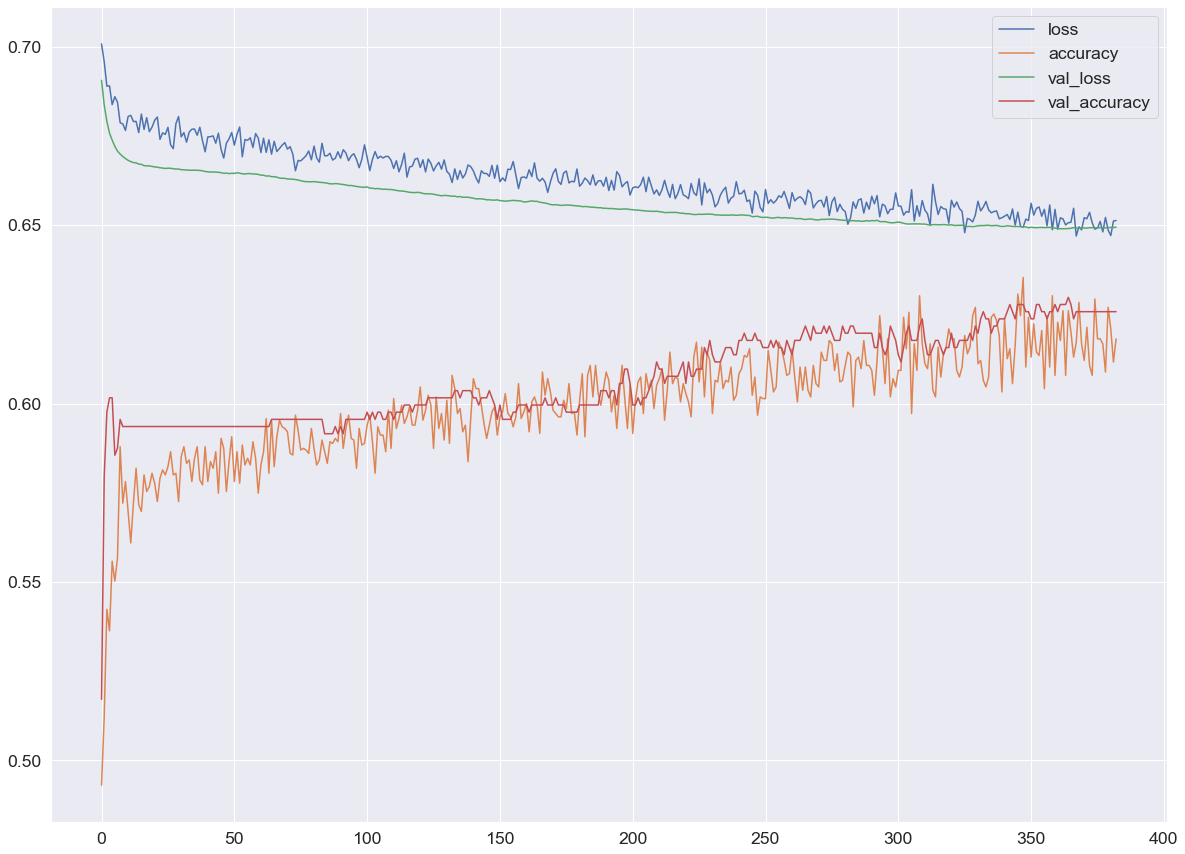

In [279]:
plt.figure(figsize=(30,20))
loss_full.plot(figsize=(20,15))

In [283]:
probs_full_NN = model_full.predict(X_test_NN)
probs_full_NN = np.append(1-probs_full_NN,probs_full_NN,axis=1)


In [284]:
predictions_full_NN = np.argmax(probs_full_NN, axis=-1)

### Optimal probability threshold for 1 (red) label to increase accuracy (since all models are biased towards postive case)
### TODO: Function to use best probability threshold for predicting classes

In [301]:
predictions_full_NN = [1 if x[1] >= 0.50 else 0 for x in probs_full_NN]

In [302]:
print(accuracy_score(y_test_NN,predictions_full_NN))

0.5876132930513596


In [303]:
print(classification_report(y_test_NN, predictions_full_NN))

              precision    recall  f1-score   support

           0       0.62      0.23      0.34       299
           1       0.58      0.88      0.70       363

    accuracy                           0.59       662
   macro avg       0.60      0.56      0.52       662
weighted avg       0.60      0.59      0.54       662



In [304]:
print(confusion_matrix(y_test_NN, predictions_full_NN))

[[ 69 230]
 [ 43 320]]


# Random Forest Selected Features Artifical Neural Network

In [305]:
X_test_sel_NN.shape

(662, 33)

# BEST SO FAR, BATCH=16,8 model below, learning rate 1e-4
used on random forest selected features

# creating NN model
model_sel = Sequential()

model_sel.add(Dense(units=33, activation='relu'))
model_sel.add(Dropout(rate=0.3))

model_sel.add(Dense(units=16, activation='relu'))
model_sel.add(Dropout(rate=0.3))

#model_sel.add(Dense(units=8, activation='relu'))
#model_sel.add(Dropout(rate=0.1))

# binary classification output layer
model_sel.add(Dense(units=1, activation='sigmoid'))

opt = optimizers.Adam(learning_rate=1e-4)
model_sel.compile(loss='binary_crossentropy', metrics='accuracy', optimizer=opt)


In [310]:
# creating NN model
model_sel = Sequential()

model_sel.add(Dense(units=33, activation='relu'))
model_sel.add(Dropout(rate=0.30))

model_sel.add(Dense(units=16, activation='relu'))
model_sel.add(Dropout(rate=0.30))

#model_sel.add(Dense(units=8, activation='relu'))
#model_sel.add(Dropout(rate=0.1))

# binary classification output layer
model_sel.add(Dense(units=1, activation='sigmoid'))

opt = optimizers.Adam(learning_rate=1e-4)
model_sel.compile(loss='binary_crossentropy', metrics='accuracy', optimizer=opt)


In [311]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [312]:
model_sel.fit(x=X_train_sel_NN, y = y_train_NN, epochs=1000, validation_data= (X_val_sel_NN, y_val_NN), batch_size=8, 
               callbacks = [early_stop],
               verbose=0,
               use_multiprocessing=True)

Epoch 00163: early stopping


In [349]:
# load model
#model_sel = keras.models.load_model('model_sel.h5')

In [348]:
model_sel.history

In [350]:
loss_sel = pd.DataFrame(model_sel.history.history)

<Figure size 2160x1440 with 0 Axes>

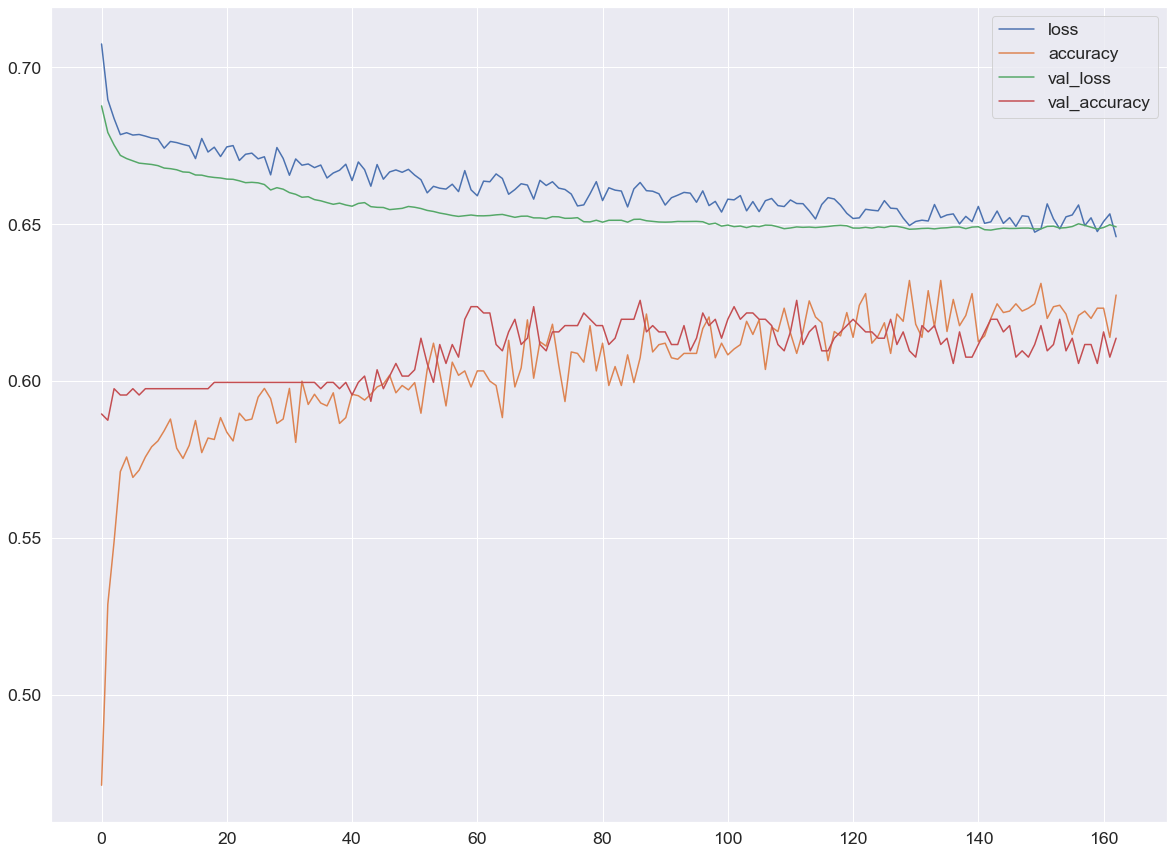

In [314]:
plt.figure(figsize=(30,20))
loss_sel.plot(figsize=(20,15))

In [315]:
probs_sel_NN = model_sel.predict(X_test_sel_NN)
probs_sel_NN = np.append(1-probs_sel_NN,probs_sel_NN,axis=1)


In [316]:
predictions_sel_NN = np.argmax(probs_sel_NN, axis=-1)

In [333]:
predictions_sel_NN = [1 if x[1] >= 0.49 else 0 for x in probs_sel_NN]

In [340]:
print('Neural network accuracy using random forest selected features: \n',accuracy_score(y_test_NN,predictions_sel_NN))

Neural network accuracy using random forest selected features: 
 0.5936555891238671


In [330]:
print(classification_report(y_test_NN, predictions_sel_NN))

              precision    recall  f1-score   support

           0       0.63      0.25      0.35       299
           1       0.59      0.88      0.70       363

    accuracy                           0.59       662
   macro avg       0.61      0.56      0.53       662
weighted avg       0.60      0.59      0.55       662



In [335]:
print(confusion_matrix(y_test, predictions_sel_NN))

[[ 74 225]
 [ 44 319]]


In [342]:
# saving model
model_sel.save('model_sel.h5')

# Current Progress
Where I am currently at is a model that is predicting on the test set at 59.4% accuracy. This is achieved using features selected by a random forest model. The hyperparameters for the neural network were selected by manual trial and error. Once a hyperparameter scheme is finetuned for the data (and after building a neural network for only the difference features), as well as a simple probability threshold for predicting classes from sigmoid function probabilties, then I believe over 60% accuracy will be achieved.